<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Cryptocurrency/Bitcoin/Bitcoin_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "mczielinski/bitcoin-historical-data"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

Saving kaggle.json to kaggle.json
boosterBytes
DeepLearning_1_AutoML_20190725_020843.zip
DeepLearning_grid_1_AutoML_20190724_233920_model_1.zip
DeepLearning_grid_1_AutoML_20190725_001516_model_8.zip
DeepLearning_grid_1_AutoML_20190725_002610_model_5.zip
DeepLearning_grid_1_AutoML_20190725_003326_model_7.zip
DeepLearning_grid_1_AutoML_20190725_010505_model_3.zip
DeepLearning_grid_1_AutoML_20190725_014503_model_8.zip
DeepLearning_grid_1_AutoML_20190725_015609_model_2.zip
DeepLearning_grid_1_AutoML_20190725_020256_model_3.zip
DeepLearning_grid_1_AutoML_20190725_022014_model_3.zip
domains
experimental
feature_map
features_dataset
finmarketpy.log
full_dataset
GLM_grid_1_AutoML_20190725_002329_model_1.zip
GLM_grid_1_AutoML_20190725_002424_model_1.zip
GLM_grid_1_AutoML_20190725_003239_model_1.zip
GLM_grid_1_AutoML_20190725_010216_model_1.zip
GLM_grid_1_AutoML_20190725_011351_model_1.zip
GLM_grid_1_AutoML_20190725_020108_model_1.zip
GLM_grid_1_AutoML_20190725_020151_model_1.zip
GLM_grid_1_Auto

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


Open      High       Low     Close      Volume  Volume_(Currency)  Weighted_Price
Date                                                                                                      
2018-01-01 01:00:00  13635.06  13704.42  13312.94  13355.00  393.344524       5.301694e+06    13369.539402
2018-01-01 02:00:00  13355.00  13536.88  13302.02  13429.08  194.327902       2.606050e+06    13394.159991
2018-01-01 03:00:00  13407.98  13640.00  13321.90  13481.73  317.537375       4.292316e+06    13481.369396
2018-01-01 04:00:00  13481.73  13699.14  13372.41  13697.00  457.691397       6.206676e+06    13687.252894
2018-01-01 05:00:00  13681.04  13697.00  13483.05  13569.99  209.560181       2.843623e+06    13569.990000
...                       ...       ...       ...       ...         ...                ...             ...
2018-12-31 19:00:00   3750.62   3752.01   3630.00   3690.91  603.089248       2.226476e+06     3686.632198
2018-12-31 20:00:00   3685.65   3690.78   3663.13   3681.57  142.961312       5.256538e+05     3681.570000
2018-12-31 21:00:00   3681.00   3685.74   3660.00   3678.00  175.021283       6.429157e+05     3678.000000
2018-12-31 22:00:00   3676.06   3686.45   3656.60   3677.91  196.853708       7.221113e+05     3680.958119
2018-12-31 23:00:00   3684.68   3697.35   3679.98   3693.30  169.208314       6.240776e+05     3690.607113

[8759 rows x 7 columns]

Open          High           Low         Close       Volume  Volume_(Currency)  Weighted_Price
count   8759.000000   8759.000000   8759.000000   8759.000000  8759.000000       8.759000e+03     8759.000000
mean    7524.555094   7571.611877   7473.601072   7523.552770   448.915567       3.509864e+06     7523.436312
std     2407.048075   2436.485017   2375.498510   2406.361883   508.082084       4.229009e+06     2406.577181
min     3139.760000   3158.340000   3122.280000   3139.760000     1.473599       9.323622e+03     3140.157320
25%     6369.990000   6391.115000   6349.165000   6369.995000   149.574601       9.582523e+05     6369.653454
50%     6900.630000   6935.880000   6850.030000   6900.370000   297.496006       2.097040e+06     6899.746216
75%     8576.190000   8649.495000   8503.635000   8574.280000   555.462551       4.439757e+06     8572.484137
max    17142.430000  17234.990000  17026.640000  17149.670000  6903.701088       6.087490e+07    17132.184768

14

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open      High       Low     Close      Volume  Volume_(Currency)  Weighted_Price  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear          mama          fama        SAREXT        DEMA_8         EMA_8        KAMA_8  MIDPOINT_8  MIDPRICE_8      SAR_0.08        SMA_8        TEMA_8     TRIMA_8         WMA_8       MA_8_0   MAVP_8_0        T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5        MA_8_1      MAVP_8_1        T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-03 03:00:00  14960.74  15227.00  14839.76  14861.15  514.382041       7.762739e+06    14873.480091    3          2          3             31     3             0               1               0                 1      1        1     1        2             2           1  14586.627782  13793.705181  13937.887900  14969.097445  14739.662215  14653.112243   14817.770   14900.515  14385.588357  14815.54625  14929.510266  14797.0270  14829.181389  14815.54625  14855.920  14241.204574            14969.867287              14815.54625            14661.225213            15047.027805              14815.54625            14584.064695            15124.188324              14815.54625            14506.904176            15201.348842              14815.54625            14429.743658  14739.662215  14861.588496  14318.478802            14893.983252             14739.662215            14585.341178            14971.143770             14739.662215            14508.180660            15048.304288   
2018-01-03 04:00:00  14860.13  15150.00  14851.03  15072.85  190.227435       2.859695e+06    15075.475412    3          2          3             31     4             0               1               0                 1      1        1     1        2             2           1  14610.938893  13814.136024  14017.066426  15049.741581  14813.703945  14672.206747   14875.895   14900.515  14455.343689  14844.68250  15024.086757  14823.6725  14886.360000  14844.68250  14967.000  14315.973848            15075.396078              14844.68250            14613.968922            15190.752867              14844.68250            14498.612133            15306.109656              14844.68250            14383.255344            15421.466446              14844.68250            14267.898554  14813.703945  15005.910548  14393.561691            15044.417523             14813.703945            14582.990367            15159.774312             14813.703945            14467.633578            15275.131101   
2018-01-03 05:00:00  15072.85  15145.00  

Open          High           Low         Close       Volume  Volume_(Currency)  Weighted_Price          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear          mama          fama        SAREXT        DEMA_8         EMA_8        KAMA_8    MIDPOINT_8    MIDPRICE_8      SAR_0.08         SMA_8        TEMA_8       TRIMA_8         WMA_8        MA_8_0      MAVP_8_0        T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5        MA_8_1      MAVP_8_1        T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  \
count   8709.000000   8709.000000   8709.000000   8709.000000  8709.000000       8.709000e+03     8709.000000  8709.000000  8709.000000  8709.000000    8709.000000  8709.000000   8709.000000     8709.000000     8709.000000       8709.000000  8709.000000  8709.000000  8709.000000  8709.000000   8709.000000  8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000   8709.000000             8709.000000              8709.000000             8709.000000             8709.000000              8709.000000             8709.000000             8709.000000              8709.000000             8709.000000             8709.000000              8709.000000             8709.000000   8709.000000   8709.000000   8709.000000             8709.000000              8709.000000             8709.000000             8709.000000   
mean    7489.154426   7535.454251   7438.632313   7487.982229   448.591491       3.489685e+06     7487.889300    15.803307     3.005856   184.062349      30.437823    11.503617      0.033069        0.969687        0.011023          0.991733     6.558388     2.518429    26.579056     3.005856      3.005856    26.579056   7491.636625   7499.911887     34.608766   7488.097566   7492.402275   7491.925823   7490.513943   7486.653469   7488.257293   7492.454645   7487.976004   7492.457007   7490.968430   7492.454645   7488.984813   7500.890129             7616.935934              7492.454645             7367.973355             7679.176579              7492.454645             7305.732711             7741.417224              7492.454645             7243.492066             7803.657869              7492.454645             7181.251421   7492.402275   7488.927115   7499.664530             7616.883564              7492.402275             7367.920985             7679.124209   
std     2367.714433   2395.739886   2336.562669   2366.527711   508.702512       4.211715e+06     2366.809048     8.755417     2.000365   104.758867       0.842131     6.921015      0.178828        0.171458        0.104417          0.090553     3.432022     1.114088    14.965021     2.000365      2.000365    14.965021   2367.558434   2366.365647   7850.824650   2367.466718   2367.062294   2370.847757   2365.412486   2361.568952   2364.016042   2368.026200   2366.802259   2368.411864   2367.204870   2368.026200   2366.639262   2370.270149             2447.571541              2368.026200             2294.148258             2489.301223              2368.026200             2259.509958             2532.250252              2368.026200             2226.501942             2576.357647              2368.026200             2195.197753   2367.062294   2366.417344   2370.041029             2446.614966              2367.062294             2293.178914             2488.348887   
min     3139.760000   3158.340000   3122.280000   3139.760000     1.473599       9.323622e+03     3140.

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  Volume_(Currency)  Weighted_Price  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2018-01-03 03:00:00  0.844195  0.857353  0.842720  0.836650  0.074311           0.127386        0.838572    3          2          3             31     3             0               1               0                 1      1        1     1        2             2           1  0.830706  0.783000  0.919587  0.848967  0.840524  0.834415    0.846035    0.852079  0.798097  0.846290  0.844143  0.841560  0.844032  0.846290  0.840135  0.813454                0.837249                 0.846290                0.852607                0.829316                 0.846290                0.856230                0.821490                 0.846290                0.860576                0.813896                 0.846290                0.865019  0.840524  0.842953  0.818064                0.832651                 0.840524                0.848920                0.825288                 0.840524                0.853759                0.816820                 0.840524                0.859291   
2018-01-03 04:00:00  0.837010  0.851883  0.843530  0.851761  0.027347           0.046831        0.853008    3          2          3             31     4             0               1               0                 1      1        1     1        2             2           1  0.832472  0.784506  0.921923  0.854756  0.845896  0.835801    0.850250    0.852079  0.803040  0.848404  0.850913  0.843485  0.848164  0.848404  0.848103  0.818948                0.844736                 0.848404                0.849115                0.839358                 0.848404                0.849873                0.834008                 0.848404                0.851362                0.828817                 0.848404                0.852943  0.845896  0.853337  0.823572                0.843337                 0.845896                0.848746                0.838492                 0.845896                0.850736                0.832443                 0.845896                0.853404   
2018-01-03 05:00:00  0.852201  0.851528  0.852735  0.848358  0.038293           0.065561        0

140234

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpa0g1d95u
  JVM stdout: /tmp/tmpa0g1d95u/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpa0g1d95u/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_fn810o
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.601338  0.723029              0.479628  0.510915  0.261034
1  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.597227  0.741238              0.488666  0.514875  0.265096
2  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.594855  0.734789              0.470664  0.518457  0.268798
3              DeepLearning_1_AutoML_20190725_034118  0.574222  0.687114              0.475091  0.496982  0.246991
4  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.542012  0.793807              0.500000  0.531859  0.282874
5  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.531732  0.806233              0.493185  0.548376  0.300716
6  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.500000  0.693690              0.500000  0.500271  0.250271
7  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.500000  0.693178              0.500000  0.500015  0.250015
8  DeepLearning_grid_1_AutoML_20190725_034118_mod...  0.500000  0.693135              0.500000  0.499994  0.249994

variable  relative_importance  scaled_importance  percentage
0               is_quarter_end             1.000000           1.000000    0.003469
1             is_quarter_start             0.978903           0.978903    0.003396
2              CDLHOMINGPIGEON             0.863794           0.863794    0.002997
3               CDLEVENINGSTAR             0.857132           0.857132    0.002973
4            CDLSTALLEDPATTERN             0.835799           0.835799    0.002899
...                        ...                  ...                ...         ...
1035                    MA_8_3             0.218926           0.218926    0.000759
1036  BBANDS_middleband_14_1_3             0.218178           0.218178    0.000757
1037                    MAX_12             0.218044           0.218044    0.000756
1038   BBANDS_upperband_14_5_3             0.217582           0.217582    0.000755
1039                   MA_12_7             0.217397           0.217397    0.000754

[1040 rows x 4 columns]

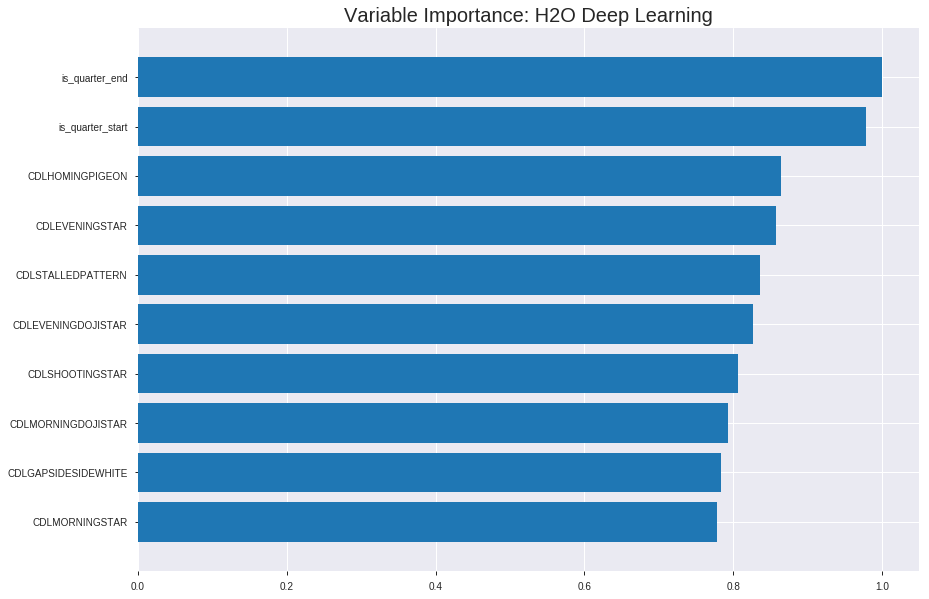

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_034118_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2536564513343447
RMSE: 0.5036431785841488
LogLoss: 0.7061440671269973
Mean Per-Class Error: 0.4366966632877667
AUC: 0.5847880477818242
pr_auc: 0.5775926252536023
Gini: 0.1695760955636485
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.054378777890208424: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      2    3031  0.9993   (3031.0/3033.0)
1      0    3062  0        (0.0/3062.0)
Total  2    6093  0.4973   (3031.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0543788    0.668924  397
max f2                       0.0543788    0.834742  397
max f0point5                 0.448707     0.572061  224
max accuracy                 0.448707     0.563577  224
max precision                0.868205     0.708333  9
max recall                   0.0543788    1         397
max specificity              0.925578     0.999341  0
max absolute_mcc             0.540862     0.129742  162
max min_per_class_accuracy   0.47867      0.558193  204
max mean_per_class_accuracy  0.498655     0.563303  190

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 48.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.837879           1.24      1.24               0.622951         0.865022  0.622951                    0.865022            0.0124102       0.0124102                  24.0002   24.0002
    2        0.0200164                   0.815144           1.53369   1.38684            0.770492         0.826533  0.696721                    0.845777            0.0153494       0.0277596                  53.3686   38.6844
    3        0.0300246                   0.794796           1.37053   1.38141            0.688525         0.80438   0.693989                    0.831978            0.0137165       0.0414762                  37.0528   38.1405
    4        0.0400328                   0.778542           1.24      1.34605            0.622951         0.785652  0.67623                     0.820397            0.0124102       0.0538863                  24.0002   34.6054
    5        0.050041                    0.767173           1.37053   1.35095            0.688525         0.773027  0.678689                    0.810923            0.0137165       0.0676029                  37.0528   35.0949
    6        0.100082                    0.713399           1.19432   1.27263            0.6              0.739029  0.639344                    0.774976            0.0597649       0.127368                   19.4317   27.2633
    7        0.150123                    0.670317           1.17474   1.24               0.590164         0.692575  0.622951                    0.747509            0.0587851       0.186153                   17.4738   24.0002
    8        0.2                         0.633485           1.12622   1.21163            0.565789         0.651837  0.608696                    0.72365             0.0561724       0.242325                   12.622    21.1626
    9        0.300082                    0.571183           1.13558   1.18626            0.570492         0.601331  0.595954                    0.682855            0.113651        0.355976                   13.5581   18.6264
    10       0.4                         0.52114            1.04593   1.15121            0.525452         0.545267  0.578343                    0.648486            0.104507        0.460483                   4.59266   15.1208
    11       0.500082                    0.478721           0.985475  1.11804            0.495082         0.500456  0.56168                     0.618861            0.0986283       0.559112                   -1.4525   11.804
    12       0.6                         0.438831           0.983825  1.09569            0.494253         0.45893   0.550451                    0.592227            0.0983018       0.657413                   -1.61753  9.56891
    13       0.699918                    0.392406           0.934797  1.07272            0.469622         0.415234  0.538912                    0.56696             0.093403        0.750816                   -6.52031  7.27207
    14       0.8                         0.336538           0.910422  1.05242            0.457377         0.365414  0.528712                    0.541746            0.0911169       0.841933                   -8.95777  5.24167
    15       0.899918                    0.265065           0.804056  1.02484            0.403941         0.302898  0.514859                    0.515227            0.0803396       0.922273                   -19.5944  2.48412
    16       1                           0.033966           0.776633  1                  0.390164         0.199292  0.502379                    0.483608          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26375279954733694
RMSE: 0.5135686901937626
LogLoss: 0.7299827878107574
Mean Per-Class Error: 0.4267000791347929
AUC: 0.5990292798733844
pr_auc: 0.5714127800192229
Gini: 0.19805855974676878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.297949201745489: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      28   864   0.9686   (864.0/892.0)
1      5    845   0.0059   (5.0/850.0)
Total  33   1709  0.4989   (869.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297949     0.660414  378
max f2                       0.25678      0.828622  387
max f0point5                 0.548213     0.569061  239
max accuracy                 0.734846     0.575201  108
max precision                0.926126     1         0
max recall                   0.25678      1         387
max specificity              0.926126     1         0
max absolute_mcc             0.734846     0.155181  108
max min_per_class_accuracy   0.632108     0.570588  180
max mean_per_class_accuracy  0.634778     0.5733    178

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 61.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.893968           1.36627   1.36627            0.666667         0.905687  0.666667                    0.905687            0.0141176       0.0141176                  36.6275   36.6275
    2        0.0200918                   0.87478            1.32609   1.34676            0.647059         0.881141  0.657143                    0.893764            0.0129412       0.0270588                  32.609    34.6756
    3        0.0304248                   0.864515           0.91085   1.19871            0.444444         0.869806  0.584906                    0.885628            0.00941176      0.0364706                  -8.91503  19.8713
    4        0.0401837                   0.854312           1.5672    1.2882             0.764706         0.859131  0.628571                    0.879193            0.0152941       0.0517647                  56.7197   28.8202
    5        0.0505166                   0.845984           1.70784   1.37404            0.833333         0.849955  0.670455                    0.873212            0.0176471       0.0694118                  70.7843   37.4037
    6        0.100459                    0.812866           1.20138   1.2882             0.586207         0.829103  0.628571                    0.851284            0.06            0.129412                   20.1379   28.8202
    7        0.150402                    0.784914           1.36627   1.31413            0.666667         0.797951  0.641221                    0.833574            0.0682353       0.197647                   36.6275   31.4127
    8        0.200344                    0.766022           1.17782   1.28015            0.574713         0.775703  0.624642                    0.819148            0.0588235       0.256471                   17.7823   28.0148
    9        0.30023                     0.726105           1.14249   1.23435            0.557471         0.747298  0.602294                    0.795244            0.114118        0.370588                   14.2488   23.4349
    10       0.400115                    0.680089           0.942258  1.16143            0.45977          0.704251  0.566714                    0.772528            0.0941176       0.464706                   -5.77417  16.1431
    11       0.5                         0.629697           1.09538   1.14824            0.534483         0.653707  0.560276                    0.748791            0.109412        0.574118                   9.53753   14.8235
    12       0.599885                    0.579993           0.859811  1.10021            0.41954          0.606046  0.536842                    0.725023            0.0858824       0.66                       -14.0189  10.0211
    13       0.69977                     0.524705           1.02471   1.08943            0.5              0.552429  0.531583                    0.700387            0.102353        0.762353                   2.47059   8.9433
    14       0.799656                    0.468419           0.895145  1.06516            0.436782         0.497417  0.519742                    0.675034            0.0894118       0.851765                   -10.4855  6.51645
    15       0.899541                    0.396422           0.80092   1.03582            0.390805         0.433424  0.505424                    0.648206            0.08            0.931765                   -19.908   3.58227
    16       1                           0.139204           0.679234  1                  0.331429         0.336387  0.487945                    0.616881          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 03:59:37  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 03:59:39  18 min 15.163 sec  401 obs/sec       0.157178  1             958        0.670754         3.33181             -0.799686      0.525121        0.377845           1.17474          0.497621                         0.715493           5.71084               -1.04891         0.536286          0.433142             1.02471            0.512055
    2019-07-25 04:00:24  18 min 59.976 sec  553 obs/sec       3.88302   25            23667      0.526556         0.797607            -0.109071      0.576844        0.558117           1.24             0.482527                         0.535967           0.801193              -0.149711        0.589142          0.571729             1.70784            0.506315
    2019-07-25 04:01:09  19 min 44.958 sec  580 obs/sec       7.92289   51            48290      0.503643         0.706144            -0.0146488     0.584788        0.577593           1.24             0.497293                         0.513569           0.729983              -0.0556248       0.599029          0.571413             1.36627            0.498852

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
is_quarter_end            1.0                    1.0                  0.0034690213589888192
is_quarter_start          0.9789031744003296     0.9789031744003296   0.0033958360203767
CDLHOMINGPIGEON           0.8637937903404236     0.8637937903404236   0.002996519108452839
CDLEVENINGSTAR            0.8571317791938782     0.8571317791938782   0.0029734084494916517
CDLSTALLEDPATTERN         0.8357986807823181     0.8357986807823181   0.0028994034754485395
---                       ---                    ---                  ---
MA_8_3                    0.218926340341568      0.218926340341568    0.0007594601506901549
BBANDS_middleband_14_1_3  0.21817825734615326    0.21817825734615326  0.0007568650348007648
MAX_12                    0.21804435551166534    0.21804435551166534  0.0007564005264769185
BBANDS_upperband_14_5_3   0.21758154034614563    0.21758154034614563  0.0007547950107824667
MA_12_7                   0.2173967957496643     0.2173967957496643   0.0007541541278313152


See the whole table with table.as_data_frame()


('accuracy', 0.5866819747416763)

('F1', 0.6687647521636507)

('auc', 0.6013377415000423)

('logloss', 0.723029324401565)

('mean_per_class_error', 0.41375073820973585)

('rmse', 0.5109145120999383)

('mse', 0.26103363867431806)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


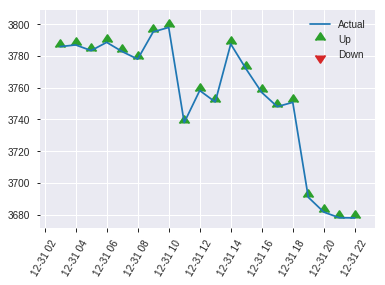


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26103363867431806
RMSE: 0.5109145120999383
LogLoss: 0.723029324401565
Mean Per-Class Error: 0.41375073820973585
AUC: 0.6013377415000423
pr_auc: 0.5873499997193957
Gini: 0.20267548300008453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3311058971192295: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   414  0.9431   (414.0/439.0)
1      7    425  0.0162   (7.0/432.0)
Total  32   839  0.4834   (421.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331106     0.668765  376
max f2                       0.260184     0.831729  397
max f0point5                 0.59133      0.586066  213
max accuracy                 0.659402     0.586682  163
max precision                0.969798     1         0
max recall                   0.260184     1         397
max specificity              0.969798     1         0
max absolute_mcc             0.659402     0.173528  163
max min_per_class_accuracy   0.633315     0.581019  183
max mean_per_class_accuracy  0.659402     0.586249  163

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 61.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.894771           1.79218   1.79218            0.888889         0.92589   0.888889                    0.92589             0.0185185       0.0185185                  79.2181   79.2181
    2        0.0206659                   0.875302           1.56816   1.68017            0.777778         0.884662  0.833333                    0.905276            0.0162037       0.0347222                  56.8158   68.017
    3        0.0309989                   0.857436           0.896091  1.41881            0.444444         0.864654  0.703704                    0.891735            0.00925926      0.0439815                  -10.3909  41.881
    4        0.0401837                   0.849523           0.504051  1.20972            0.25             0.852835  0.6                         0.882844            0.00462963      0.0486111                  -49.5949  20.9722
    5        0.0505166                   0.841546           1.56816   1.28304            0.777778         0.84521   0.636364                    0.875146            0.0162037       0.0648148                  56.8158   28.3039
    6        0.101033                    0.809131           1.28304   1.28304            0.636364         0.822628  0.636364                    0.848887            0.0648148       0.12963                    28.3039   28.3039
    7        0.150402                    0.786664           1.35977   1.30822            0.674419         0.79937   0.648855                    0.832634            0.0671296       0.196759                   35.9765   30.8224
    8        0.200918                    0.764349           1.23722   1.29037            0.613636         0.773468  0.64                        0.817758            0.0625          0.259259                   23.7216   29.037
    9        0.300804                    0.722905           0.97334   1.1851             0.482759         0.742649  0.587786                    0.792817            0.0972222       0.356481                   -2.66603  18.5097
    10       0.400689                    0.674546           1.20509   1.19008            0.597701         0.698067  0.590258                    0.769197            0.12037         0.476852                   20.5087   19.008
    11       0.500574                    0.631905           1.06604   1.16533            0.528736         0.653926  0.577982                    0.746196            0.106481        0.583333                   6.60387   16.5329
    12       0.600459                    0.57864            0.903815  1.12183            0.448276         0.604877  0.556405                    0.722688            0.0902778       0.673611                   -9.61845  12.1827
    13       0.700344                    0.528771           0.880641  1.08743            0.436782         0.554952  0.539344                    0.698765            0.087963        0.761574                   -11.9359  8.74279
    14       0.80023                     0.463649           0.811116  1.05294            0.402299         0.495448  0.522238                    0.673387            0.0810185       0.842593                   -18.8884  5.29385
    15       0.900115                    0.393119           0.857466  1.03125            0.425287         0.431494  0.51148                     0.646544            0.0856481       0.928241                   -14.2534  3.1247
    16       1                           0.186171           0.718417  1                  0.356322         0.339297  0.495982                    0.615855            0.

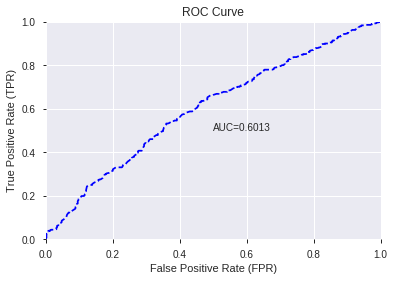

This function is available for GLM models only


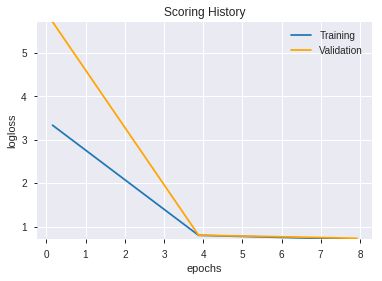

--2019-07-25 04:39:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.33.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.33.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


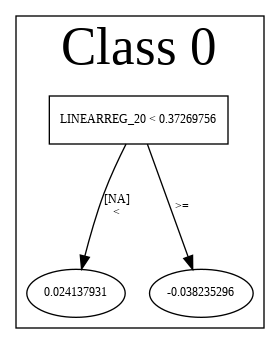

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_034118_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_034118_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_043918_model_6  0.592332  0.684922              0.466311  0.495428  0.245449
1  DeepLearning_grid_1_AutoML_20190725_043918_model_7  0.591984  0.719005              0.467266  0.506854  0.256901
2  DeepLearning_grid_1_AutoML_20190725_043918_model_9  0.590180  0.681463              0.483119  0.494160  0.244194
3  DeepLearning_grid_1_AutoML_20190725_043918_model_4  0.588693  0.708012              0.470646  0.504617  0.254638
4  DeepLearning_grid_1_AutoML_20190725_043918_model_5  0.586220  0.688924              0.478581  0.497809  0.247814
5  DeepLearning_grid_1_AutoML_20190725_043918_model_3  0.580088  0.723050              0.500000  0.507081  0.257131
6               DeepLearning_1_AutoML_20190725_043918  0.576716  0.708200              0.497722  0.505209  0.255236
7  DeepLearning_grid_1_AutoML_20190725_043918_model_2  0.573135  0.759657              0.500000  0.516353  0.266620
8  DeepLearning_grid_1_AutoML_20190725_043918_model_8  0.571915  0.687586              0.500000  0.496898  0.246907
9  DeepLearning_grid_1_AutoML_20190725_043918_model_1  0.562226  0.867543              0.500000  0.532220  0.283258

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.043080
1          HT_TRENDMODE             0.687723           0.687723    0.029627
2          STOCHF_fastk             0.660961           0.660961    0.028474
3                SAREXT             0.586915           0.586915    0.025284
4    LINEARREG_ANGLE_20             0.557549           0.557549    0.024019
5        STOCHRSI_fastd             0.551254           0.551254    0.023748
6        STOCHRSI_fastk             0.550098           0.550098    0.023698
7                   SIN             0.537031           0.537031    0.023135
8             dayofyear             0.525707           0.525707    0.022648
9    LINEARREG_ANGLE_14             0.514169           0.514169    0.022150
10        days_in_month             0.508562           0.508562    0.021909
11                  COS             0.503012           0.503012    0.021670
12            CORREL_30             0.486317           0.486317    0.020951
13     is_quarter_start             0.483294           0.483294    0.020820
14             CORREL_8             0.470028           0.470028    0.020249
15            CORREL_24             0.469072           0.469072    0.020208
16       is_quarter_end             0.467180           0.467180    0.020126
17            CORREL_14             0.466414           0.466414    0.020093
18        CDLHANGINGMAN             0.462891           0.462891    0.019941
19       CDLMORNINGSTAR             0.452715           0.452715    0.019503
20         is_month_end             0.451161           0.451161    0.019436
21            CORREL_20             0.441548           0.441548    0.019022
22       CDLEVENINGSTAR             0.441338           0.441338    0.019013
23            CORREL_12             0.435016           0.435016    0.018741
24    CDLGRAVESTONEDOJI             0.431958           0.431958    0.018609
25   CDLMORNINGDOJISTAR             0.431820           0.431820    0.018603
26   CDLEVENINGDOJISTAR             0.429057           0.429057    0.018484
27  CDLGAPSIDESIDEWHITE             0.427546           0.427546    0.018419
28      CDLHOMINGPIGEON             0.426888           0.426888    0.018390
29      CDLUNIQUE3RIVER             0.425070           0.425070    0.018312
30    CDLINVERTEDHAMMER             0.417737           0.417737    0.017996
31         CDLTHRUSTING             0.414936           0.414936    0.017875
32      CDLADVANCEBLOCK             0.412297           0.412297    0.017762
33    CDLSTALLEDPATTERN             0.411682           0.411682    0.017735
34    CDLDARKCLOUDCOVER             0.410538           0.410538    0.017686
35         CDLTASUKIGAP             0.409552           0.409552    0.017644
36       is_month_start             0.408961           0.408961    0.017618
37      CDLSHOOTINGSTAR             0.406354           0.406354    0.017506
38            CDLTAKURI             0.403765           0.403765    0.017394
39     CDLSTICKSANDWICH             0.402648           0.402648    0.017346
40            CDL2CROWS             0.402023           0.402023    0.017319
41   CDLIDENTICAL3CROWS             0.396284           0.396284    0.017072
42          CDLPIERCING             0.389907           0.389907    0.016797
43            CDLHAMMER             0.389057           0.389057    0.016761
44       CDLMATCHINGLOW             0.388838           0.388838    0.016751
45         CDLBREAKAWAY             0.382140           0.382140    0.016463
46  CDLRISEFALL3METHODS             0.381465           0.381465    0.016434
47      CDLLADDERBOTTOM             0.370793           0.370793    0.015974
48    CDL3WHITESOLDIERS             0.368121           0.368121    0.015859
49     CDLDRAGONFLYDOJI             0.363198           0.363198    0.015647

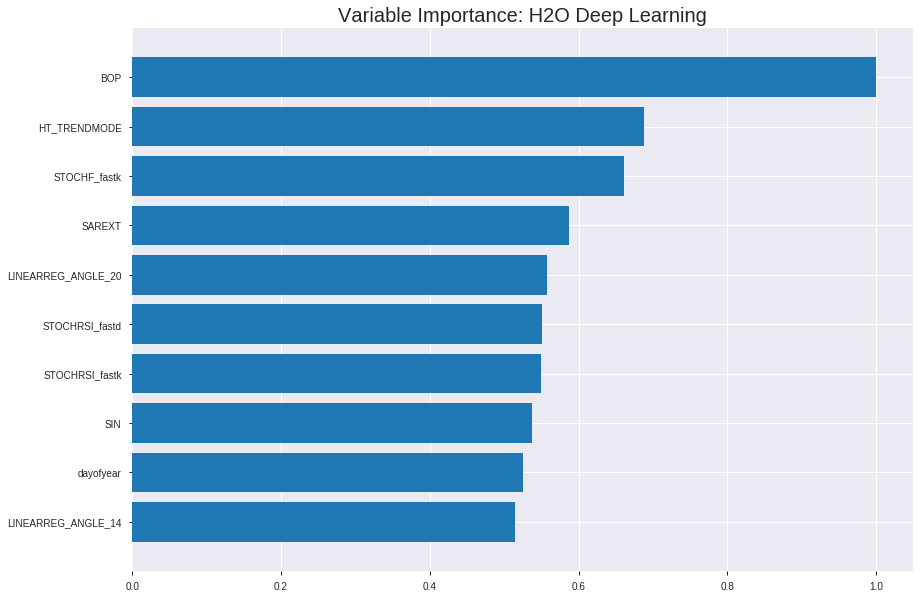

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_043918_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24357593715605297
RMSE: 0.4935341296770194
LogLoss: 0.6799265177687711
Mean Per-Class Error: 0.4339353977572632
AUC: 0.5920664116447792
pr_auc: 0.5845398970070462
Gini: 0.1841328232895585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34665886045687316: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      282  2751  0.907    (2751.0/3033.0)
1      99   2963  0.0323   (99.0/3062.0)
Total  381  5714  0.4676   (2850.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346659     0.675251  317
max f2                       0.157868     0.835061  389
max f0point5                 0.417638     0.57682   252
max accuracy                 0.484767     0.566038  172
max precision                0.74744      1         0
max recall                   0.131411     1         395
max specificity              0.74744      1         0
max absolute_mcc             0.484767     0.132135  172
max min_per_class_accuracy   0.484311     0.563031  173
max mean_per_class_accuracy  0.484767     0.566065  172

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 47.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.655871           1.46842   1.46842            0.737705         0.679448  0.737705                    0.679448            0.0146963       0.0146963                  46.8423   46.8423
    2        0.0200164                   0.627911           1.37053   1.41948            0.688525         0.643445  0.713115                    0.661447            0.0137165       0.0284128                  37.0528   41.9476
    3        0.0300246                   0.610897           1.30526   1.38141            0.655738         0.619606  0.693989                    0.6475              0.0130634       0.0414762                  30.5265   38.1405
    4        0.0400328                   0.599267           1.3379    1.37053            0.672131         0.604992  0.688525                    0.636873            0.0133899       0.0548661                  33.7897   37.0528
    5        0.050041                    0.590669           1.20737   1.3379             0.606557         0.594547  0.672131                    0.628408            0.0120836       0.0669497                  20.737    33.7897
    6        0.100082                    0.555782           1.27263   1.30526            0.639344         0.572379  0.655738                    0.600393            0.0636839       0.130634                   27.2633   30.5265
    7        0.150123                    0.535038           1.2139    1.27481            0.609836         0.543317  0.640437                    0.581368            0.0607446       0.191378                   21.3896   27.4809
    8        0.2                         0.523211           1.09348   1.22959            0.549342         0.529058  0.617719                    0.568323            0.0545395       0.245918                   9.34814   22.9589
    9        0.300082                    0.504675           1.05074   1.16994            0.527869         0.513779  0.587753                    0.550131            0.10516         0.351078                   5.07383   16.9939
    10       0.4                         0.490482           1.05246   1.14059            0.528736         0.497003  0.573011                    0.53686             0.10516         0.456238                   5.24636   14.0594
    11       0.500082                    0.483988           1.07684   1.12784            0.540984         0.487055  0.566601                    0.526893            0.107773        0.56401                    7.68436   12.7836
    12       0.6                         0.468205           0.967482  1.10113            0.486043         0.47679   0.553186                    0.518549            0.0966688       0.660679                   -3.25179  10.1132
    13       0.699918                    0.445349           0.947871  1.07925            0.47619          0.457913  0.542194                    0.509893            0.0947093       0.755389                   -5.2129   7.92531
    14       0.8                         0.415682           0.933264  1.06099            0.468852         0.431143  0.533019                    0.500041            0.093403        0.848792                   -6.67356  6.09895
    15       0.899918                    0.372746           0.866158  1.03936            0.43514          0.395777  0.522151                    0.488465            0.0865447       0.935336                   -13.3842  3.93574
    16       1                           0.0951787          0.646106  1                  0.32459          0.316552  0.502379                    0.471259         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24410519559654226
RMSE: 0.4940700310649719
LogLoss: 0.6815682440020517
Mean Per-Class Error: 0.42272223687681354
AUC: 0.5931291216037985
pr_auc: 0.5609194853938684
Gini: 0.18625824320759699
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29885381747708034: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      41   851   0.954    (851.0/892.0)
1      15   835   0.0176   (15.0/850.0)
Total  56   1686  0.4971   (866.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298854     0.658517  366
max f2                       0.16329      0.82717   396
max f0point5                 0.473023     0.567773  222
max accuracy                 0.522049     0.579793  163
max precision                0.675032     0.637681  29
max recall                   0.16329      1         396
max specificity              0.75415      0.998879  0
max absolute_mcc             0.522049     0.158118  163
max min_per_class_accuracy   0.493224     0.566143  197
max mean_per_class_accuracy  0.522049     0.577278  163

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 49.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.702378           1.13856   1.13856            0.555556         0.720414  0.555556                    0.720414            0.0117647       0.0117647                  13.8562   13.8562
    2        0.0200918                   0.689616           1.20554   1.17109            0.588235         0.696612  0.571429                    0.708853            0.0117647       0.0235294                  20.5536   17.1092
    3        0.0304248                   0.682644           1.13856   1.16004            0.555556         0.687164  0.566038                    0.701487            0.0117647       0.0352941                  13.8562   16.0044
    4        0.0401837                   0.673408           1.8083    1.31748            0.882353         0.678035  0.642857                    0.695791            0.0176471       0.0529412                  80.8304   31.7479
    5        0.0505166                   0.667015           1.13856   1.28088            0.555556         0.669355  0.625                       0.690384            0.0117647       0.0647059                  13.8562   28.0882
    6        0.100459                    0.642748           1.17782   1.22965            0.574713         0.653965  0.6                         0.672279            0.0588235       0.123529                   17.7823   22.9647
    7        0.150402                    0.611949           1.36627   1.27502            0.666667         0.627217  0.622137                    0.657316            0.0682353       0.191765                   36.6275   27.5016
    8        0.200344                    0.585354           1.0836    1.2273             0.528736         0.598729  0.598854                    0.642711            0.0541176       0.245882                   8.3597    22.7298
    9        0.30023                     0.549833           1.14249   1.19908            0.557471         0.567029  0.585086                    0.617532            0.114118        0.36                       14.2488   19.9082
    10       0.400115                    0.519284           1.1896    1.19672            0.58046          0.533311  0.583931                    0.596507            0.118824        0.478824                   18.9601   19.6715
    11       0.5                         0.492417           0.883367  1.13412            0.431034         0.505564  0.553387                    0.578339            0.0882353       0.567059                   -11.6633  13.4118
    12       0.599885                    0.4718             1.03648   1.11786            0.505747         0.482373  0.545455                    0.56236             0.103529        0.670588                   3.64841   11.7861
    13       0.69977                     0.44704            0.812698  1.0743             0.396552         0.4602    0.5242                      0.547778            0.0811765       0.751765                   -18.7302  7.4302
    14       0.799656                    0.408217           0.942258  1.05781            0.45977          0.429161  0.516152                    0.532961            0.0941176       0.845882                   -5.77417  5.78084
    15       0.899541                    0.361931           0.812698  1.03059            0.396552         0.388311  0.502872                    0.516899            0.0811765       0.927059                   -18.7302  3.05912
    16       1                           0.140024           0.726077  1                  0.354286         0.309666  0.487945                    0.496081          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:47:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:47:59  5 min 47.591 sec  883 obs/sec       0.397867  1             2425       0.54018          0.801188            -0.167204      0.509393        0.509948           0.848422         0.497457                         0.53636            0.784439              -0.151399        0.522859          0.513325             1.59399            0.512055
    2019-07-25 04:48:21  6 min 10.221 sec  2790 obs/sec      10.6021   27            64620      0.493534         0.679927            0.0256742      0.592066        0.58454            1.46842          0.467596                         0.49407            0.681568              0.0230113        0.593129          0.560919             1.13856            0.49713
    2019-07-25 04:48:44  6 min 32.887 sec  3137 obs/sec      22.3998   57            136527     0.489849         0.672394            0.0401709      0.608634        0.606746           1.66421          0.457752                         0.496194           0.687272              0.0145947        0.595003          0.562686             0.796993           0.510333
    2019-07-25 04:49:07  6 min 56.177 sec  3343 obs/sec      35.4271   90            215928     0.488274         0.669115            0.0463322      0.63098         0.626676           1.89263          0.44758                          0.497112           0.687402              0.0109427        0.588104          0.559706             1.25242            0.509185
    2019-07-25 04:49:30  7 min 18.798 sec  3470 obs/sec      48.3757   123           294850     0.485497         0.663272            0.0571504      0.639789        0.631508           1.82737          0.440361                         0.498138           0.690961              0.0068564        0.585348          0.560659             1.36627            0.509185
    2019-07-25 04:49:53  7 min 41.472 sec  3550 obs/sec      61.3754   156           374083     0.481715         0.655143            0.071783       0.656098        0.653205           1.79474          0.418868                         0.500173           0.696369              -0.00127322      0.582924          0.549787             1.02471            0.510333
    2019-07-25 04:50:15  8 min  4.335 sec  3614 obs/sec      74.7273   190           455463     0.479098         0.649692            0.0818389      0.662568        0.663079           1.82737          0.439212                         0.506009           0.712222              -0.0247774       0.575777          0.542698             1.25242            0.512055
    2019-07-25 04:50:18  8 min  6.715 sec  3614 obs/sec      74.7273   190           455463     0.493534         0.679927            0.0256742      0.592066        0.58454            1.46842          0.467596                         0.49407            0.681568              0.0230113        0.593129          0.560919             1.13856            0.49713

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.04308006834500527
HT_TRENDMODE         0.6877231001853943     0.6877231001853943   0.02962715815842569
STOCHF_fastk         0.6609611511230469     0.6609611511230469   0.028474251563774214
SAREXT               0.586914598941803      0.586914598941803    0.025284321035094228
LINEARREG_ANGLE_20   0.5575488805770874     0.5575488805770874   0.024019243880942107
---                  ---                    ---                  ---
CDLBREAKAWAY         0.38213998079299927    0.38213998079299927  0.01646261648992141
CDLRISEFALL3METHODS  0.38146474957466125    0.38146474957466125  0.016433527482886727
CDLLADDERBOTTOM      0.37079334259033203    0.37079334259033203  0.015973802540664456
CDL3WHITESOLDIERS    0.3681214153766632     0.3681214153766632   0.015858695733686725
CDLDRAGONFLYDOJI     0.3631976246833801     0.3631976246833801   0.01564657849410359


See the whole table with table.as_data_frame()


('accuracy', 0.5763490241102182)

('F1', 0.665028665028665)

('auc', 0.5923315827216739)

('logloss', 0.6849223003692528)

('mean_per_class_error', 0.4246472412047583)

('rmse', 0.4954278006003393)

('mse', 0.24544870560768955)

deeplearning prediction progress: |███████████████████████████████████████| 100%


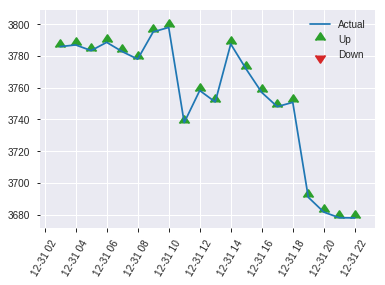


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24544870560768955
RMSE: 0.4954278006003393
LogLoss: 0.6849223003692528
Mean Per-Class Error: 0.4246472412047583
AUC: 0.5923315827216739
pr_auc: 0.5647439273752739
Gini: 0.1846631654433477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34589295290532884: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   383  0.8724   (383.0/439.0)
1      26   406  0.0602   (26.0/432.0)
Total  82   789  0.4696   (409.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345893     0.665029  345
max f2                       0.136228     0.831089  399
max f0point5                 0.427385     0.577717  267
max accuracy                 0.541746     0.576349  148
max precision                0.769312     1         0
max recall                   0.136228     1         399
max specificity              0.769312     1         0
max absolute_mcc             0.554508     0.157201  136
max min_per_class_accuracy   0.494086     0.564815  197
max mean_per_class_accuracy  0.532846     0.575353  157

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.723316           1.12011   1.12011            0.555556         0.737834  0.555556                    0.737834            0.0115741       0.0115741                  12.0113   12.0113
    2        0.0206659                   0.708248           1.34414   1.23212            0.666667         0.715614  0.611111                    0.726724            0.0138889       0.025463                   34.4136   23.2124
    3        0.0309989                   0.69685            1.34414   1.26946            0.666667         0.70374   0.62963                     0.719063            0.0138889       0.0393519                  34.4136   26.9462
    4        0.0401837                   0.691264           0.504051  1.09451            0.25             0.694434  0.542857                    0.713433            0.00462963      0.0439815                  -49.5949  9.45106
    5        0.0505166                   0.682451           1.12011   1.09975            0.555556         0.686543  0.545455                    0.707933            0.0115741       0.0555556                  12.0113   9.97475
    6        0.101033                    0.649075           1.28304   1.19139            0.636364         0.663574  0.590909                    0.685753            0.0648148       0.12037                    28.3039   19.1393
    7        0.150402                    0.61583            1.2191    1.20049            0.604651         0.633937  0.59542                     0.668745            0.0601852       0.180556                   21.91     20.0488
    8        0.200918                    0.597282           1.14557   1.18668            0.568182         0.604618  0.588571                    0.652622            0.0578704       0.238426                   14.557    18.668
    9        0.300804                    0.566199           1.25144   1.20818            0.62069          0.581594  0.599237                    0.629036            0.125           0.363426                   25.1437   20.8183
    10       0.400689                    0.527143           1.04286   1.16697            0.517241         0.544413  0.578797                    0.607941            0.104167        0.467593                   4.2864    16.6972
    11       0.500574                    0.492572           0.97334   1.12833            0.482759         0.509852  0.559633                    0.588368            0.0972222       0.564815                   -2.66603  12.8334
    12       0.600459                    0.468191           1.06604   1.11797            0.528736         0.479792  0.554493                    0.570307            0.106481        0.671296                   6.60387   11.7971
    13       0.700344                    0.430041           0.950165  1.09404            0.471264         0.447764  0.542623                    0.552829            0.0949074       0.766204                   -4.9835   9.40384
    14       0.80023                     0.393486           0.811116  1.05872            0.402299         0.411418  0.525108                    0.535178            0.0810185       0.847222                   -18.8884  5.87239
    15       0.900115                    0.34912            0.834291  1.03382            0.413793         0.370658  0.512755                    0.516921            0.0833333       0.930556                   -16.5709  3.38187
    16       1                           0.136228           0.695243  1                  0.344828         0.300212  0.495982                    0.495275          

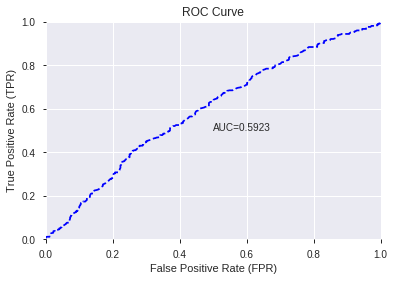

This function is available for GLM models only


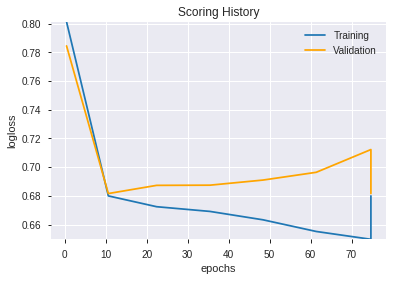

--2019-07-25 05:07:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


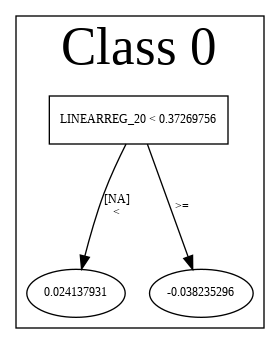

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_043918_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_043918_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'SAREXT',
 'LINEARREG_ANGLE_20',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'SIN',
 'dayofyear',
 'LINEARREG_ANGLE_14',
 'days_in_month',
 'COS',
 'CORREL_30',
 'is_quarter_start',
 'CORREL_8',
 'CORREL_24',
 'is_quarter_end',
 'CORREL_14',
 'CDLHANGINGMAN',
 'CDLMORNINGSTAR',
 'is_month_end',
 'CORREL_20',
 'CDLEVENINGSTAR',
 'CORREL_12',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLHOMINGPIGEON',
 'CDLUNIQUE3RIVER',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'CDLSTALLEDPATTERN',
 'CDLDARKCLOUDCOVER',
 'CDLTASUKIGAP',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI',
 'CDLSTICKSANDWICH',
 'CDL2CROWS',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDLHAMMER',
 'CDLMATCHINGLOW',
 'CDLBREAKAWAY',
 'CDLRISEFALL3METHODS',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'CDLDRAGONFLYDOJI']

In [0]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_050757_model_1  0.592854  0.680196              0.476359  0.493617  0.243658

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.168925           1.000000    0.161481
1    LINEARREG_ANGLE_20             0.067090           0.397161    0.064134
2          STOCHF_fastk             0.052003           0.307848    0.049711
3         CDLHANGINGMAN             0.050355           0.298090    0.048136
4        STOCHRSI_fastd             0.049700           0.294213    0.047510
5     CDLGRAVESTONEDOJI             0.042070           0.249044    0.040216
6        STOCHRSI_fastk             0.041322           0.244615    0.039501
7           CDLPIERCING             0.039360           0.233004    0.037626
8          HT_TRENDMODE             0.033416           0.197817    0.031944
9    CDLIDENTICAL3CROWS             0.033391           0.197668    0.031919
10       CDLMATCHINGLOW             0.031558           0.186815    0.030167
11    CDL3WHITESOLDIERS             0.027950           0.165456    0.026718
12            CORREL_14             0.027667           0.163785    0.026448
13   LINEARREG_ANGLE_14             0.027650           0.163684    0.026432
14      CDLLADDERBOTTOM             0.026383           0.156181    0.025220
15         CDLBREAKAWAY             0.023745           0.140567    0.022699
16            CORREL_30             0.023512           0.139185    0.022476
17            CORREL_12             0.018650           0.110404    0.017828
18   CDLEVENINGDOJISTAR             0.018334           0.108536    0.017526
19     CDLSTICKSANDWICH             0.017348           0.102700    0.016584
20            CORREL_20             0.016259           0.096252    0.015543
21    CDLSTALLEDPATTERN             0.015209           0.090036    0.014539
22            dayofyear             0.014867           0.088009    0.014212
23    CDLINVERTEDHAMMER             0.014360           0.085011    0.013728
24        days_in_month             0.013050           0.077256    0.012475
25                  COS             0.013007           0.077000    0.012434
26       CDLEVENINGSTAR             0.011966           0.070834    0.011438
27            CDL2CROWS             0.011700           0.069260    0.011184
28            CORREL_24             0.010532           0.062350    0.010068
29      CDLSHOOTINGSTAR             0.010428           0.061729    0.009968
30               SAREXT             0.008794           0.052059    0.008406
31                  SIN             0.008642           0.051157    0.008261
32             CORREL_8             0.008551           0.050620    0.008174
33            CDLHAMMER             0.007967           0.047161    0.007616
34         CDLTASUKIGAP             0.007065           0.041825    0.006754
35      CDLHOMINGPIGEON             0.006165           0.036495    0.005893
36     CDLDRAGONFLYDOJI             0.006041           0.035762    0.005775
37            CDLTAKURI             0.005715           0.033833    0.005463
38       is_quarter_end             0.005228           0.030946    0.004997
39  CDLRISEFALL3METHODS             0.005056           0.029930    0.004833
40   CDLMORNINGDOJISTAR             0.004864           0.028795    0.004650
41     is_quarter_start             0.003749           0.022194    0.003584
42  CDLGAPSIDESIDEWHITE             0.003744           0.022165    0.003579
43         is_month_end             0.003466           0.020518    0.003313
44    CDLDARKCLOUDCOVER             0.003203           0.018962    0.003062
45       is_month_start             0.001635           0.009681    0.001563
46      CDLADVANCEBLOCK             0.001603           0.009488    0.001532
47       CDLMORNINGSTAR             0.001201           0.007109    0.001148
48         CDLTHRUSTING             0.000802           0.004746    0.000766
49      CDLUNIQUE3RIVER             0.000801           0.004742    0.000766

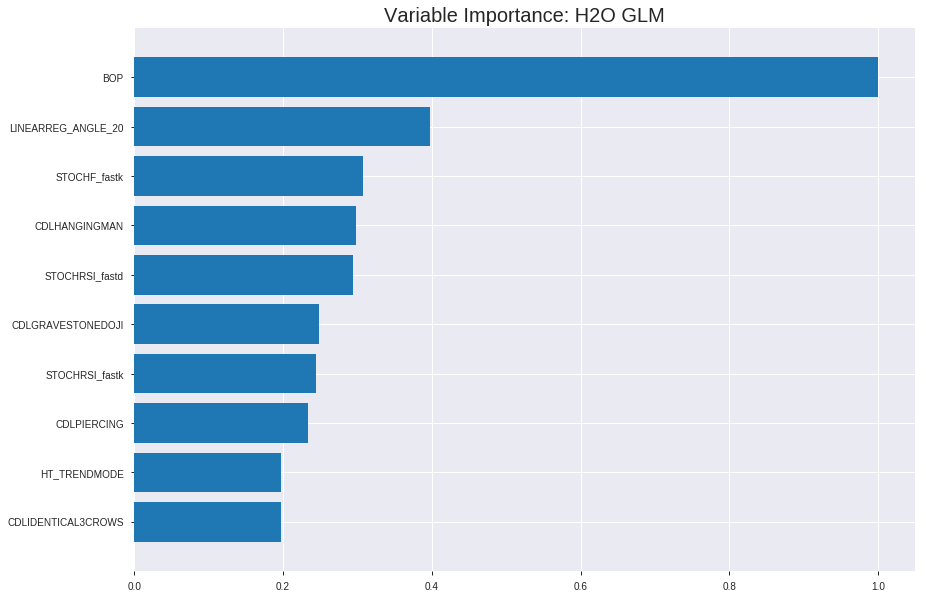

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_050757_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24329784644081273
RMSE: 0.4932523151905247
LogLoss: 0.6795076731624822
Null degrees of freedom: 6094
Residual degrees of freedom: 6044
Null deviance: 8449.32614855268
Residual deviance: 8283.198535850657
AIC: 8385.198535850657
AUC: 0.5936162586036507
pr_auc: 0.5765752252792248
Gini: 0.1872325172073015
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3721338425143432: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      93   2940  0.9693   (2940.0/3033.0)
1      29   3033  0.0095   (29.0/3062.0)
Total  122  5973  0.4871   (2969.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372134     0.671389  366
max f2                       0.330757     0.834879  388
max f0point5                 0.46198      0.579073  258
max accuracy                 0.502855     0.569975  200
max precision                0.897357     1         0
max recall                   0.302739     1         396
max specificity              0.897357     1         0
max absolute_mcc             0.502855     0.139999  200
max min_per_class_accuracy   0.501689     0.567095  202
max mean_per_class_accuracy  0.502855     0.569998  200

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.643719           1.27263   1.27263            0.639344         0.681325  0.639344                    0.681325            0.0127368       0.0127368                  27.2633   27.2633
    2        0.0200164                   0.631501           1.17474   1.22369            0.590164         0.636631  0.614754                    0.658978            0.011757        0.0244938                  17.4738   22.3686
    3        0.0300246                   0.622539           1.20737   1.21825            0.606557         0.626622  0.612022                    0.648192            0.0120836       0.0365774                  20.737    21.8247
    4        0.0400328                   0.617085           1.27263   1.23184            0.639344         0.619617  0.618852                    0.641049            0.0127368       0.0493142                  27.2633   23.1844
    5        0.050041                    0.612378           1.17474   1.22042            0.590164         0.614608  0.613115                    0.63576             0.011757        0.0610712                  17.4738   22.0423
    6        0.100082                    0.596779           1.20084   1.21063            0.603279         0.604478  0.608197                    0.620119            0.0600914       0.121163                   20.0844   21.0633
    7        0.150123                    0.582747           1.27916   1.23348            0.642623         0.589744  0.619672                    0.609994            0.0640105       0.185173                   27.916    23.3475
    8        0.2                         0.569975           1.21134   1.22796            0.608553         0.576341  0.616899                    0.601601            0.060418        0.245591                   21.1342   22.7956
    9        0.300082                    0.54695            1.09642   1.18409            0.55082          0.558137  0.594861                    0.587105            0.109732        0.355323                   9.64226   18.4087
    10       0.4                         0.524353           1.08842   1.16019            0.546798         0.535944  0.582855                    0.574326            0.108752        0.464076                   8.84174   16.0189
    11       0.500082                    0.501739           1.04421   1.13698            0.52459          0.513066  0.571194                    0.562066            0.104507        0.568583                   4.4212    13.6979
    12       0.6                         0.479963           0.941334  1.1044             0.472906         0.490638  0.554826                    0.550171            0.0940562       0.662639                   -5.86661  10.4398
    13       0.699918                    0.457874           0.974019  1.08579            0.489327         0.468829  0.545476                    0.538559            0.097322        0.759961                   -2.59809  8.57855
    14       0.8                         0.435285           0.903896  1.06303            0.454098         0.446957  0.534044                    0.527099            0.0904637       0.850425                   -9.6104   6.30307
    15       0.899918                    0.408121           0.797519  1.03355            0.400657         0.421843  0.519234                    0.515412            0.0796865       0.930111                   -20.2481  3.35509
    16       1                           0.106995           0.698317  1                  0.35082          0.385185  0.502379                    0.502379         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24296453952698366
RMSE: 0.49291433284799463
LogLoss: 0.6787138855161242
Null degrees of freedom: 1741
Residual degrees of freedom: 1691
Null deviance: 2415.3638887467546
Residual deviance: 2364.639177138177
AIC: 2466.639177138177
AUC: 0.5979972302822474
pr_auc: 0.5917864168450272
Gini: 0.19599446056449477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4004943922307882: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   832   0.9327   (832.0/892.0)
1      25   825   0.0294   (25.0/850.0)
Total  85   1657  0.492    (857.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400494     0.658157  361
max f2                       0.334006     0.826848  397
max f0point5                 0.491544     0.564191  230
max accuracy                 0.561449     0.579793  126
max precision                0.905944     1         0
max recall                   0.334006     1         397
max specificity              0.905944     1         0
max absolute_mcc             0.581633     0.166675  95
max min_per_class_accuracy   0.510549     0.565022  200
max mean_per_class_accuracy  0.561449     0.574757  126

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.647382           1.48013   1.48013            0.722222         0.708079  0.722222                    0.708079            0.0152941       0.0152941                  48.0131   48.0131
    2        0.0200918                   0.633379           1.68775   1.58097            0.823529         0.640097  0.771429                    0.67506             0.0164706       0.0317647                  68.7751   58.0975
    3        0.0304248                   0.627929           1.36627   1.50806            0.666667         0.630333  0.735849                    0.659869            0.0141176       0.0458824                  36.6275   50.8058
    4        0.0401837                   0.622425           1.68775   1.5517             0.823529         0.625122  0.757143                    0.651431            0.0164706       0.0623529                  68.7751   55.1697
    5        0.0505166                   0.618719           1.48013   1.53706            0.722222         0.620532  0.75                        0.64511             0.0152941       0.0776471                  48.0131   53.7059
    6        0.100459                    0.603484           1.22494   1.38189            0.597701         0.610112  0.674286                    0.627711            0.0611765       0.138824                   22.4936   38.1889
    7        0.150402                    0.590969           1.38983   1.38453            0.678161         0.596824  0.675573                    0.617455            0.0694118       0.208235                   38.9831   38.4526
    8        0.200344                    0.5786             1.10715   1.31538            0.54023          0.584792  0.641834                    0.609313            0.0552941       0.263529                   10.7153   31.5382
    9        0.30023                     0.558546           1.07182   1.23435            0.522989         0.568371  0.602294                    0.595692            0.107059        0.370588                   7.18188   23.4349
    10       0.400115                    0.534712           0.989371  1.17319            0.482759         0.547487  0.572453                    0.583658            0.0988235       0.469412                   -1.06288  17.3193
    11       0.5                         0.510228           0.989371  1.13647            0.482759         0.52221   0.554535                    0.571382            0.0988235       0.568235                   -1.06288  13.6471
    12       0.599885                    0.487283           0.965815  1.10806            0.471264         0.499875  0.54067                     0.559476            0.0964706       0.664706                   -3.41853  10.8055
    13       0.69977                     0.464478           0.871589  1.0743             0.425287         0.476063  0.5242                      0.547569            0.0870588       0.751765                   -12.8411  7.4302
    14       0.799656                    0.445104           0.906924  1.05339            0.442529         0.455192  0.513999                    0.536031            0.0905882       0.842353                   -9.30764  5.33947
    15       0.899541                    0.418526           0.848032  1.03059            0.413793         0.431266  0.502872                    0.524397            0.0847059       0.927059                   -15.1968  3.05912
    16       1                           0.298785           0.726077  1                  0.354286         0.395955  0.487945                    0.511494          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:07:58  0.000 sec   2            6.8       48            1.38235           1.38205
    2019-07-25 05:07:58  0.064 sec   4            4.2       50            1.38044           1.37984
    2019-07-25 05:07:58  0.113 sec   6            2.6       50            1.37791           1.3769
    2019-07-25 05:07:58  0.158 sec   8            1.6       50            1.37485           1.37331
    2019-07-25 05:07:58  0.201 sec   10           1         51            1.37151           1.36938
    2019-07-25 05:07:58  0.243 sec   12           0.62      51            1.36825           1.36559
    2019-07-25 05:07:58  0.282 sec   14           0.39      51            1.36538           1.36237
    2019-07-25 05:07:58  0.323 sec   16           0.24      51            1.36306           1.35999
    2019-07-25 05:07:58  0.363 sec   18           0.15      51            1.36127           1.35847
    2019-07-25 05:07:58  0.401 sec   20           0.093     51            1.35996           1.35769
    2019-07-25 05:07:58  0.440 sec   22           0.058     51            1.35902           1.35743
    2019-07-25 05:07:58  0.480 sec   24           0.036     51            1.35837           1.35749
    2019-07-25 05:07:58  0.505 sec   25           0.022     51            1.35795           1.35775
    2019-07-25 05:07:59  0.536 sec   26           0.014     51            1.3577            1.35805
    2019-07-25 05:07:59  0.570 sec   27           0.0086    51            1.35755           1.35835
    2019-07-25 05:07:59  0.608 sec   28           0.0053    51            1.35747           1.35859

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5717566016073479)

('F1', 0.6661341853035143)

('auc', 0.5928536024635113)

('logloss', 0.6801961339938776)

('mean_per_class_error', 0.42933223656458286)

('rmse', 0.4936172378377395)

('mse', 0.24365797749055948)

glm prediction progress: |████████████████████████████████████████████████| 100%


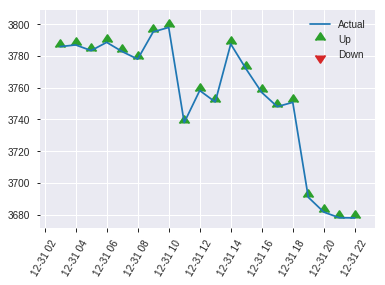


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24365797749055948
RMSE: 0.4936172378377395
LogLoss: 0.6801961339938776
Null degrees of freedom: 870
Residual degrees of freedom: 820
Null deviance: 1207.5487194139707
Residual deviance: 1184.9016654173347
AIC: 1286.9016654173347
AUC: 0.5928536024635113
pr_auc: 0.5880123641502054
Gini: 0.18570720492702253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4064915932819905: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      36   403  0.918    (403.0/439.0)
1      15   417  0.0347   (15.0/432.0)
Total  51   820  0.4799   (418.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406492     0.666134  366
max f2                       0.331145     0.831089  399
max f0point5                 0.439222     0.57362   316
max accuracy                 0.541602     0.571757  153
max precision                0.892941     1         0
max recall                   0.331145     1         399
max specificity              0.892941     1         0
max absolute_mcc             0.541602     0.146873  153
max min_per_class_accuracy   0.512793     0.564815  198
max mean_per_class_accuracy  0.541602     0.570668  153

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010333                    0.652194           1.56816   1.56816            0.777778         0.69105   0.777778                    0.69105             0.0162037       0.0162037                  56.8158    56.8158
    2        0.0206659                   0.641              1.56816   1.56816            0.777778         0.646661  0.777778                    0.668855            0.0162037       0.0324074                  56.8158    56.8158
    3        0.0309989                   0.633865           1.79218   1.64283            0.888889         0.637725  0.814815                    0.658479            0.0185185       0.0509259                  79.2181    64.2833
    4        0.0401837                   0.630615           1.26013   1.55536            0.625            0.632455  0.771429                    0.65253             0.0115741       0.0625                     26.0127    55.5357
    5        0.0505166                   0.623834           0.448045  1.32886            0.222222         0.628228  0.659091                    0.647559            0.00462963      0.0671296                  -55.1955   32.8862
    6        0.101033                    0.602851           1.37468   1.35177            0.681818         0.612306  0.670455                    0.629933            0.0694444       0.136574                   37.4684    35.1773
    7        0.150402                    0.593215           1.07843   1.26205            0.534884         0.598102  0.625954                    0.619484            0.0532407       0.189815                   7.84345    26.2051
    8        0.200918                    0.578174           1.19139   1.24429            0.590909         0.585765  0.617143                    0.611006            0.0601852       0.25                       19.1393    24.4286
    9        0.300804                    0.555226           1.04286   1.1774             0.517241         0.566759  0.583969                    0.596314            0.104167        0.354167                   4.2864     17.7401
    10       0.400689                    0.533661           1.13556   1.16697            0.563218         0.543884  0.578797                    0.583244            0.113426        0.467593                   13.5563    16.6972
    11       0.500574                    0.512557           0.996514  1.13296            0.494253         0.522881  0.561927                    0.571199            0.099537        0.56713                    -0.348553  13.2959
    12       0.600459                    0.491386           0.834291  1.08328            0.413793         0.502622  0.537285                    0.559791            0.0833333       0.650463                   -16.5709   8.32758
    13       0.700344                    0.466484           1.08921   1.08412            0.54023          0.47906   0.537705                    0.548277            0.108796        0.759259                   8.92135    8.41226
    14       0.80023                     0.441414           0.92699   1.06451            0.45977          0.453434  0.527977                    0.536439            0.0925926       0.851852                   -7.30098   6.45093
    15       0.900115                    0.419473           0.787942  1.03382            0.390805         0.430945  0.512755                    0.524732            0.0787037       0.930556                   -21.2058   3.38187
    16       1                           0.331145           0.695243  1                  0.344828         0.399067  0.495982                    

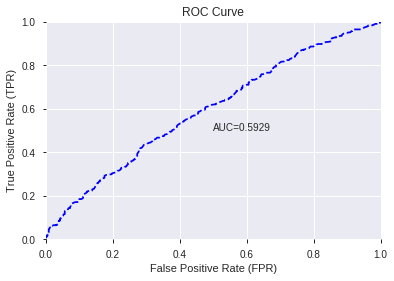

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


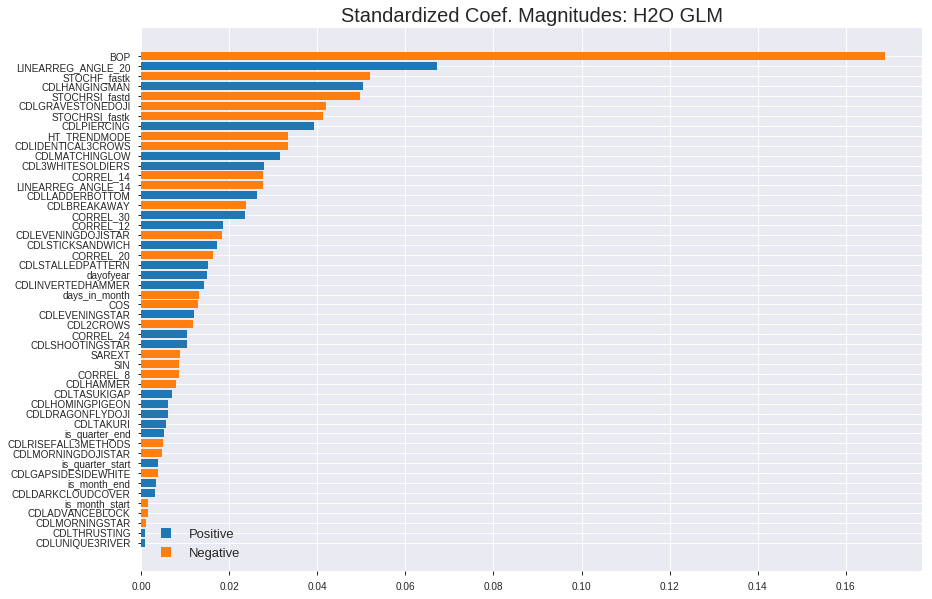

'log_likelihood'
--2019-07-25 05:08:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


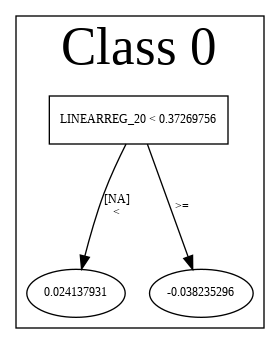

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_050757_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_050757_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'LINEARREG_ANGLE_20',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'STOCHRSI_fastd',
 'CDLGRAVESTONEDOJI',
 'STOCHRSI_fastk',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLIDENTICAL3CROWS',
 'CDLMATCHINGLOW',
 'CDL3WHITESOLDIERS',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'CDLLADDERBOTTOM',
 'CDLBREAKAWAY',
 'CORREL_30',
 'CORREL_12',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CORREL_20',
 'CDLSTALLEDPATTERN',
 'dayofyear',
 'CDLINVERTEDHAMMER',
 'days_in_month',
 'COS',
 'CDLEVENINGSTAR',
 'CDL2CROWS',
 'CORREL_24',
 'CDLSHOOTINGSTAR',
 'SAREXT',
 'SIN',
 'CORREL_8',
 'CDLHAMMER',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_quarter_end',
 'CDLRISEFALL3METHODS',
 'CDLMORNINGDOJISTAR',
 'is_quarter_start',
 'CDLGAPSIDESIDEWHITE',
 'is_month_end',
 'CDLDARKCLOUDCOVER',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLUNIQUE3RIVER']

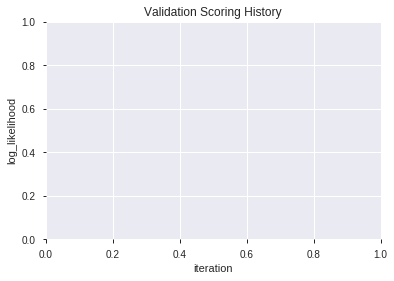

In [0]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_050819_model_6  0.603386  0.676203              0.461516  0.491717  0.241786
1  XGBoost_grid_1_AutoML_20190725_050819_model_4  0.603112  0.675719              0.426596  0.491399  0.241473
2  XGBoost_grid_1_AutoML_20190725_050819_model_2  0.594016  0.679160              0.454793  0.493107  0.243155
3  XGBoost_grid_1_AutoML_20190725_050819_model_3  0.589060  0.681122              0.451486  0.494046  0.244082
4               XGBoost_3_AutoML_20190725_050819  0.584973  0.681452              0.442467  0.494249  0.244282
5               XGBoost_2_AutoML_20190725_050819  0.584683  0.686849              0.472850  0.496614  0.246626
6  XGBoost_grid_1_AutoML_20190725_050819_model_1  0.582297  0.683222              0.479628  0.495092  0.245116
7  XGBoost_grid_1_AutoML_20190725_050819_model_5  0.580700  0.704025              0.476303  0.503676  0.253690
8               XGBoost_1_AutoML_20190725_050819  0.579708  0.686370              0.478397  0.496631  0.246642
9  XGBoost_grid_1_AutoML_20190725_050819_model_7  0.574723  0.687621              0.470572  0.497303  0.247310

variable  relative_importance  scaled_importance  percentage
0                  BOP          1169.477783           1.000000    0.126315
1       STOCHRSI_fastd           854.358459           0.730547    0.092279
2         STOCHF_fastk           764.556763           0.653759    0.082580
3                  SIN           733.390137           0.627109    0.079213
4            dayofyear           555.299316           0.474827    0.059978
5                  COS           534.697876           0.457211    0.057753
6            CORREL_14           527.577942           0.451123    0.056984
7             CORREL_8           519.193909           0.443954    0.056078
8   LINEARREG_ANGLE_14           489.336609           0.418423    0.052853
9       STOCHRSI_fastk           461.035736           0.394224    0.049796
10              SAREXT           445.791016           0.381188    0.048150
11           CORREL_20           439.435333           0.375753    0.047463
12  LINEARREG_ANGLE_20           419.889954           0.359041    0.045352
13           CORREL_30           409.435242           0.350101    0.044223
14           CORREL_24           369.513855           0.315965    0.039911
15           CORREL_12           367.334534           0.314101    0.039676
16       days_in_month            76.587738           0.065489    0.008272
17        HT_TRENDMODE            41.908871           0.035836    0.004527
18   CDLGRAVESTONEDOJI            26.082905           0.022303    0.002817
19       CDLHANGINGMAN            21.575125           0.018449    0.002330
20        is_month_end            15.889920           0.013587    0.001716
21           CDLHAMMER             6.156636           0.005264    0.000665
22      is_month_start             5.771491           0.004935    0.000623
23    CDLDRAGONFLYDOJI             4.106755           0.003512    0.000444

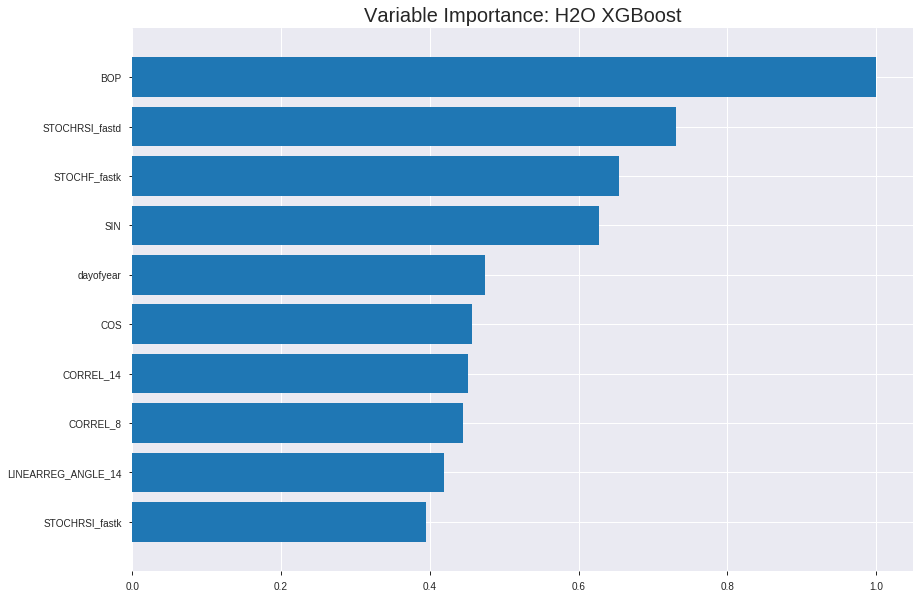

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_050819_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22014699244832717
RMSE: 0.46919824429373896
LogLoss: 0.6320532457317191
Mean Per-Class Error: 0.31957470653208775
AUC: 0.7516765826291805
pr_auc: 0.7526284659818958
Gini: 0.5033531652583609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4546116767451167: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1318  1715  0.5654   (1715.0/3033.0)
1      383   2679  0.1251   (383.0/3062.0)
Total  1701  4394  0.3442   (2098.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454612     0.718616  248
max f2                       0.347037     0.84219   347
max f0point5                 0.525692     0.689501  163
max accuracy                 0.525692     0.680066  163
max precision                0.715036     1         0
max recall                   0.31744      1         364
max specificity              0.715036     1         0
max absolute_mcc             0.525692     0.364946  163
max min_per_class_accuracy   0.507434     0.675898  186
max mean_per_class_accuracy  0.525692     0.680425  163

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.668343           1.99053   1.99053            1                0.683798  1                           0.683798            0.0199216       0.0199216                  99.0529   99.0529
    2        0.0200164                   0.655664           1.92527   1.9579             0.967213         0.660977  0.983607                    0.672388            0.0192685       0.0391901                  92.5266   95.7897
    3        0.0300246                   0.646301           1.72948   1.88176            0.868852         0.650368  0.945355                    0.665048            0.0173089       0.056499                   72.9476   88.1757
    4        0.0400328                   0.637804           1.76211   1.85184            0.885246         0.641949  0.930328                    0.659273            0.0176355       0.0741346                  76.2108   85.1845
    5        0.050041                    0.630499           1.66421   1.81432            0.836066         0.634547  0.911475                    0.654328            0.0166558       0.0907903                  66.4213   81.4318
    6        0.100082                    0.608488           1.72948   1.7719             0.868852         0.618639  0.890164                    0.636483            0.0865447       0.177335                   72.9476   77.1897
    7        0.150123                    0.592156           1.46842   1.67074            0.737705         0.599841  0.839344                    0.624269            0.0734814       0.250816                   46.8423   67.0739
    8        0.2                         0.578373           1.46016   1.61822            0.733553         0.58463   0.812961                    0.614384            0.0728282       0.323645                   46.0158   61.8223
    9        0.300082                    0.553681           1.31832   1.5182             0.662295         0.566237  0.762712                    0.598326            0.13194         0.455585                   31.8318   51.82
    10       0.4                         0.531056           1.20608   1.44024            0.605911         0.541896  0.723544                    0.58423             0.120509        0.576094                   20.6084   44.0235
    11       0.500082                    0.507412           0.998528  1.35184            0.501639         0.519342  0.679134                    0.571244            0.0999347       0.676029                   -0.14723  35.1836
    12       0.6                         0.483679           0.987093  1.2911             0.495895         0.495618  0.648619                    0.55865             0.0986283       0.774657                   -1.29068  29.1095
    13       0.699918                    0.459222           0.843278  1.22717            0.423645         0.471854  0.616503                    0.546259            0.0842587       0.858916                   -15.6722  22.7166
    14       0.8                         0.432658           0.636317  1.15325            0.319672         0.446596  0.579368                    0.533791            0.0636839       0.9226                     -36.3683  15.325
    15       0.899918                    0.389878           0.493547  1.08               0.247947         0.414064  0.542571                    0.520498            0.0493142       0.971914                   -50.6453  8.00026
    16       1                           0.209596           0.280632  1                  0.140984         0.343024  0.502379                    0.502736            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24575763948578572
RMSE: 0.49573948751918656
LogLoss: 0.6846905753244767
Mean Per-Class Error: 0.4322302822474281
AUC: 0.5879227116855711
pr_auc: 0.5517309226297575
Gini: 0.17584542337114217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35861824949582416: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      51   841   0.9428   (841.0/892.0)
1      19   831   0.0224   (19.0/850.0)
Total  70   1672  0.4937   (860.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358618     0.659001  358
max f2                       0.263857     0.827009  397
max f0point5                 0.468269     0.567686  259
max accuracy                 0.5541       0.56946   156
max precision                0.727566     1         0
max recall                   0.263857     1         397
max specificity              0.727566     1         0
max absolute_mcc             0.468269     0.138495  259
max min_per_class_accuracy   0.530334     0.561176  183
max mean_per_class_accuracy  0.550754     0.56777   160

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 52.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.697305           1.13856   1.13856            0.555556         0.710026  0.555556                    0.710026            0.0117647       0.0117647                  13.8562   13.8562
    2        0.0200918                   0.684127           1.08498   1.11254            0.529412         0.689589  0.542857                    0.7001              0.0105882       0.0223529                  8.49827   11.2538
    3        0.0304248                   0.674553           1.02471   1.08271            0.5              0.679978  0.528302                    0.693266            0.0105882       0.0329412                  2.47059   8.27081
    4        0.0401837                   0.668666           0.723322  0.995429           0.352941         0.671464  0.485714                    0.687971            0.00705882      0.04                       -27.6678  -0.457143
    5        0.0505166                   0.664429           1.36627   1.07128            0.666667         0.666628  0.522727                    0.683606            0.0141176       0.0541176                  36.6275   7.12834
    6        0.100459                    0.641313           1.38983   1.22965            0.678161         0.651043  0.6                         0.667418            0.0694118       0.123529                   38.9831   22.9647
    7        0.150402                    0.627269           1.20138   1.22026            0.586207         0.633672  0.59542                     0.656212            0.06            0.183529                   20.1379   22.026
    8        0.200344                    0.613395           1.17782   1.20968            0.574713         0.619744  0.590258                    0.647121            0.0588235       0.242353                   17.7823   20.9681
    9        0.30023                     0.585477           1.1896    1.203              0.58046          0.599226  0.586998                    0.631187            0.118824        0.361176                   18.9601   20.3001
    10       0.400115                    0.557055           1.04826   1.16437            0.511494         0.571024  0.568149                    0.616168            0.104706        0.465882                   4.82623   16.4372
    11       0.5                         0.529449           0.977593  1.12706            0.477011         0.544297  0.549943                    0.60181             0.0976471       0.563529                   -2.2407   12.7059
    12       0.599885                    0.503929           0.977593  1.10217            0.477011         0.517438  0.537799                    0.587762            0.0976471       0.661176                   -2.2407   10.2172
    13       0.69977                     0.476651           1.00115   1.08775            0.488506         0.489183  0.530763                    0.57369             0.1             0.761176                   0.114943  8.77518
    14       0.799656                    0.449685           0.812698  1.05339            0.396552         0.463278  0.513999                    0.559899            0.0811765       0.842353                   -18.7302  5.33947
    15       0.899541                    0.412329           0.906924  1.03713            0.442529         0.43282   0.506063                    0.545788            0.0905882       0.932941                   -9.30764  3.71305
    16       1                           0.231922           0.667523  1                  0.325714         0.358159  0.487945                    0.526939        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:08:44  14.240 sec  0                  0.5              0.693147            0.5             0                  1                0.497621                         0.5                0.693147              0.5               0                    1                  0.512055
    2019-07-25 05:08:44  14.361 sec  5                  0.494678         0.682544            0.658917        0.650928           1.68893          0.436259                         0.497177           0.687506              0.590018          0.554846             1.13856            0.494259
    2019-07-25 05:08:44  14.437 sec  10                 0.490535         0.674315            0.670693        0.667336           1.69684          0.429204                         0.495801           0.684741              0.585671          0.556321             1.25242            0.486223
    2019-07-25 05:08:44  14.525 sec  15                 0.487079         0.667453            0.683234        0.681212           1.82737          0.391304                         0.495156           0.683436              0.587394          0.55352              1.02471            0.499426
    2019-07-25 05:08:44  14.611 sec  20                 0.483657         0.660646            0.694892        0.69084            1.79474          0.409188                         0.495009           0.683132              0.585818          0.549654             1.13856            0.5
    2019-07-25 05:08:44  14.697 sec  25                 0.480984         0.655317            0.703908        0.702446           1.89263          0.388187                         0.494843           0.682771              0.585544          0.552614             1.02471            0.483352
    2019-07-25 05:08:44  14.792 sec  30                 0.478131         0.649641            0.715291        0.714809           1.92527          0.387039                         0.495066           0.683217              0.585034          0.552526             1.25242            0.483352
    2019-07-25 05:08:44  14.899 sec  35                 0.475466         0.644418            0.729357        0.729352           1.9579           0.369811                         0.495659           0.684451              0.583622          0.550906             1.25242            0.504018
    2019-07-25 05:08:44  14.993 sec  40                 0.473454         0.640453            0.738           0.737462           1.99053          0.350451                         0.495582           0.684292              0.584577          0.551147             1.02471            0.503444
    2019-07-25 05:08:44  15.091 sec  45                 0.471255         0.636108            0.745205        0.744401           1.99053          0.355537                         0.495864           0.684929              0.586559          0.55121              1.13856            0.495408
    2019-07-25 05:08:45  15.216 sec  50                 0.469198         0.632053            0.751677        0.752628           1.99053          0.344217                         0.495739           0.684691              0.587923          0.551731             1.13856            0.493685

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
BOP               1169.477783203125      1.0                    0.1263152693979176
STOCHRSI_fastd    854.3584594726562      0.7305469772436574     0.09227923823836695
STOCHF_fastk      764.5567626953125      0.653759116826692      0.08257975896330827
SIN               733.39013671875        0.6271090800117991     0.07921345238357066
dayofyear         555.29931640625        0.47482673410461945    0.05997786683575839
---               ---                    ---                    ---
CDLHANGINGMAN     21.575124740600586     0.01844851184903034    0.002330328744200942
is_month_end      15.889920234680176     0.013587192901740038   0.0017162699317447667
CDLHAMMER         6.156635761260986      0.0052644315691045915  0.0006649780918783485
is_month_start    5.771490573883057      0.004935100654990907   0.000623378568741016
CDLDRAGONFLYDOJI  4.106755256652832      0.003511614598957743   0.00044357054408900764


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5786452353616532)

('F1', 0.6741753821399838)

('auc', 0.603386273517253)

('logloss', 0.6762034771414359)

('mean_per_class_error', 0.4223508816333418)

('rmse', 0.4917169421553342)

('mse', 0.24178555120259224)

xgboost prediction progress: |████████████████████████████████████████████| 100%


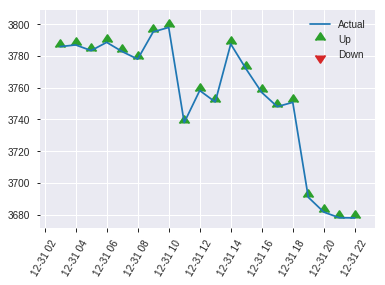


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24178555120259224
RMSE: 0.4917169421553342
LogLoss: 0.6762034771414359
Mean Per-Class Error: 0.4223508816333418
AUC: 0.603386273517253
pr_auc: 0.5976525026623538
Gini: 0.2067725470345061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38192035257816315: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   392  0.8929   (392.0/439.0)
1      13   419  0.0301   (13.0/432.0)
Total  60   811  0.465    (405.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38192      0.674175  350
max f2                       0.269465     0.832691  395
max f0point5                 0.430018     0.575421  310
max accuracy                 0.564468     0.578645  142
max precision                0.730915     1         0
max recall                   0.269465     1         395
max specificity              0.730915     1         0
max absolute_mcc             0.564468     0.160349  142
max min_per_class_accuracy   0.53147      0.569476  186
max mean_per_class_accuracy  0.564468     0.577649  142

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.699858           1.56816   1.56816            0.777778         0.713656  0.777778                    0.713656            0.0162037       0.0162037                  56.8158   56.8158
    2        0.0206659                   0.691151           1.79218   1.68017            0.888889         0.69438   0.833333                    0.704018            0.0185185       0.0347222                  79.2181   68.017
    3        0.0309989                   0.679114           1.56816   1.64283            0.777778         0.682831  0.814815                    0.696956            0.0162037       0.0509259                  56.8158   64.2833
    4        0.0401837                   0.671427           1.26013   1.55536            0.625            0.675118  0.771429                    0.691964            0.0115741       0.0625                     26.0127   55.5357
    5        0.0505166                   0.666661           1.12011   1.46633            0.555556         0.668603  0.727273                    0.687186            0.0115741       0.0740741                  12.0113   46.633
    6        0.101033                    0.643894           1.23722   1.35177            0.613636         0.653852  0.670455                    0.670519            0.0625          0.136574                   23.7216   35.1773
    7        0.150402                    0.628019           1.12532   1.27744            0.55814          0.63616   0.633588                    0.659241            0.0555556       0.19213                    12.5323   27.7442
    8        0.200918                    0.612051           1.28304   1.27885            0.636364         0.619858  0.634286                    0.649339            0.0648148       0.256944                   28.3039   27.8849
    9        0.300804                    0.58293            1.15874   1.23896            0.574713         0.597546  0.614504                    0.63214             0.115741        0.372685                   15.8738   23.8965
    10       0.400689                    0.557371           0.97334   1.17275            0.482759         0.570567  0.581662                    0.616791            0.0972222       0.469907                   -2.66603  17.2749
    11       0.500574                    0.531414           1.01969   1.14221            0.505747         0.543485  0.566514                    0.602163            0.101852        0.571759                   1.96892   14.2207
    12       0.600459                    0.5011             0.92699   1.10641            0.45977          0.515388  0.548757                    0.587729            0.0925926       0.664352                   -7.30098  10.6406
    13       0.700344                    0.469543           0.92699   1.08082            0.45977          0.486145  0.536066                    0.57324             0.0925926       0.756944                   -7.30098  8.08174
    14       0.80023                     0.436908           0.92699   1.06162            0.45977          0.453257  0.526542                    0.558264            0.0925926       0.849537                   -7.30098  6.16166
    15       0.900115                    0.398802           0.92699   1.04668            0.45977          0.420941  0.519133                    0.543025            0.0925926       0.94213                    -7.30098  4.66772
    16       1                           0.253184           0.579369  1                  0.287356         0.348869  0.495982                    0.523632           

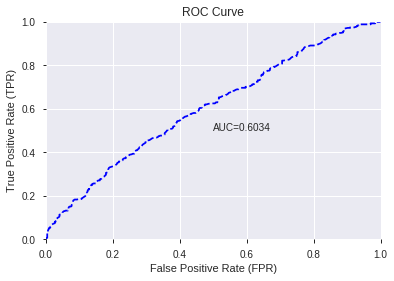

This function is available for GLM models only


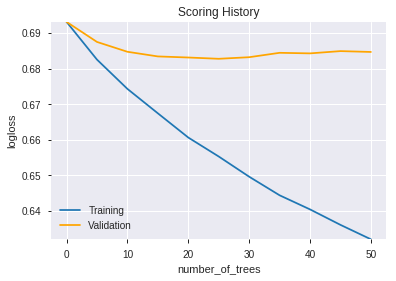

--2019-07-25 05:08:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

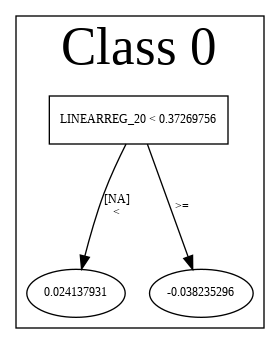

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_050819_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_050819_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'SIN',
 'dayofyear',
 'COS',
 'CORREL_14',
 'CORREL_8',
 'LINEARREG_ANGLE_14',
 'STOCHRSI_fastk',
 'SAREXT',
 'CORREL_20',
 'LINEARREG_ANGLE_20',
 'CORREL_30',
 'CORREL_24',
 'CORREL_12',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'is_month_end',
 'CDLHAMMER',
 'is_month_start',
 'CDLDRAGONFLYDOJI']

In [0]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190725_050908_model_1  0.599437  0.678597              0.458228  0.49281  0.242862

variable  relative_importance  scaled_importance    percentage
0                          BOP         7.320693e-02       1.000000e+00  2.694729e-02
1                   CDLHIKKAKE         4.702445e-02       6.423497e-01  1.730958e-02
2                 CDLSHORTLINE         4.589725e-02       6.269523e-01  1.689466e-02
3                  CDLLONGLINE         3.802506e-02       5.194189e-01  1.399693e-02
4                 STOCHF_fastk         3.540803e-02       4.836705e-01  1.303361e-02
...                        ...                  ...                ...           ...
1035  BBANDS_middleband_12_2_4         1.284488e-06       1.754599e-05  4.728167e-07
1036   BBANDS_lowerband_14_5_3         1.138139e-06       1.554688e-05  4.189462e-07
1037                    EMA_24         2.122847e-07       2.899789e-06  7.814146e-08
1038                    SUM_14         1.991879e-07       2.720889e-06  7.332057e-08
1039    BBANDS_upperband_8_3_3         7.295100e-08       9.965041e-07  2.685308e-08

[1040 rows x 4 columns]

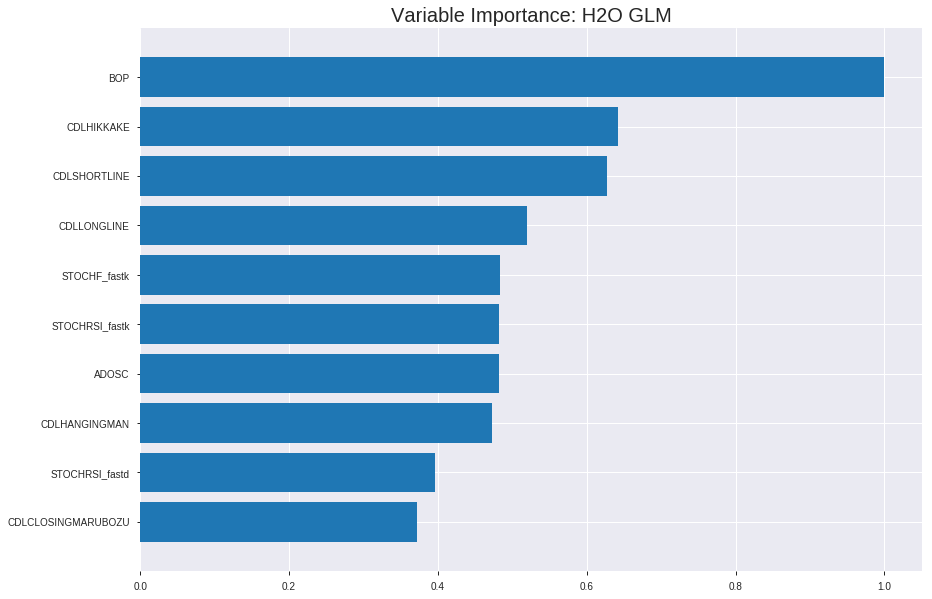

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_050908_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24064395179194134
RMSE: 0.49055473883343675
LogLoss: 0.6741282260715904
Null degrees of freedom: 6094
Residual degrees of freedom: 5054
Null deviance: 8449.32614855268
Residual deviance: 8217.623075812688
AIC: 10299.623075812688
AUC: 0.6130067623224866
pr_auc: 0.5988801703123933
Gini: 0.22601352464497326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3973288218284732: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      324  2709  0.8932   (2709.0/3033.0)
1      125  2937  0.0408   (125.0/3062.0)
Total  449  5646  0.465    (2834.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397329     0.674552  331
max f2                       0.306107     0.835243  389
max f0point5                 0.477826     0.588091  235
max accuracy                 0.511015     0.580968  188
max precision                0.787072     1         0
max recall                   0.306107     1         389
max specificity              0.787072     1         0
max absolute_mcc             0.511015     0.162747  188
max min_per_class_accuracy   0.503226     0.578635  200
max mean_per_class_accuracy  0.511015     0.581147  188

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.661539           1.37053   1.37053            0.688525         0.689298  0.688525                    0.689298            0.0137165       0.0137165                  37.0528   37.0528
    2        0.0200164                   0.645797           1.27263   1.32158            0.639344         0.652893  0.663934                    0.671095            0.0127368       0.0264533                  27.2633   32.1581
    3        0.0300246                   0.634749           1.30526   1.31614            0.655738         0.639451  0.661202                    0.660547            0.0130634       0.0395167                  30.5265   31.6142
    4        0.0400328                   0.627809           1.53369   1.37053            0.770492         0.631251  0.688525                    0.653223            0.0153494       0.0548661                  53.3686   37.0528
    5        0.050041                    0.620518           1.37053   1.37053            0.688525         0.624153  0.688525                    0.647409            0.0137165       0.0685826                  37.0528   37.0528
    6        0.100082                    0.596471           1.31179   1.34116            0.659016         0.608351  0.67377                     0.62788             0.0656434       0.134226                   31.1791   34.116
    7        0.150123                    0.578964           1.24653   1.30962            0.62623          0.5873    0.657923                    0.614353            0.0623775       0.196604                   24.6528   30.9616
    8        0.2                         0.565976           1.14586   1.26878            0.575658         0.572152  0.637408                    0.603829            0.0571522       0.253756                   14.5864   26.8779
    9        0.300082                    0.543252           1.14863   1.22871            0.577049         0.554425  0.617277                    0.587352            0.114958        0.368713                   14.8633   22.8708
    10       0.4                         0.523158           1.07861   1.19121            0.541872         0.532937  0.598441                    0.573759            0.107773        0.476486                   7.86118   19.1215
    11       0.500082                    0.503154           1.02137   1.15722            0.513115         0.513216  0.581365                    0.561643            0.102221        0.578707                   2.13698   15.7224
    12       0.6                         0.482636           0.967482  1.12563            0.486043         0.493118  0.565491                    0.550231            0.0966688       0.675376                   -3.25179  12.5626
    13       0.699918                    0.461492           0.947871  1.10025            0.47619          0.472405  0.552743                    0.539121            0.0947093       0.770085                   -5.2129   10.025
    14       0.8                         0.437852           0.861475  1.07038            0.432787         0.449579  0.537736                    0.527919            0.0862182       0.856303                   -13.8525  7.03788
    15       0.899918                    0.407116           0.836741  1.04444            0.420361         0.424     0.524704                    0.516381            0.0836055       0.939909                   -16.3259  4.4438
    16       1                           0.238546           0.600422  1                  0.301639         0.376476  0.502379                    0.502379            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24241330304973105
RMSE: 0.49235485480467345
LogLoss: 0.6777073384833621
Null degrees of freedom: 1741
Residual degrees of freedom: 701
Null deviance: 2415.3638887467546
Residual deviance: 2361.1323672760336
AIC: 4443.132367276034
AUC: 0.6029293062516488
pr_auc: 0.5881946471480447
Gini: 0.2058586125032975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37725683499524787: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   853   0.9563   (853.0/892.0)
1      11   839   0.0129   (11.0/850.0)
Total  50   1692  0.496    (864.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377257     0.66011   369
max f2                       0.33316      0.827976  392
max f0point5                 0.509437     0.57422   207
max accuracy                 0.546406     0.582664  153
max precision                0.784941     1         0
max recall                   0.33316      1         392
max specificity              0.784941     1         0
max absolute_mcc             0.546406     0.165413  153
max min_per_class_accuracy   0.516098     0.577354  198
max mean_per_class_accuracy  0.509437     0.58175   207

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 51.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.683911           1.48013   1.48013            0.722222         0.710413  0.722222                    0.710413            0.0152941       0.0152941                  48.0131   48.0131
    2        0.0200918                   0.66313            1.44664   1.46387            0.705882         0.673187  0.714286                    0.692332            0.0141176       0.0294118                  44.6644   46.3866
    3        0.0304248                   0.652898           1.36627   1.43072            0.666667         0.657977  0.698113                    0.680664            0.0141176       0.0435294                  36.6275   43.0721
    4        0.0401837                   0.64155            1.68775   1.49314            0.823529         0.64632   0.728571                    0.672324            0.0164706       0.06                       68.7751   49.3143
    5        0.0505166                   0.636422           1.48013   1.49048            0.722222         0.639188  0.727273                    0.665546            0.0152941       0.0752941                  48.0131   49.0481
    6        0.100459                    0.608113           1.34272   1.41702            0.655172         0.622128  0.691429                    0.643961            0.0670588       0.142353                   34.2718   41.7022
    7        0.150402                    0.594563           1.29561   1.3767             0.632184         0.600914  0.671756                    0.629667            0.0647059       0.207059                   29.5605   37.6704
    8        0.200344                    0.581758           1.06004   1.29777            0.517241         0.588209  0.633238                    0.619332            0.0529412       0.26                       6.00406   29.7765
    9        0.30023                     0.556908           1.13071   1.24219            0.551724         0.56933   0.606119                    0.602696            0.112941        0.372941                   13.071    24.2186
    10       0.400115                    0.536464           1.04826   1.19378            0.511494         0.54697   0.582496                    0.588785            0.104706        0.477647                   4.82623   19.3775
    11       0.5                         0.515479           1.03648   1.16235            0.505747         0.526525  0.567164                    0.576347            0.103529        0.581176                   3.64841   16.2353
    12       0.599885                    0.491722           0.871589  1.11394            0.425287         0.503995  0.543541                    0.5643              0.0870588       0.668235                   -12.8411  11.3939
    13       0.69977                     0.471174           0.789141  1.06758            0.385057         0.481685  0.520919                    0.552507            0.0788235       0.747059                   -21.0859  6.75771
    14       0.799656                    0.44712            1.00115   1.05928            0.488506         0.459643  0.51687                     0.540908            0.1             0.847059                   0.114943  5.92796
    15       0.899541                    0.417553           0.765585  1.02667            0.373563         0.434987  0.500957                    0.529146            0.0764706       0.923529                   -23.4415  2.66677
    16       1                           0.297132           0.76121   1                  0.371429         0.385405  0.487945                    0.514706         


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:09:19  0.000 sec         2            6.8       956           1.37729           1.37677
    2019-07-25 05:09:25  6.490 sec         4            4.9       982           1.37522           1.37449
    2019-07-25 05:09:32  13.389 sec        6            3.6       1001          1.37291           1.372
    2019-07-25 05:09:38  19.864 sec        8            2.6       1026          1.37038           1.36937
    2019-07-25 05:09:45  26.492 sec        10           1.9       1034          1.36768           1.3667
    2019-07-25 05:09:52  33.290 sec        12           1.4       1037          1.36485           1.3641
    2019-07-25 05:09:58  39.698 sec        14           1         1039          1.36196           1.36168
    2019-07-25 05:10:05  46.237 sec        16           0.73      1041          1.35905           1.35956
    2019-07-25 05:10:12  53.010 sec        18           0.53      1041          1.35619           1.35783
    2019-07-25 05:10:18  59.567 sec        20           0.39      1041          1.35341           1.35654
    2019-07-25 05:10:25  1 min  6.120 sec  22           0.28      1041          1.35075           1.35574
    2019-07-25 05:10:32  1 min 12.887 sec  24           0.21      1041          1.34826           1.35541
    2019-07-25 05:10:38  1 min 19.417 sec  26           0.15      1041          1.34594           1.35552
    2019-07-25 05:10:45  1 min 25.972 sec  28           0.11      1041          1.34381           1.356
    2019-07-25 05:10:51  1 min 32.742 sec  30           0.079     1041          1.34183           1.35684
    2019-07-25 05:10:59  1 min 40.600 sec  32           0.058     1041          1.34001           1.35795
    2019-07-25 05:11:06  1 min 47.269 sec  34           0.042     1041          1.33832           1.35929

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5763490241102182)

('F1', 0.6721044045676998)

('auc', 0.5994368514300177)

('logloss', 0.6785965816046817)

('mean_per_class_error', 0.4230785455159032)

('rmse', 0.49281037508247955)

('mse', 0.24286206578893418)

glm prediction progress: |████████████████████████████████████████████████| 100%


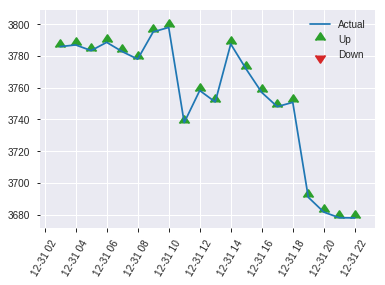


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24286206578893418
RMSE: 0.49281037508247955
LogLoss: 0.6785965816046817
Null degrees of freedom: 870
Residual degrees of freedom: -170
Null deviance: 1207.5487194139707
Residual deviance: 1182.1152451553553
AIC: 3264.1152451553553
AUC: 0.5994368514300177
pr_auc: 0.5868018949854199
Gini: 0.19887370286003536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4234497596419892: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   382  0.8702   (382.0/439.0)
1      20   412  0.0463   (20.0/432.0)
Total  77   794  0.4615   (402.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42345      0.672104  346
max f2                       0.356895     0.832691  394
max f0point5                 0.492525     0.580161  248
max accuracy                 0.51255      0.576349  216
max precision                0.806795     1         0
max recall                   0.356895     1         394
max specificity              0.806795     1         0
max absolute_mcc             0.570671     0.158777  123
max min_per_class_accuracy   0.526286     0.56713   195
max mean_per_class_accuracy  0.51084      0.576921  219

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 52.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.684243           1.56816   1.56816            0.777778         0.724472  0.777778                    0.724472            0.0162037       0.0162037                  56.8158   56.8158
    2        0.0206659                   0.672848           1.56816   1.56816            0.777778         0.677037  0.777778                    0.700755            0.0162037       0.0324074                  56.8158   56.8158
    3        0.0309989                   0.653268           1.12011   1.41881            0.555556         0.662953  0.703704                    0.688154            0.0115741       0.0439815                  12.0113   41.881
    4        0.0401837                   0.646562           1.51215   1.44015            0.75             0.64954   0.714286                    0.679328            0.0138889       0.0578704                  51.2153   44.0146
    5        0.0505166                   0.639384           1.79218   1.51215            0.888889         0.642038  0.75                        0.6717              0.0185185       0.0763889                  79.2181   51.2153
    6        0.101033                    0.617358           1.23722   1.37468            0.613636         0.627868  0.681818                    0.649784            0.0625          0.138889                   23.7216   37.4684
    7        0.150402                    0.602387           0.937769  1.23127            0.465116         0.60987   0.610687                    0.636683            0.0462963       0.185185                   -6.22308  23.1269
    8        0.200918                    0.590029           1.32886   1.25581            0.659091         0.595752  0.622857                    0.626391            0.0671296       0.252315                   32.8862   25.5807
    9        0.300804                    0.567482           1.11239   1.20818            0.551724         0.57651   0.599237                    0.609828            0.111111        0.363426                   11.2388   20.8183
    10       0.400689                    0.545519           0.92699   1.13809            0.45977          0.557008  0.56447                     0.596661            0.0925926       0.456019                   -7.30098  13.8086
    11       0.500574                    0.525852           1.13556   1.13758            0.563218         0.536089  0.56422                     0.584574            0.113426        0.569444                   13.5563   13.7583
    12       0.600459                    0.503839           1.01969   1.11797            0.505747         0.514738  0.554493                    0.572957            0.101852        0.671296                   1.96892   11.7971
    13       0.700344                    0.482418           0.903815  1.08743            0.448276         0.493646  0.539344                    0.561645            0.0902778       0.761574                   -9.61845  8.74279
    14       0.80023                     0.454999           0.857466  1.05872            0.425287         0.467876  0.525108                    0.549941            0.0856481       0.847222                   -14.2534  5.87239
    15       0.900115                    0.426058           0.950165  1.04668            0.471264         0.442062  0.519133                    0.53797             0.0949074       0.94213                    -4.9835   4.66772
    16       1                           0.31025            0.579369  1                  0.287356         0.396708  0.495982                    0.52386           

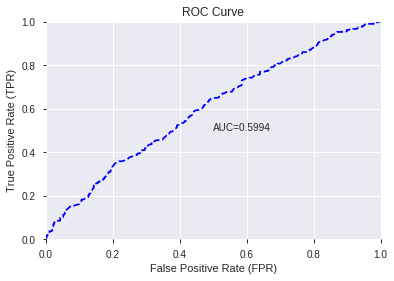

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


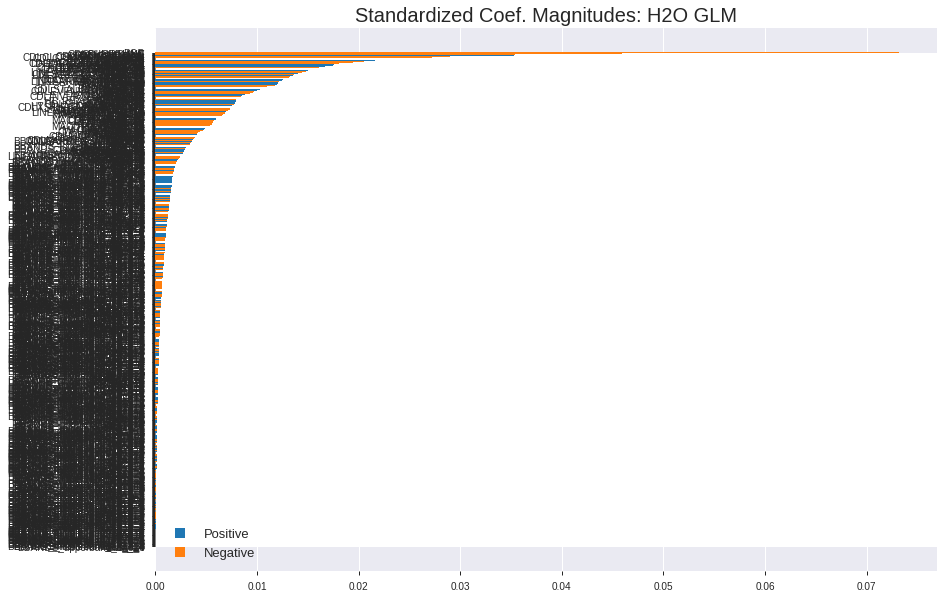

'log_likelihood'
--2019-07-25 05:11:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


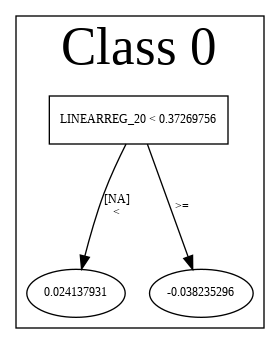

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_050908_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_050908_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

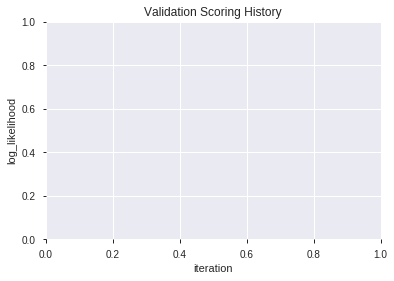

In [0]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [0]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [0]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [0]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_051140_model_4  0.605614  0.675030              0.440115  0.491041  0.241121
1  XGBoost_grid_1_AutoML_20190725_051140_model_3  0.599548  0.676982              0.464969  0.492023  0.242087
2               XGBoost_1_AutoML_20190725_051140  0.598090  0.679444              0.463941  0.493205  0.243251
3               XGBoost_2_AutoML_20190725_051140  0.597525  0.678895              0.454663  0.492970  0.243020
4  XGBoost_grid_1_AutoML_20190725_051140_model_7  0.593291  0.684638              0.444930  0.495614  0.245634
5               XGBoost_3_AutoML_20190725_051140  0.591612  0.682234              0.466127  0.494673  0.244702
6  XGBoost_grid_1_AutoML_20190725_051140_model_2  0.589563  0.680276              0.473989  0.493607  0.243648
7  XGBoost_grid_1_AutoML_20190725_051140_model_5  0.588786  0.684834              0.495463  0.495675  0.245694
8  XGBoost_grid_1_AutoML_20190725_051140_model_1  0.584973  0.682462              0.476267  0.494713  0.244741
9  XGBoost_grid_1_AutoML_20190725_051140_model_6  0.584369  0.682001              0.483008  0.494506  0.244536

variable  relative_importance  scaled_importance  percentage
0                        BOP           703.689941           1.000000    0.091485
1               STOCHF_fastk           369.708160           0.525385    0.048065
2             STOCHRSI_fastd           224.927612           0.319640    0.029242
3                        COS           127.256470           0.180842    0.016544
4             STOCHRSI_fastk           117.550758           0.167049    0.015282
..                       ...                  ...                ...         ...
207                   MIN_30             5.730366           0.008143    0.000745
208  BBANDS_lowerband_14_2_2             5.687009           0.008082    0.000739
209                    DX_30             5.424994           0.007709    0.000705
210                   TRIX_8             5.227028           0.007428    0.000680
211           MACDFIX_hist_8             5.139593           0.007304    0.000668

[212 rows x 4 columns]

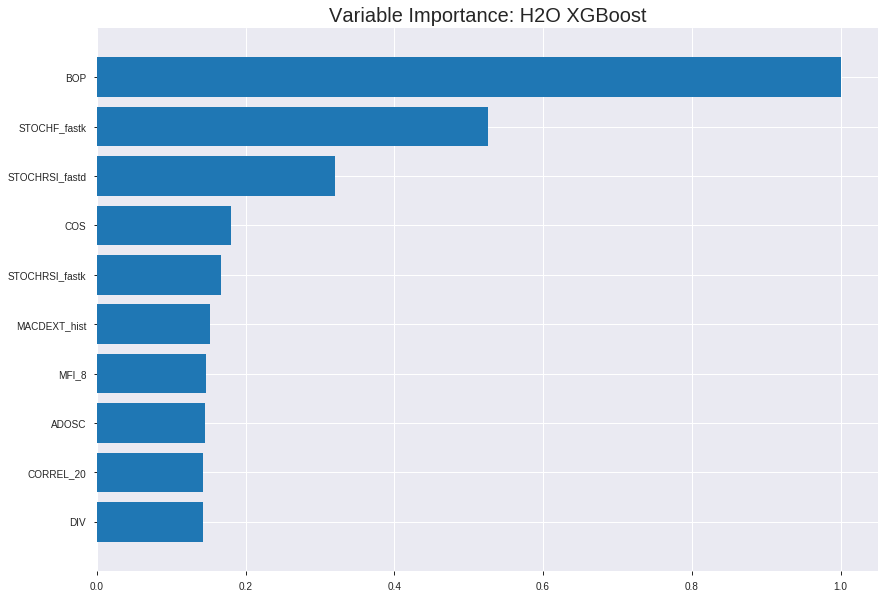

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_051140_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22144730034196547
RMSE: 0.4705818742174049
LogLoss: 0.6348851689735576
Mean Per-Class Error: 0.31876799145820967
AUC: 0.7481388592239125
pr_auc: 0.7410284975725656
Gini: 0.4962777184478251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4574279124322145: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1373  1660  0.5473   (1660.0/3033.0)
1      415   2647  0.1355   (415.0/3062.0)
Total  1788  4307  0.3404   (2075.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457428     0.718415  246
max f2                       0.401553     0.842655  310
max f0point5                 0.498868     0.680315  195
max accuracy                 0.498868     0.681378  195
max precision                0.71726      1         0
max recall                   0.298745     1         384
max specificity              0.71726      1         0
max absolute_mcc             0.495344     0.363984  200
max min_per_class_accuracy   0.505334     0.674909  186
max mean_per_class_accuracy  0.498868     0.681232  195

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.66129            1.86      1.86               0.934426         0.678169  0.934426                    0.678169            0.0186153       0.0186153                  86.0003   86.0003
    2        0.0200164                   0.648308           1.76211   1.81106            0.885246         0.654915  0.909836                    0.666542            0.0176355       0.0362508                  76.2108   81.1055
    3        0.0300246                   0.640133           1.82737   1.81649            0.918033         0.643905  0.912568                    0.658997            0.0182887       0.0545395                  82.7371   81.6494
    4        0.0400328                   0.633791           1.79474   1.81106            0.901639         0.637087  0.909836                    0.653519            0.0179621       0.0725016                  79.4739   81.1055
    5        0.050041                    0.628391           1.66421   1.78169            0.836066         0.630668  0.895082                    0.648949            0.0166558       0.0891574                  66.4213   78.1687
    6        0.100082                    0.60595            1.65116   1.71642            0.829508         0.616702  0.862295                    0.632825            0.0826257       0.171783                   65.116    71.6423
    7        0.150123                    0.587971           1.55979   1.66421            0.783607         0.596652  0.836066                    0.620768            0.0780536       0.249837                   55.9792   66.4213
    8        0.2                         0.573458           1.42742   1.60516            0.717105         0.580733  0.806399                    0.610784            0.0711953       0.321032                   42.7419   60.516
    9        0.300082                    0.548618           1.31832   1.50949            0.662295         0.560689  0.758338                    0.594076            0.13194         0.452972                   31.8318   50.9494
    10       0.4                         0.526142           1.06881   1.39941            0.536946         0.537077  0.703035                    0.579838            0.106793        0.559765                   6.88062   39.9412
    11       0.500082                    0.505327           1.1519    1.34988            0.578689         0.515582  0.67815                     0.566978            0.115284        0.675049                   15.1896   34.9877
    12       0.6                         0.484528           1.00344   1.29218            0.504105         0.494738  0.649166                    0.554948            0.100261        0.77531                    0.343583  29.2184
    13       0.699918                    0.459126           0.826936  1.22577            0.415435         0.471707  0.615799                    0.543065            0.0826257       0.857936                   -17.3064  22.5766
    14       0.8                         0.429675           0.685264  1.15815            0.344262         0.444673  0.581829                    0.530756            0.0685826       0.926519                   -31.4736  15.8148
    15       0.899918                    0.390554           0.48701   1.08363            0.244663         0.412263  0.544394                    0.5176              0.048661        0.97518                    -51.299   8.36317
    16       1                           0.234236           0.248     1                  0.12459          0.353045  0.502379                    0.501131          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24494035806926528
RMSE: 0.494914495715437
LogLoss: 0.682982666253775
Mean Per-Class Error: 0.4234199419678185
AUC: 0.5868233975204432
pr_auc: 0.552930698032965
Gini: 0.17364679504088643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38911635677019757: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      76   816   0.9148   (816.0/892.0)
1      28   822   0.0329   (28.0/850.0)
Total  104  1638  0.4845   (844.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389116     0.660772  347
max f2                       0.293828     0.827009  396
max f0point5                 0.51675      0.566082  191
max accuracy                 0.51675      0.576923  191
max precision                0.709753     1         0
max recall                   0.293828     1         396
max specificity              0.709753     1         0
max absolute_mcc             0.51675      0.153195  191
max min_per_class_accuracy   0.514292     0.571765  194
max mean_per_class_accuracy  0.51675      0.57658   191

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.679717           1.25242   1.25242            0.611111         0.688028  0.611111                    0.688028            0.0129412       0.0129412                  25.2418   25.2418
    2        0.0200918                   0.670286           1.20554   1.22965            0.588235         0.674452  0.6                         0.681434            0.0117647       0.0247059                  20.5536   22.9647
    3        0.0304248                   0.661821           0.796993  1.08271            0.388889         0.666008  0.528302                    0.676195            0.00823529      0.0329412                  -20.3007  8.27081
    4        0.0401837                   0.655961           1.32609   1.14182            0.647059         0.659407  0.557143                    0.672118            0.0129412       0.0458824                  32.609    14.1815
    5        0.0505166                   0.650635           1.48013   1.21102            0.722222         0.653281  0.590909                    0.668265            0.0152941       0.0611765                  48.0131   21.1016
    6        0.100459                    0.629266           1.24849   1.22965            0.609195         0.640218  0.6                         0.654321            0.0623529       0.123529                   24.8492   22.9647
    7        0.150402                    0.612443           1.24849   1.2359             0.609195         0.620348  0.603053                    0.64304             0.0623529       0.185882                   24.8492   23.5905
    8        0.200344                    0.596478           1.0836    1.19794            0.528736         0.603947  0.584527                    0.633295            0.0541176       0.24                       8.3597    19.7937
    9        0.30023                     0.565464           1.06004   1.15206            0.517241         0.580469  0.562141                    0.61572             0.105882        0.345882                   6.00406   15.2059
    10       0.400115                    0.536563           1.14249   1.14967            0.557471         0.552202  0.560976                    0.599863            0.114118        0.46                       14.2488   14.967
    11       0.5                         0.512756           1.11893   1.14353            0.545977         0.524188  0.557979                    0.584745            0.111765        0.571765                   11.8932   14.3529
    12       0.599885                    0.493914           0.871589  1.09825            0.425287         0.504029  0.535885                    0.571306            0.0870588       0.658824                   -12.8411  9.82494
    13       0.69977                     0.469404           0.93048   1.0743             0.454023         0.481526  0.5242                      0.55849             0.0929412       0.751765                   -6.95199  7.4302
    14       0.799656                    0.444525           0.883367  1.05045            0.431034         0.456795  0.512563                    0.545788            0.0882353       0.84                       -11.6633  5.04523
    15       0.899541                    0.407297           0.918702  1.03582            0.448276         0.428055  0.505424                    0.532715            0.0917647       0.931765                   -8.12982  3.58227
    16       1                           0.271484           0.679234  1                  0.331429         0.374869  0.487945                    0.516858           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:12:56  26.279 sec  0                  0.5              0.693147            0.5             0                  1                0.497621                         0.5                0.693147              0.5               0                    1                  0.512055
    2019-07-25 05:12:58  28.304 sec  5                  0.494918         0.683022            0.661204        0.649189           1.65367          0.435439                         0.498134           0.689417              0.566699          0.537023             1.17109            0.498852
    2019-07-25 05:12:59  29.164 sec  10                 0.490196         0.673655            0.681419        0.671996           1.66421          0.415751                         0.496018           0.685191              0.587984          0.547323             0.796993           0.486223
    2019-07-25 05:13:00  30.091 sec  15                 0.486784         0.666893            0.692087        0.682854           1.66421          0.382281                         0.495756           0.684659              0.583245          0.542724             0.796993           0.491389
    2019-07-25 05:13:01  31.083 sec  20                 0.483587         0.660567            0.702432        0.694889           1.79474          0.372765                         0.495329           0.683796              0.584286          0.545794             0.91085            0.487945
    2019-07-25 05:13:02  32.150 sec  25                 0.481023         0.655477            0.708951        0.703416           1.86             0.383101                         0.494923           0.682971              0.584811          0.548978             1.02471            0.476464
    2019-07-25 05:13:03  33.098 sec  30                 0.478473         0.650437            0.718197        0.712337           1.82737          0.369483                         0.49448            0.682066              0.587292          0.552903             1.13856            0.474168
    2019-07-25 05:13:04  34.066 sec  35                 0.476427         0.646389            0.725091        0.718874           1.82737          0.358655                         0.494235           0.681584              0.589485          0.553406             1.25242            0.473594
    2019-07-25 05:13:05  35.007 sec  40                 0.474726         0.643051            0.733769        0.727049           1.79474          0.356522                         0.494255           0.68161               0.588301          0.554027             1.25242            0.47302
    2019-07-25 05:13:06  35.949 sec  45                 0.472641         0.638936            0.739942        0.731642           1.82737          0.353568                         0.494413           0.681956              0.588835          0.554083             1.25242            0.488519
    2019-07-25 05:13:07  36.986 sec  50                 0.470582         0.634885            0.748139        0.741028           1.86             0.340443                         0.494914           0.682983              0.586823          0.552931             1.25242            0.484501

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      703.68994140625        1.0                    0.09148507473103616
STOCHF_fastk             369.7081604003906      0.5253850291814146     0.048064888657229334
STOCHRSI_fastd           224.9276123046875      0.31964022656795893    0.029242310014615056
COS                      127.2564697265625      0.18084167790185246    0.016544314417336944
STOCHRSI_fastk           117.5507583618164      0.16704908148452943    0.015282497703363125
---                      ---                    ---                    ---
MIN_30                   5.730366230010986      0.008143311269391537   0.0007449914400383738
BBANDS_lowerband_14_2_2  5.687008857727051      0.008081696956421126   0.0007393546500117742
DX_30                    5.424993991851807      0.007709352759839837   0.0007052907133618674
TRIX_8                   5.227027893066406      0.0074280270123241255  0.000679553606326628
MACDFIX_hist_8           5.13959264755249       0.007303774496593709   0.0006681863556395115


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5763490241102182)

('F1', 0.67779632721202)

('auc', 0.6056140850417615)

('logloss', 0.67503040256459)

('mean_per_class_error', 0.4214360288534549)

('rmse', 0.49104065389022983)

('mse', 0.2411209237729445)

xgboost prediction progress: |████████████████████████████████████████████| 100%


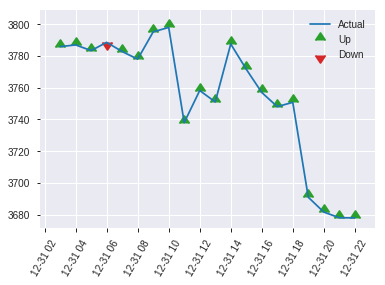


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2411209237729445
RMSE: 0.49104065389022983
LogLoss: 0.67503040256459
Mean Per-Class Error: 0.4214360288534549
AUC: 0.6056140850417615
pr_auc: 0.579343803360751
Gini: 0.21122817008352301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4048709571361542: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      79   360  0.82     (360.0/439.0)
1      26   406  0.0602   (26.0/432.0)
Total  105  766  0.4432   (386.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404871     0.677796  333
max f2                       0.338106     0.832363  382
max f0point5                 0.446942     0.58908   289
max accuracy                 0.446942     0.576349  289
max precision                0.710313     1         0
max recall                   0.289539     1         396
max specificity              0.710313     1         0
max absolute_mcc             0.446942     0.188125  289
max min_per_class_accuracy   0.520418     0.560185  190
max mean_per_class_accuracy  0.446942     0.578564  289

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.680741           1.56816   1.56816            0.777778         0.694395  0.777778                    0.694395            0.0162037       0.0162037                  56.8158   56.8158
    2        0.0206659                   0.669256           1.34414   1.45615            0.666667         0.675287  0.722222                    0.684841            0.0138889       0.0300926                  34.4136   45.6147
    3        0.0309989                   0.661262           1.12011   1.34414            0.555556         0.665125  0.666667                    0.678269            0.0115741       0.0416667                  12.0113   34.4136
    4        0.0401837                   0.654879           1.26013   1.32493            0.625            0.658071  0.657143                    0.673652            0.0115741       0.0532407                  26.0127   32.4934
    5        0.0505166                   0.65041            1.34414   1.32886            0.666667         0.652951  0.659091                    0.669418            0.0138889       0.0671296                  34.4136   32.8862
    6        0.101033                    0.628811           1.0081    1.16848            0.5              0.638785  0.579545                    0.654102            0.0509259       0.118056                   0.810185  16.8482
    7        0.150402                    0.614647           1.17221   1.16971            0.581395         0.6206    0.580153                    0.643105            0.0578704       0.175926                   17.2211   16.9706
    8        0.200918                    0.599072           1.46633   1.24429            0.727273         0.607271  0.617143                    0.634095            0.0740741       0.25                       46.633    24.4286
    9        0.300804                    0.56927            1.22826   1.23896            0.609195         0.583543  0.614504                    0.617309            0.122685        0.372685                   22.8262   23.8965
    10       0.400689                    0.544684           0.880641  1.14964            0.436782         0.557877  0.570201                    0.602493            0.087963        0.460648                   -11.9359  14.9641
    11       0.500574                    0.51895            1.01969   1.12371            0.505747         0.531441  0.557339                    0.588315            0.101852        0.5625                     1.96892   12.371
    12       0.600459                    0.495021           1.08921   1.11797            0.54023          0.506615  0.554493                    0.574725            0.108796        0.671296                   8.92135   11.7971
    13       0.700344                    0.470711           1.04286   1.10726            0.517241         0.48252   0.54918                     0.561574            0.104167        0.775463                   4.2864    10.7259
    14       0.80023                     0.436941           0.92699   1.08476            0.45977          0.453257  0.53802                     0.548054            0.0925926       0.868056                   -7.30098  8.47581
    15       0.900115                    0.393299           0.811116  1.05439            0.402299         0.418107  0.522959                    0.533634            0.0810185       0.949074                   -18.8884  5.43922
    16       1                           0.24964            0.509845  1                  0.252874         0.354062  0.495982                    0.515697          

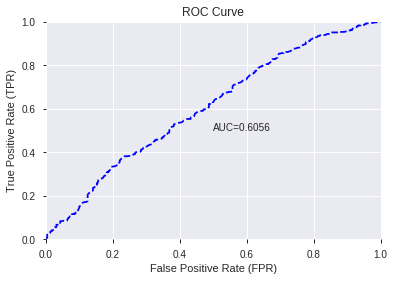

This function is available for GLM models only


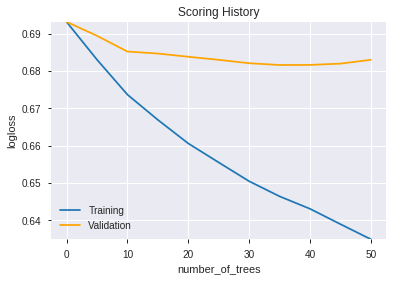

--2019-07-25 05:13:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

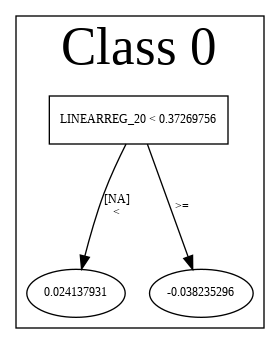

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_051140_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_051140_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [0]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_051408_model_5  0.593004  0.680713              0.457052  0.493842  0.243880
1  DeepLearning_grid_1_AutoML_20190725_051408_model_9  0.591150  0.681644              0.475220  0.494276  0.244308
2  DeepLearning_grid_1_AutoML_20190725_051408_model_6  0.590534  0.680682              0.465025  0.493727  0.243766
3  DeepLearning_grid_1_AutoML_20190725_051408_model_2  0.579853  0.730053              0.500000  0.507703  0.257762
4               DeepLearning_1_AutoML_20190725_051408  0.579170  0.728014              0.489805  0.513506  0.263688
5  DeepLearning_grid_1_AutoML_20190725_051408_model_1  0.577757  0.770297              0.500000  0.516043  0.266300
6  DeepLearning_grid_1_AutoML_20190725_051408_model_8  0.574132  0.686594              0.470683  0.496692  0.246703
7  DeepLearning_grid_1_AutoML_20190725_051408_model_3  0.572563  0.729828              0.500000  0.508767  0.258844
8  DeepLearning_grid_1_AutoML_20190725_051408_model_4  0.566605  0.720984              0.500000  0.509833  0.259930
9  DeepLearning_grid_1_AutoML_20190725_051408_model_7  0.555498  0.788524              0.500000  0.527633  0.278396

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.042141
1                   SIN             0.804925           0.804925    0.033921
2         days_in_month             0.752984           0.752984    0.031732
3    LINEARREG_ANGLE_20             0.750202           0.750202    0.031615
4             dayofyear             0.741652           0.741652    0.031254
5        STOCHRSI_fastd             0.740390           0.740390    0.031201
6                SAREXT             0.718646           0.718646    0.030285
7             CORREL_14             0.648840           0.648840    0.027343
8          HT_TRENDMODE             0.644540           0.644540    0.027162
9          STOCHF_fastk             0.640987           0.640987    0.027012
10       STOCHRSI_fastk             0.640056           0.640056    0.026973
11                  COS             0.639974           0.639974    0.026969
12   LINEARREG_ANGLE_14             0.590557           0.590557    0.024887
13            CORREL_30             0.559479           0.559479    0.023577
14            CORREL_24             0.544826           0.544826    0.022960
15            CORREL_12             0.533824           0.533824    0.022496
16             CORREL_8             0.523939           0.523939    0.022080
17            CORREL_20             0.510011           0.510011    0.021493
18    CDLGRAVESTONEDOJI             0.462908           0.462908    0.019508
19       CDLEVENINGSTAR             0.431290           0.431290    0.018175
20        CDLHANGINGMAN             0.422125           0.422125    0.017789
21     is_quarter_start             0.413607           0.413607    0.017430
22       CDLMATCHINGLOW             0.411503           0.411503    0.017341
23   CDLMORNINGDOJISTAR             0.400754           0.400754    0.016888
24         is_month_end             0.393044           0.393044    0.016563
25    CDLSTALLEDPATTERN             0.392215           0.392215    0.016528
26       is_quarter_end             0.389564           0.389564    0.016417
27    CDLINVERTEDHAMMER             0.385167           0.385167    0.016231
28    CDLDARKCLOUDCOVER             0.383507           0.383507    0.016161
29   CDLEVENINGDOJISTAR             0.380521           0.380521    0.016036
30       is_month_start             0.378461           0.378461    0.015949
31      CDLHOMINGPIGEON             0.375451           0.375451    0.015822
32  CDLGAPSIDESIDEWHITE             0.369979           0.369979    0.015591
33      CDLUNIQUE3RIVER             0.363201           0.363201    0.015306
34            CDL2CROWS             0.361247           0.361247    0.015223
35      CDLADVANCEBLOCK             0.358869           0.358869    0.015123
36     CDLDRAGONFLYDOJI             0.357736           0.357736    0.015075
37       CDLMORNINGSTAR             0.357207           0.357207    0.015053
38            CDLHAMMER             0.353947           0.353947    0.014916
39     CDLSTICKSANDWICH             0.350765           0.350765    0.014782
40         CDLTASUKIGAP             0.340333           0.340333    0.014342
41         CDLTHRUSTING             0.338229           0.338229    0.014253
42         CDLBREAKAWAY             0.336098           0.336098    0.014164
43   CDLIDENTICAL3CROWS             0.331388           0.331388    0.013965
44    CDL3WHITESOLDIERS             0.330203           0.330203    0.013915
45            CDLTAKURI             0.329764           0.329764    0.013897
46      CDLSHOOTINGSTAR             0.323892           0.323892    0.013649
47          CDLPIERCING             0.322753           0.322753    0.013601
48      CDLLADDERBOTTOM             0.313371           0.313371    0.013206
49  CDLRISEFALL3METHODS             0.284727           0.284727    0.011999

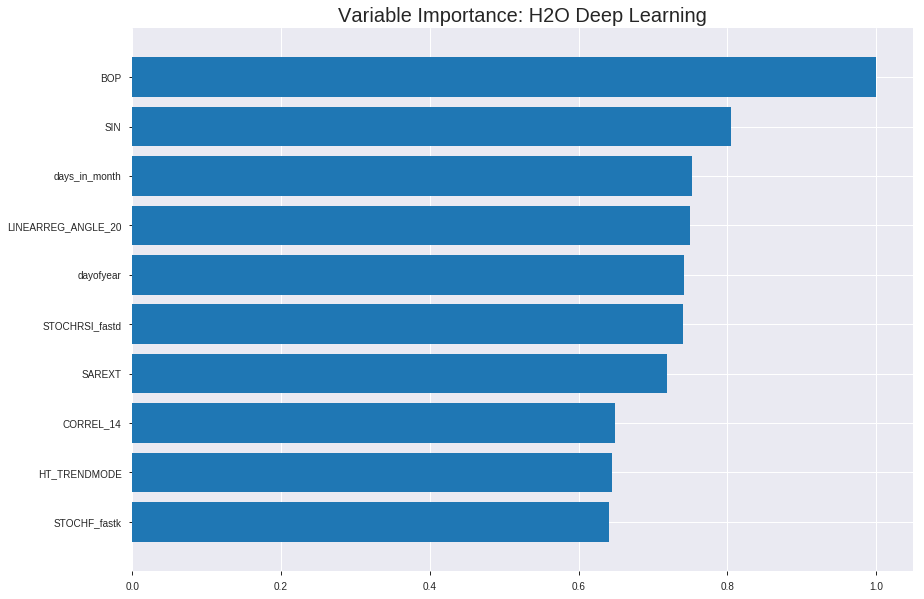

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_051408_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24357806171600177
RMSE: 0.49353628206647765
LogLoss: 0.679847510987092
Mean Per-Class Error: 0.4306021527189593
AUC: 0.5991724925234568
pr_auc: 0.5911927551701054
Gini: 0.19834498504691367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36597191520753225: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      424  2609  0.8602   (2609.0/3033.0)
1      165  2897  0.0539   (165.0/3062.0)
Total  589  5506  0.4551   (2774.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365972     0.676237  259
max f2                       0.180164     0.83543   366
max f0point5                 0.440364     0.586662  187
max accuracy                 0.486857     0.569647  118
max precision                0.70822      1         0
max recall                   0.0659625    1         396
max specificity              0.70822      1         0
max absolute_mcc             0.437904     0.159357  190
max min_per_class_accuracy   0.490828     0.553907  110
max mean_per_class_accuracy  0.486857     0.569398  118

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 46.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100082                   0.572708           1.40316   1.40316            0.704918         0.596018  0.704918                    0.596018            0.0140431       0.0140431                  40.316     40.316
    2        0.0200164                   0.553978           1.56632   1.48474            0.786885         0.562307  0.745902                    0.579162            0.015676        0.0297191                  56.6318    48.4739
    3        0.0300246                   0.543318           1.46842   1.4793             0.737705         0.547731  0.743169                    0.568685            0.0146963       0.0444154                  46.8423    47.93
    4        0.0400328                   0.534617           1.17474   1.40316            0.590164         0.539219  0.704918                    0.561319            0.011757        0.0561724                  17.4738    40.316
    5        0.050041                    0.528702           1.46842   1.41621            0.737705         0.531292  0.711475                    0.555313            0.0146963       0.0708687                  46.8423    41.6212
    6        0.100082                    0.51229            1.22042   1.31832            0.613115         0.519499  0.662295                    0.537406            0.0610712       0.13194                    22.0423    31.8318
    7        0.150123                    0.501679           1.16169   1.26611            0.583607         0.506813  0.636066                    0.527208            0.0581319       0.190072                   16.1686    26.6107
    8        0.2                         0.494941           1.09348   1.22306            0.549342         0.498165  0.614438                    0.519965            0.0545395       0.244611                   9.34814    22.3057
    9        0.50927                     0.490829           1.06971   1.12993            0.537401         0.491051  0.567655                    0.502406            0.33083         0.575441                   6.97114    12.9933
    10       0.6                         0.480452           1.01506   1.11256            0.509946         0.486167  0.558928                    0.49995             0.0920967       0.667538                   1.50618    11.2563
    11       0.699918                    0.460973           0.960945  1.09092            0.482759         0.471265  0.548054                    0.495855            0.0960157       0.763553                   -3.90549   9.09182
    12       0.8                         0.428711           0.992001  1.07854            0.498361         0.446074  0.541838                    0.489628            0.0992815       0.862835                   -0.799863  7.85434
    13       0.899918                    0.368351           0.794251  1.04698            0.399015         0.404069  0.52598                     0.480128            0.0793599       0.942195                   -20.5749   4.69784
    14       1                           0.0509009          0.57758   1                  0.290164         0.279669  0.502379                    0.460066            0.0578054       1                          -42.242    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2469464985848184
RMSE: 0.4969371173345964
LogLoss: 0.6873201542907611
Mean Per-Class Error: 0.43484568715378535
AUC: 0.5749360327090478
pr_auc: 0.54066990291521
Gini: 0.1498720654180956
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22542522420747557: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   875   0.9809   (875.0/892.0)
1      4    846   0.0047   (4.0/850.0)
Total  21   1721  0.5046   (879.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.225425     0.65811   384
max f2                       0.115556     0.826687  398
max f0point5                 0.441972     0.557391  228
max accuracy                 0.490455     0.566016  155
max precision                0.589128     0.595745  30
max recall                   0.115556     1         398
max specificity              0.684631     0.998879  0
max absolute_mcc             0.490455     0.130635  155
max min_per_class_accuracy   0.484853     0.558296  165
max mean_per_class_accuracy  0.490455     0.565154  155

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 46.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.617396           0.796993  0.796993           0.388889         0.641384  0.388889                    0.641384            0.00823529      0.00823529                 -20.3007  -20.3007
    2        0.0200918                   0.596529           1.44664   1.11254            0.705882         0.605141  0.542857                    0.62378             0.0141176       0.0223529                  44.6644   11.2538
    3        0.0304248                   0.585916           1.13856   1.12138            0.555556         0.590772  0.54717                     0.61257             0.0117647       0.0341176                  13.8562   12.1376
    4        0.0401837                   0.578834           1.32609   1.17109            0.647059         0.582465  0.571429                    0.605259            0.0129412       0.0470588                  32.609    17.1092
    5        0.0505166                   0.571687           1.02471   1.14115            0.5              0.574694  0.556818                    0.599007            0.0105882       0.0576471                  2.47059   14.115
    6        0.100459                    0.544278           1.20138   1.17109            0.586207         0.556941  0.571429                    0.578094            0.06            0.117647                   20.1379   17.1092
    7        0.150402                    0.530535           1.22494   1.18897            0.597701         0.536451  0.580153                    0.564266            0.0611765       0.178824                   22.4936   18.8972
    8        0.200344                    0.522046           1.13071   1.17445            0.551724         0.526259  0.573066                    0.554792            0.0564706       0.235294                   13.071    17.4448
    9        0.30023                     0.504058           1.1896    1.17949            0.58046          0.51268   0.575526                    0.540781            0.118824        0.354118                   18.9601   17.9489
    10       0.400115                    0.490845           1.0836    1.15555            0.528736         0.497662  0.563845                    0.530017            0.108235        0.462353                   8.3597    15.5551
    11       0.5                         0.484367           0.977593  1.12               0.477011         0.489603  0.546498                    0.521943            0.0976471       0.56                       -2.2407   12
    12       0.599885                    0.464508           0.906924  1.08452            0.442529         0.474775  0.529187                    0.514089            0.0905882       0.650588                   -9.30764  8.45212
    13       0.69977                     0.442282           1.00115   1.07262            0.488506         0.454314  0.52338                     0.505557            0.1             0.750588                   0.114943  7.26208
    14       0.799656                    0.417061           0.80092   1.03868            0.390805         0.429424  0.50682                     0.496047            0.08            0.830588                   -19.908   3.86825
    15       0.899541                    0.376486           0.989371  1.03321            0.482759         0.399918  0.504148                    0.485373            0.0988235       0.929412                   -1.06288  3.3207
    16       1                           0.111242           0.702655  1                  0.342857         0.304453  0.487945                    0.467198            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:20:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:20:30  3 min 10.544 sec  1106 obs/sec      0.401641  1             2448       0.497804         0.688781            0.00874032     0.560244        0.549217           1.27263          0.488761                         0.502743           0.698907              -0.0115897       0.573121          0.551495             1.25242            0.505166
    2019-07-25 05:20:52  3 min 32.444 sec  2856 obs/sec      10.308    26            62827      0.493536         0.679848            0.0256657      0.599172        0.591193           1.40316          0.455127                         0.496937           0.68732               0.0116395        0.574936          0.54067              0.796993           0.504592
    2019-07-25 05:21:14  3 min 53.837 sec  3042 obs/sec      20.6046   52            125585     0.488645         0.669554            0.0448811      0.618684        0.611027           1.72948          0.455947                         0.498312           0.690666              0.00616413       0.571765          0.539645             0.91085            0.509759
    2019-07-25 05:21:35  4 min 15.630 sec  3256 obs/sec      32.5457   82            198366     0.481427         0.653913            0.0728907      0.642569        0.639101           1.9579           0.421165                         0.499488           0.694978              0.00146734       0.564588          0.525495             0.683137           0.481056
    2019-07-25 05:21:57  4 min 37.339 sec  3396 obs/sec      44.8254   113           273211     0.472048         0.633285            0.108663       0.678226        0.682071           1.9579           0.400984                         0.501489           0.700693              -0.00654925      0.573463          0.537934             1.25242            0.505741
    2019-07-25 05:22:19  4 min 59.541 sec  3510 obs/sec      57.9124   146           352976     0.465729         0.618207            0.132366       0.702898        0.707265           1.9579           0.371452                         0.503815           0.709198              -0.0159087       0.567196          0.532649             1.13856            0.490815
    2019-07-25 05:22:21  5 min  1.734 sec  3510 obs/sec      57.9124   146           352976     0.493536         0.679848            0.0256657      0.599172        0.591193           1.40316          0.455127                         0.496937           0.68732               0.0116395        0.574936          0.54067              0.796993           0.504592

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.04214135468667421
SIN                  0.8049251437187195     0.8049251437187195   0.03392063597767277
days_in_month        0.7529836297035217     0.7529836297035217   0.03173175021259546
LINEARREG_ANGLE_20   0.7502022385597229     0.7502022385597229   0.03161453862188226
dayofyear            0.7416518330574036     0.7416518330574036   0.03125421295089413
---                  ---                    ---                  ---
CDLTAKURI            0.32976412773132324    0.32976412773132324  0.013896707069667431
CDLSHOOTINGSTAR      0.32389235496520996    0.32389235496520996  0.013649262610891097
CDLPIERCING          0.32275253534317017    0.32275253534317017  0.013601229067919886
CDLLADDERBOTTOM      0.3133707642555237     0.3133707642555237   0.013205868524926192
CDLRISEFALL3METHODS  0.2847267985343933     0.2847267985343933   0.011998773005839099


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5763490241102182)

('F1', 0.6737184703010577)

('auc', 0.5930038808740403)

('logloss', 0.6807132435444583)

('mean_per_class_error', 0.42300472454231)

('rmse', 0.49384220043084065)

('mse', 0.2438801189263746)

deeplearning prediction progress: |███████████████████████████████████████| 100%


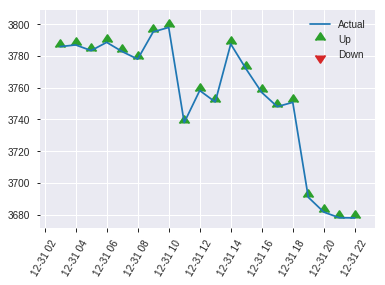


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2438801189263746
RMSE: 0.49384220043084065
LogLoss: 0.6807132435444583
Mean Per-Class Error: 0.42300472454231
AUC: 0.5930038808740403
pr_auc: 0.5508398907783498
Gini: 0.18600776174808065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.341657663903026: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   383  0.8724   (383.0/439.0)
1      18   414  0.0417   (18.0/432.0)
Total  74   797  0.4604   (401.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341658     0.673718  336
max f2                       0.184871     0.832049  396
max f0point5                 0.428712     0.585885  257
max accuracy                 0.481075     0.576349  186
max precision                0.517902     0.594595  122
max recall                   0.184871     1         396
max specificity              0.699987     0.997722  0
max absolute_mcc             0.428712     0.172817  257
max min_per_class_accuracy   0.491365     0.546296  170
max mean_per_class_accuracy  0.477363     0.576995  191

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 47.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.632797           1.12011   1.12011            0.555556         0.661369  0.555556                    0.661369            0.0115741       0.0115741                  12.0113   12.0113
    2        0.0206659                   0.624727           1.12011   1.12011            0.555556         0.627668  0.555556                    0.644518            0.0115741       0.0231481                  12.0113   12.0113
    3        0.0309989                   0.61105            0.896091  1.04544            0.444444         0.617368  0.518519                    0.635468            0.00925926      0.0324074                  -10.3909  4.5439
    4        0.0401837                   0.60352            1.26013   1.09451            0.625            0.606779  0.542857                    0.628911            0.0115741       0.0439815                  26.0127   9.45106
    5        0.0505166                   0.59407            1.12011   1.09975            0.555556         0.597468  0.545455                    0.622479            0.0115741       0.0555556                  12.0113   9.97475
    6        0.101033                    0.563471           1.09975   1.09975            0.545455         0.577903  0.545455                    0.600191            0.0555556       0.111111                   9.97475   9.97475
    7        0.150402                    0.547217           0.937769  1.04658            0.465116         0.554956  0.519084                    0.585343            0.0462963       0.157407                   -6.22308  4.6579
    8        0.200918                    0.532426           1.37468   1.12907            0.681818         0.539461  0.56                        0.573807            0.0694444       0.226852                   37.4684   12.9074
    9        0.300804                    0.517087           1.32096   1.19279            0.655172         0.524402  0.591603                    0.557401            0.131944        0.358796                   32.0961   19.2792
    10       0.400689                    0.503219           1.06604   1.16119            0.528736         0.509202  0.575931                    0.545386            0.106481        0.465278                   6.60387   16.1195
    11       0.520092                    0.490829           1.04688   1.13495            0.519231         0.495174  0.562914                    0.533858            0.125           0.590278                   4.6875    13.4949
    12       0.600459                    0.471604           1.06571   1.12568            0.528571         0.482183  0.558317                    0.526942            0.0856481       0.675926                   6.57077   12.5682
    13       0.700344                    0.442324           0.903815  1.09404            0.448276         0.456837  0.542623                    0.516943            0.0902778       0.766204                   -9.61845  9.40384
    14       0.80023                     0.399217           0.950165  1.07608            0.471264         0.421636  0.533716                    0.505047            0.0949074       0.861111                   -4.9835   7.608
    15       0.900115                    0.354782           0.857466  1.05182            0.425287         0.379377  0.521684                    0.491101            0.0856481       0.946759                   -14.2534  5.18206
    16       1                           0.0979162          0.533019  1                  0.264368         0.286043  0.495982                    0.470619            0

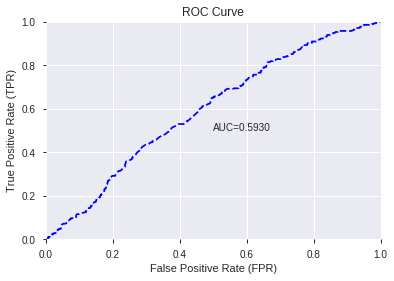

This function is available for GLM models only


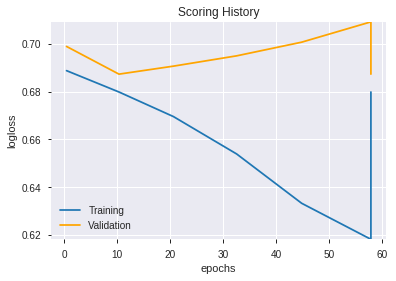

--2019-07-25 05:38:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


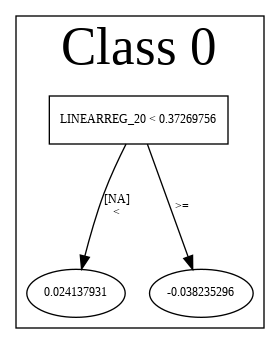

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_051408_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_051408_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SIN',
 'days_in_month',
 'LINEARREG_ANGLE_20',
 'dayofyear',
 'STOCHRSI_fastd',
 'SAREXT',
 'CORREL_14',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'COS',
 'LINEARREG_ANGLE_14',
 'CORREL_30',
 'CORREL_24',
 'CORREL_12',
 'CORREL_8',
 'CORREL_20',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGSTAR',
 'CDLHANGINGMAN',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'CDLSTALLEDPATTERN',
 'is_quarter_end',
 'CDLINVERTEDHAMMER',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'CDLGAPSIDESIDEWHITE',
 'CDLUNIQUE3RIVER',
 'CDL2CROWS',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLMORNINGSTAR',
 'CDLHAMMER',
 'CDLSTICKSANDWICH',
 'CDLTASUKIGAP',
 'CDLTHRUSTING',
 'CDLBREAKAWAY',
 'CDLIDENTICAL3CROWS',
 'CDL3WHITESOLDIERS',
 'CDLTAKURI',
 'CDLSHOOTINGSTAR',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDLRISEFALL3METHODS']

In [0]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_053859_model_1  0.592854  0.680196              0.476359  0.493617  0.243658

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.168925           1.000000    0.161481
1    LINEARREG_ANGLE_20             0.067090           0.397161    0.064134
2          STOCHF_fastk             0.052003           0.307848    0.049711
3         CDLHANGINGMAN             0.050355           0.298090    0.048136
4        STOCHRSI_fastd             0.049700           0.294213    0.047510
5     CDLGRAVESTONEDOJI             0.042070           0.249044    0.040216
6        STOCHRSI_fastk             0.041322           0.244615    0.039501
7           CDLPIERCING             0.039360           0.233004    0.037626
8          HT_TRENDMODE             0.033416           0.197817    0.031944
9    CDLIDENTICAL3CROWS             0.033391           0.197668    0.031919
10       CDLMATCHINGLOW             0.031558           0.186815    0.030167
11    CDL3WHITESOLDIERS             0.027950           0.165456    0.026718
12            CORREL_14             0.027667           0.163785    0.026448
13   LINEARREG_ANGLE_14             0.027650           0.163684    0.026432
14      CDLLADDERBOTTOM             0.026383           0.156181    0.025220
15         CDLBREAKAWAY             0.023745           0.140567    0.022699
16            CORREL_30             0.023512           0.139185    0.022476
17            CORREL_12             0.018650           0.110404    0.017828
18   CDLEVENINGDOJISTAR             0.018334           0.108536    0.017526
19     CDLSTICKSANDWICH             0.017348           0.102700    0.016584
20            CORREL_20             0.016259           0.096252    0.015543
21    CDLSTALLEDPATTERN             0.015209           0.090036    0.014539
22            dayofyear             0.014867           0.088009    0.014212
23    CDLINVERTEDHAMMER             0.014360           0.085011    0.013728
24        days_in_month             0.013050           0.077256    0.012475
25                  COS             0.013007           0.077000    0.012434
26       CDLEVENINGSTAR             0.011966           0.070834    0.011438
27            CDL2CROWS             0.011700           0.069260    0.011184
28            CORREL_24             0.010532           0.062350    0.010068
29      CDLSHOOTINGSTAR             0.010428           0.061729    0.009968
30               SAREXT             0.008794           0.052059    0.008406
31                  SIN             0.008642           0.051157    0.008261
32             CORREL_8             0.008551           0.050620    0.008174
33            CDLHAMMER             0.007967           0.047161    0.007616
34         CDLTASUKIGAP             0.007065           0.041825    0.006754
35      CDLHOMINGPIGEON             0.006165           0.036495    0.005893
36     CDLDRAGONFLYDOJI             0.006041           0.035762    0.005775
37            CDLTAKURI             0.005715           0.033833    0.005463
38       is_quarter_end             0.005228           0.030946    0.004997
39  CDLRISEFALL3METHODS             0.005056           0.029930    0.004833
40   CDLMORNINGDOJISTAR             0.004864           0.028795    0.004650
41     is_quarter_start             0.003749           0.022194    0.003584
42  CDLGAPSIDESIDEWHITE             0.003744           0.022165    0.003579
43         is_month_end             0.003466           0.020518    0.003313
44    CDLDARKCLOUDCOVER             0.003203           0.018962    0.003062
45       is_month_start             0.001635           0.009681    0.001563
46      CDLADVANCEBLOCK             0.001603           0.009488    0.001532
47       CDLMORNINGSTAR             0.001201           0.007109    0.001148
48         CDLTHRUSTING             0.000802           0.004746    0.000766
49      CDLUNIQUE3RIVER             0.000801           0.004742    0.000766

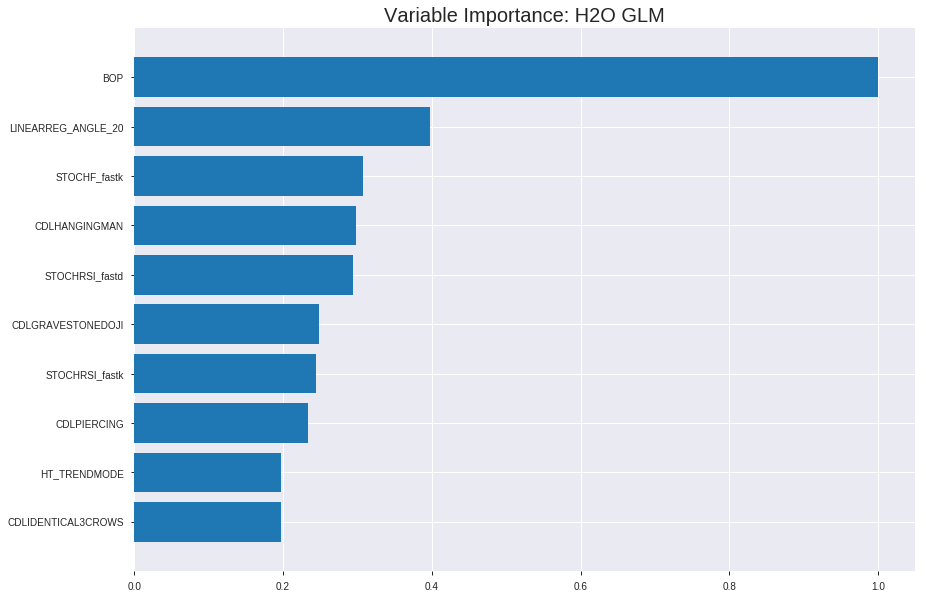

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_053859_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24329784644081273
RMSE: 0.4932523151905247
LogLoss: 0.6795076731624822
Null degrees of freedom: 6094
Residual degrees of freedom: 6044
Null deviance: 8449.32614855268
Residual deviance: 8283.198535850657
AIC: 8385.198535850657
AUC: 0.5936162586036507
pr_auc: 0.5765752252792248
Gini: 0.1872325172073015
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3721338425143432: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      93   2940  0.9693   (2940.0/3033.0)
1      29   3033  0.0095   (29.0/3062.0)
Total  122  5973  0.4871   (2969.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372134     0.671389  366
max f2                       0.330757     0.834879  388
max f0point5                 0.46198      0.579073  258
max accuracy                 0.502855     0.569975  200
max precision                0.897357     1         0
max recall                   0.302739     1         396
max specificity              0.897357     1         0
max absolute_mcc             0.502855     0.139999  200
max min_per_class_accuracy   0.501689     0.567095  202
max mean_per_class_accuracy  0.502855     0.569998  200

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.643719           1.27263   1.27263            0.639344         0.681325  0.639344                    0.681325            0.0127368       0.0127368                  27.2633   27.2633
    2        0.0200164                   0.631501           1.17474   1.22369            0.590164         0.636631  0.614754                    0.658978            0.011757        0.0244938                  17.4738   22.3686
    3        0.0300246                   0.622539           1.20737   1.21825            0.606557         0.626622  0.612022                    0.648192            0.0120836       0.0365774                  20.737    21.8247
    4        0.0400328                   0.617085           1.27263   1.23184            0.639344         0.619617  0.618852                    0.641049            0.0127368       0.0493142                  27.2633   23.1844
    5        0.050041                    0.612378           1.17474   1.22042            0.590164         0.614608  0.613115                    0.63576             0.011757        0.0610712                  17.4738   22.0423
    6        0.100082                    0.596779           1.20084   1.21063            0.603279         0.604478  0.608197                    0.620119            0.0600914       0.121163                   20.0844   21.0633
    7        0.150123                    0.582747           1.27916   1.23348            0.642623         0.589744  0.619672                    0.609994            0.0640105       0.185173                   27.916    23.3475
    8        0.2                         0.569975           1.21134   1.22796            0.608553         0.576341  0.616899                    0.601601            0.060418        0.245591                   21.1342   22.7956
    9        0.300082                    0.54695            1.09642   1.18409            0.55082          0.558137  0.594861                    0.587105            0.109732        0.355323                   9.64226   18.4087
    10       0.4                         0.524353           1.08842   1.16019            0.546798         0.535944  0.582855                    0.574326            0.108752        0.464076                   8.84174   16.0189
    11       0.500082                    0.501739           1.04421   1.13698            0.52459          0.513066  0.571194                    0.562066            0.104507        0.568583                   4.4212    13.6979
    12       0.6                         0.479963           0.941334  1.1044             0.472906         0.490638  0.554826                    0.550171            0.0940562       0.662639                   -5.86661  10.4398
    13       0.699918                    0.457874           0.974019  1.08579            0.489327         0.468829  0.545476                    0.538559            0.097322        0.759961                   -2.59809  8.57855
    14       0.8                         0.435285           0.903896  1.06303            0.454098         0.446957  0.534044                    0.527099            0.0904637       0.850425                   -9.6104   6.30307
    15       0.899918                    0.408121           0.797519  1.03355            0.400657         0.421843  0.519234                    0.515412            0.0796865       0.930111                   -20.2481  3.35509
    16       1                           0.106995           0.698317  1                  0.35082          0.385185  0.502379                    0.502379         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24296453952698366
RMSE: 0.49291433284799463
LogLoss: 0.6787138855161242
Null degrees of freedom: 1741
Residual degrees of freedom: 1691
Null deviance: 2415.3638887467546
Residual deviance: 2364.639177138177
AIC: 2466.639177138177
AUC: 0.5979972302822474
pr_auc: 0.5917864168450272
Gini: 0.19599446056449477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4004943922307882: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   832   0.9327   (832.0/892.0)
1      25   825   0.0294   (25.0/850.0)
Total  85   1657  0.492    (857.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400494     0.658157  361
max f2                       0.334006     0.826848  397
max f0point5                 0.491544     0.564191  230
max accuracy                 0.561449     0.579793  126
max precision                0.905944     1         0
max recall                   0.334006     1         397
max specificity              0.905944     1         0
max absolute_mcc             0.581633     0.166675  95
max min_per_class_accuracy   0.510549     0.565022  200
max mean_per_class_accuracy  0.561449     0.574757  126

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.647382           1.48013   1.48013            0.722222         0.708079  0.722222                    0.708079            0.0152941       0.0152941                  48.0131   48.0131
    2        0.0200918                   0.633379           1.68775   1.58097            0.823529         0.640097  0.771429                    0.67506             0.0164706       0.0317647                  68.7751   58.0975
    3        0.0304248                   0.627929           1.36627   1.50806            0.666667         0.630333  0.735849                    0.659869            0.0141176       0.0458824                  36.6275   50.8058
    4        0.0401837                   0.622425           1.68775   1.5517             0.823529         0.625122  0.757143                    0.651431            0.0164706       0.0623529                  68.7751   55.1697
    5        0.0505166                   0.618719           1.48013   1.53706            0.722222         0.620532  0.75                        0.64511             0.0152941       0.0776471                  48.0131   53.7059
    6        0.100459                    0.603484           1.22494   1.38189            0.597701         0.610112  0.674286                    0.627711            0.0611765       0.138824                   22.4936   38.1889
    7        0.150402                    0.590969           1.38983   1.38453            0.678161         0.596824  0.675573                    0.617455            0.0694118       0.208235                   38.9831   38.4526
    8        0.200344                    0.5786             1.10715   1.31538            0.54023          0.584792  0.641834                    0.609313            0.0552941       0.263529                   10.7153   31.5382
    9        0.30023                     0.558546           1.07182   1.23435            0.522989         0.568371  0.602294                    0.595692            0.107059        0.370588                   7.18188   23.4349
    10       0.400115                    0.534712           0.989371  1.17319            0.482759         0.547487  0.572453                    0.583658            0.0988235       0.469412                   -1.06288  17.3193
    11       0.5                         0.510228           0.989371  1.13647            0.482759         0.52221   0.554535                    0.571382            0.0988235       0.568235                   -1.06288  13.6471
    12       0.599885                    0.487283           0.965815  1.10806            0.471264         0.499875  0.54067                     0.559476            0.0964706       0.664706                   -3.41853  10.8055
    13       0.69977                     0.464478           0.871589  1.0743             0.425287         0.476063  0.5242                      0.547569            0.0870588       0.751765                   -12.8411  7.4302
    14       0.799656                    0.445104           0.906924  1.05339            0.442529         0.455192  0.513999                    0.536031            0.0905882       0.842353                   -9.30764  5.33947
    15       0.899541                    0.418526           0.848032  1.03059            0.413793         0.431266  0.502872                    0.524397            0.0847059       0.927059                   -15.1968  3.05912
    16       1                           0.298785           0.726077  1                  0.354286         0.395955  0.487945                    0.511494          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:39:00  0.000 sec   2            6.8       48            1.38235           1.38205
    2019-07-25 05:39:00  0.018 sec   4            4.2       50            1.38044           1.37984
    2019-07-25 05:39:00  0.037 sec   6            2.6       50            1.37791           1.3769
    2019-07-25 05:39:00  0.055 sec   8            1.6       50            1.37485           1.37331
    2019-07-25 05:39:00  0.076 sec   10           1         51            1.37151           1.36938
    2019-07-25 05:39:00  0.098 sec   12           0.62      51            1.36825           1.36559
    2019-07-25 05:39:00  0.118 sec   14           0.39      51            1.36538           1.36237
    2019-07-25 05:39:00  0.138 sec   16           0.24      51            1.36306           1.35999
    2019-07-25 05:39:00  0.160 sec   18           0.15      51            1.36127           1.35847
    2019-07-25 05:39:00  0.179 sec   20           0.093     51            1.35996           1.35769
    2019-07-25 05:39:00  0.197 sec   22           0.058     51            1.35902           1.35743
    2019-07-25 05:39:00  0.216 sec   24           0.036     51            1.35837           1.35749
    2019-07-25 05:39:00  0.227 sec   25           0.022     51            1.35795           1.35775
    2019-07-25 05:39:00  0.238 sec   26           0.014     51            1.3577            1.35805
    2019-07-25 05:39:00  0.250 sec   27           0.0086    51            1.35755           1.35835
    2019-07-25 05:39:00  0.262 sec   28           0.0053    51            1.35747           1.35859

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5717566016073479)

('F1', 0.6661341853035143)

('auc', 0.5928536024635113)

('logloss', 0.6801961339938776)

('mean_per_class_error', 0.42933223656458286)

('rmse', 0.4936172378377395)

('mse', 0.24365797749055948)

glm prediction progress: |████████████████████████████████████████████████| 100%


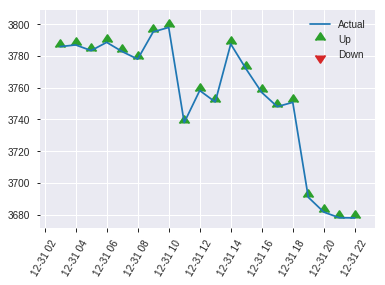


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24365797749055948
RMSE: 0.4936172378377395
LogLoss: 0.6801961339938776
Null degrees of freedom: 870
Residual degrees of freedom: 820
Null deviance: 1207.5487194139707
Residual deviance: 1184.9016654173347
AIC: 1286.9016654173347
AUC: 0.5928536024635113
pr_auc: 0.5880123641502054
Gini: 0.18570720492702253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4064915932819905: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      36   403  0.918    (403.0/439.0)
1      15   417  0.0347   (15.0/432.0)
Total  51   820  0.4799   (418.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406492     0.666134  366
max f2                       0.331145     0.831089  399
max f0point5                 0.439222     0.57362   316
max accuracy                 0.541602     0.571757  153
max precision                0.892941     1         0
max recall                   0.331145     1         399
max specificity              0.892941     1         0
max absolute_mcc             0.541602     0.146873  153
max min_per_class_accuracy   0.512793     0.564815  198
max mean_per_class_accuracy  0.541602     0.570668  153

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010333                    0.652194           1.56816   1.56816            0.777778         0.69105   0.777778                    0.69105             0.0162037       0.0162037                  56.8158    56.8158
    2        0.0206659                   0.641              1.56816   1.56816            0.777778         0.646661  0.777778                    0.668855            0.0162037       0.0324074                  56.8158    56.8158
    3        0.0309989                   0.633865           1.79218   1.64283            0.888889         0.637725  0.814815                    0.658479            0.0185185       0.0509259                  79.2181    64.2833
    4        0.0401837                   0.630615           1.26013   1.55536            0.625            0.632455  0.771429                    0.65253             0.0115741       0.0625                     26.0127    55.5357
    5        0.0505166                   0.623834           0.448045  1.32886            0.222222         0.628228  0.659091                    0.647559            0.00462963      0.0671296                  -55.1955   32.8862
    6        0.101033                    0.602851           1.37468   1.35177            0.681818         0.612306  0.670455                    0.629933            0.0694444       0.136574                   37.4684    35.1773
    7        0.150402                    0.593215           1.07843   1.26205            0.534884         0.598102  0.625954                    0.619484            0.0532407       0.189815                   7.84345    26.2051
    8        0.200918                    0.578174           1.19139   1.24429            0.590909         0.585765  0.617143                    0.611006            0.0601852       0.25                       19.1393    24.4286
    9        0.300804                    0.555226           1.04286   1.1774             0.517241         0.566759  0.583969                    0.596314            0.104167        0.354167                   4.2864     17.7401
    10       0.400689                    0.533661           1.13556   1.16697            0.563218         0.543884  0.578797                    0.583244            0.113426        0.467593                   13.5563    16.6972
    11       0.500574                    0.512557           0.996514  1.13296            0.494253         0.522881  0.561927                    0.571199            0.099537        0.56713                    -0.348553  13.2959
    12       0.600459                    0.491386           0.834291  1.08328            0.413793         0.502622  0.537285                    0.559791            0.0833333       0.650463                   -16.5709   8.32758
    13       0.700344                    0.466484           1.08921   1.08412            0.54023          0.47906   0.537705                    0.548277            0.108796        0.759259                   8.92135    8.41226
    14       0.80023                     0.441414           0.92699   1.06451            0.45977          0.453434  0.527977                    0.536439            0.0925926       0.851852                   -7.30098   6.45093
    15       0.900115                    0.419473           0.787942  1.03382            0.390805         0.430945  0.512755                    0.524732            0.0787037       0.930556                   -21.2058   3.38187
    16       1                           0.331145           0.695243  1                  0.344828         0.399067  0.495982                    

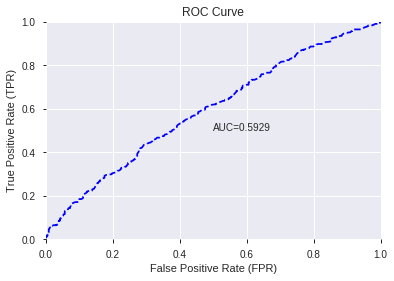

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


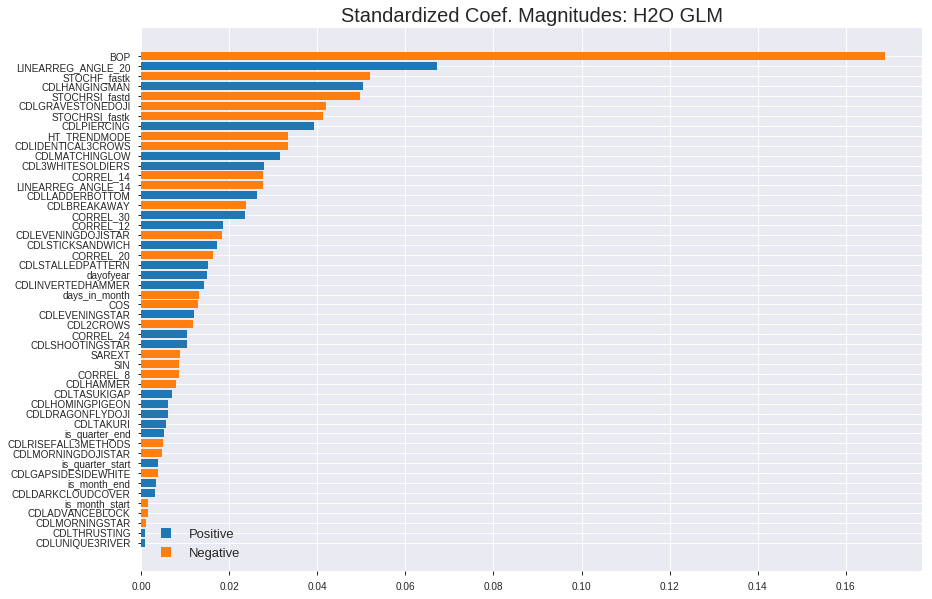

'log_likelihood'
--2019-07-25 05:39:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


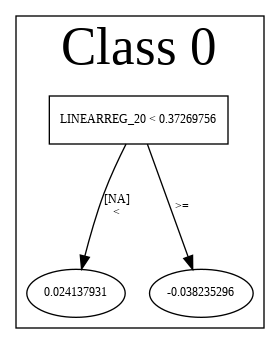

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_053859_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_053859_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'LINEARREG_ANGLE_20',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'STOCHRSI_fastd',
 'CDLGRAVESTONEDOJI',
 'STOCHRSI_fastk',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLIDENTICAL3CROWS',
 'CDLMATCHINGLOW',
 'CDL3WHITESOLDIERS',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'CDLLADDERBOTTOM',
 'CDLBREAKAWAY',
 'CORREL_30',
 'CORREL_12',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CORREL_20',
 'CDLSTALLEDPATTERN',
 'dayofyear',
 'CDLINVERTEDHAMMER',
 'days_in_month',
 'COS',
 'CDLEVENINGSTAR',
 'CDL2CROWS',
 'CORREL_24',
 'CDLSHOOTINGSTAR',
 'SAREXT',
 'SIN',
 'CORREL_8',
 'CDLHAMMER',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_quarter_end',
 'CDLRISEFALL3METHODS',
 'CDLMORNINGDOJISTAR',
 'is_quarter_start',
 'CDLGAPSIDESIDEWHITE',
 'is_month_end',
 'CDLDARKCLOUDCOVER',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLUNIQUE3RIVER']

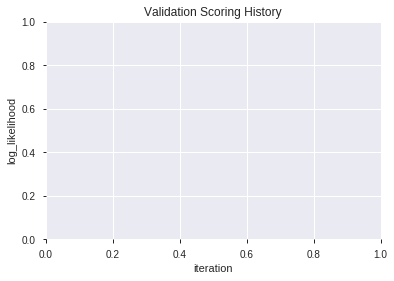

In [0]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_053921_model_6  0.603386  0.676203              0.461516  0.491717  0.241786
1  XGBoost_grid_1_AutoML_20190725_053921_model_4  0.603112  0.675719              0.426596  0.491399  0.241473
2  XGBoost_grid_1_AutoML_20190725_053921_model_2  0.594016  0.679160              0.454793  0.493107  0.243155
3  XGBoost_grid_1_AutoML_20190725_053921_model_3  0.589060  0.681122              0.451486  0.494046  0.244082
4               XGBoost_3_AutoML_20190725_053921  0.584973  0.681452              0.442467  0.494249  0.244282
5               XGBoost_2_AutoML_20190725_053921  0.584683  0.686849              0.472850  0.496614  0.246626
6  XGBoost_grid_1_AutoML_20190725_053921_model_1  0.582297  0.683222              0.479628  0.495092  0.245116
7  XGBoost_grid_1_AutoML_20190725_053921_model_5  0.580700  0.704025              0.476303  0.503676  0.253690
8               XGBoost_1_AutoML_20190725_053921  0.579708  0.686370              0.478397  0.496631  0.246642
9  XGBoost_grid_1_AutoML_20190725_053921_model_7  0.574723  0.687621              0.470572  0.497303  0.247310

variable  relative_importance  scaled_importance  percentage
0                  BOP          1169.477783           1.000000    0.126315
1       STOCHRSI_fastd           854.358459           0.730547    0.092279
2         STOCHF_fastk           764.556763           0.653759    0.082580
3                  SIN           733.390137           0.627109    0.079213
4            dayofyear           555.299316           0.474827    0.059978
5                  COS           534.697876           0.457211    0.057753
6            CORREL_14           527.577942           0.451123    0.056984
7             CORREL_8           519.193909           0.443954    0.056078
8   LINEARREG_ANGLE_14           489.336609           0.418423    0.052853
9       STOCHRSI_fastk           461.035736           0.394224    0.049796
10              SAREXT           445.791016           0.381188    0.048150
11           CORREL_20           439.435333           0.375753    0.047463
12  LINEARREG_ANGLE_20           419.889954           0.359041    0.045352
13           CORREL_30           409.435242           0.350101    0.044223
14           CORREL_24           369.513855           0.315965    0.039911
15           CORREL_12           367.334534           0.314101    0.039676
16       days_in_month            76.587738           0.065489    0.008272
17        HT_TRENDMODE            41.908871           0.035836    0.004527
18   CDLGRAVESTONEDOJI            26.082905           0.022303    0.002817
19       CDLHANGINGMAN            21.575125           0.018449    0.002330
20        is_month_end            15.889920           0.013587    0.001716
21           CDLHAMMER             6.156636           0.005264    0.000665
22      is_month_start             5.771491           0.004935    0.000623
23    CDLDRAGONFLYDOJI             4.106755           0.003512    0.000444

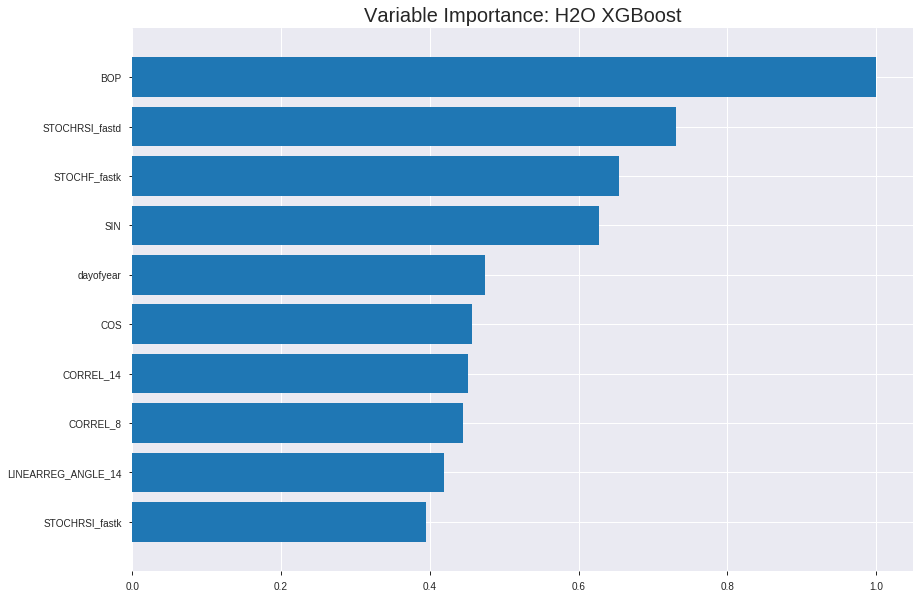

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_053921_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22014699244832717
RMSE: 0.46919824429373896
LogLoss: 0.6320532457317191
Mean Per-Class Error: 0.31957470653208775
AUC: 0.7516765826291805
pr_auc: 0.7526284659818958
Gini: 0.5033531652583609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4546116767451167: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1318  1715  0.5654   (1715.0/3033.0)
1      383   2679  0.1251   (383.0/3062.0)
Total  1701  4394  0.3442   (2098.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454612     0.718616  248
max f2                       0.347037     0.84219   347
max f0point5                 0.525692     0.689501  163
max accuracy                 0.525692     0.680066  163
max precision                0.715036     1         0
max recall                   0.31744      1         364
max specificity              0.715036     1         0
max absolute_mcc             0.525692     0.364946  163
max min_per_class_accuracy   0.507434     0.675898  186
max mean_per_class_accuracy  0.525692     0.680425  163

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.668343           1.99053   1.99053            1                0.683798  1                           0.683798            0.0199216       0.0199216                  99.0529   99.0529
    2        0.0200164                   0.655664           1.92527   1.9579             0.967213         0.660977  0.983607                    0.672388            0.0192685       0.0391901                  92.5266   95.7897
    3        0.0300246                   0.646301           1.72948   1.88176            0.868852         0.650368  0.945355                    0.665048            0.0173089       0.056499                   72.9476   88.1757
    4        0.0400328                   0.637804           1.76211   1.85184            0.885246         0.641949  0.930328                    0.659273            0.0176355       0.0741346                  76.2108   85.1845
    5        0.050041                    0.630499           1.66421   1.81432            0.836066         0.634547  0.911475                    0.654328            0.0166558       0.0907903                  66.4213   81.4318
    6        0.100082                    0.608488           1.72948   1.7719             0.868852         0.618639  0.890164                    0.636483            0.0865447       0.177335                   72.9476   77.1897
    7        0.150123                    0.592156           1.46842   1.67074            0.737705         0.599841  0.839344                    0.624269            0.0734814       0.250816                   46.8423   67.0739
    8        0.2                         0.578373           1.46016   1.61822            0.733553         0.58463   0.812961                    0.614384            0.0728282       0.323645                   46.0158   61.8223
    9        0.300082                    0.553681           1.31832   1.5182             0.662295         0.566237  0.762712                    0.598326            0.13194         0.455585                   31.8318   51.82
    10       0.4                         0.531056           1.20608   1.44024            0.605911         0.541896  0.723544                    0.58423             0.120509        0.576094                   20.6084   44.0235
    11       0.500082                    0.507412           0.998528  1.35184            0.501639         0.519342  0.679134                    0.571244            0.0999347       0.676029                   -0.14723  35.1836
    12       0.6                         0.483679           0.987093  1.2911             0.495895         0.495618  0.648619                    0.55865             0.0986283       0.774657                   -1.29068  29.1095
    13       0.699918                    0.459222           0.843278  1.22717            0.423645         0.471854  0.616503                    0.546259            0.0842587       0.858916                   -15.6722  22.7166
    14       0.8                         0.432658           0.636317  1.15325            0.319672         0.446596  0.579368                    0.533791            0.0636839       0.9226                     -36.3683  15.325
    15       0.899918                    0.389878           0.493547  1.08               0.247947         0.414064  0.542571                    0.520498            0.0493142       0.971914                   -50.6453  8.00026
    16       1                           0.209596           0.280632  1                  0.140984         0.343024  0.502379                    0.502736            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24575763948578572
RMSE: 0.49573948751918656
LogLoss: 0.6846905753244767
Mean Per-Class Error: 0.4322302822474281
AUC: 0.5879227116855711
pr_auc: 0.5517309226297575
Gini: 0.17584542337114217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35861824949582416: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      51   841   0.9428   (841.0/892.0)
1      19   831   0.0224   (19.0/850.0)
Total  70   1672  0.4937   (860.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358618     0.659001  358
max f2                       0.263857     0.827009  397
max f0point5                 0.468269     0.567686  259
max accuracy                 0.5541       0.56946   156
max precision                0.727566     1         0
max recall                   0.263857     1         397
max specificity              0.727566     1         0
max absolute_mcc             0.468269     0.138495  259
max min_per_class_accuracy   0.530334     0.561176  183
max mean_per_class_accuracy  0.550754     0.56777   160

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 52.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.697305           1.13856   1.13856            0.555556         0.710026  0.555556                    0.710026            0.0117647       0.0117647                  13.8562   13.8562
    2        0.0200918                   0.684127           1.08498   1.11254            0.529412         0.689589  0.542857                    0.7001              0.0105882       0.0223529                  8.49827   11.2538
    3        0.0304248                   0.674553           1.02471   1.08271            0.5              0.679978  0.528302                    0.693266            0.0105882       0.0329412                  2.47059   8.27081
    4        0.0401837                   0.668666           0.723322  0.995429           0.352941         0.671464  0.485714                    0.687971            0.00705882      0.04                       -27.6678  -0.457143
    5        0.0505166                   0.664429           1.36627   1.07128            0.666667         0.666628  0.522727                    0.683606            0.0141176       0.0541176                  36.6275   7.12834
    6        0.100459                    0.641313           1.38983   1.22965            0.678161         0.651043  0.6                         0.667418            0.0694118       0.123529                   38.9831   22.9647
    7        0.150402                    0.627269           1.20138   1.22026            0.586207         0.633672  0.59542                     0.656212            0.06            0.183529                   20.1379   22.026
    8        0.200344                    0.613395           1.17782   1.20968            0.574713         0.619744  0.590258                    0.647121            0.0588235       0.242353                   17.7823   20.9681
    9        0.30023                     0.585477           1.1896    1.203              0.58046          0.599226  0.586998                    0.631187            0.118824        0.361176                   18.9601   20.3001
    10       0.400115                    0.557055           1.04826   1.16437            0.511494         0.571024  0.568149                    0.616168            0.104706        0.465882                   4.82623   16.4372
    11       0.5                         0.529449           0.977593  1.12706            0.477011         0.544297  0.549943                    0.60181             0.0976471       0.563529                   -2.2407   12.7059
    12       0.599885                    0.503929           0.977593  1.10217            0.477011         0.517438  0.537799                    0.587762            0.0976471       0.661176                   -2.2407   10.2172
    13       0.69977                     0.476651           1.00115   1.08775            0.488506         0.489183  0.530763                    0.57369             0.1             0.761176                   0.114943  8.77518
    14       0.799656                    0.449685           0.812698  1.05339            0.396552         0.463278  0.513999                    0.559899            0.0811765       0.842353                   -18.7302  5.33947
    15       0.899541                    0.412329           0.906924  1.03713            0.442529         0.43282   0.506063                    0.545788            0.0905882       0.932941                   -9.30764  3.71305
    16       1                           0.231922           0.667523  1                  0.325714         0.358159  0.487945                    0.526939        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:39:43  12.965 sec  0                  0.5              0.693147            0.5             0                  1                0.497621                         0.5                0.693147              0.5               0                    1                  0.512055
    2019-07-25 05:39:43  13.073 sec  5                  0.494678         0.682544            0.658917        0.650928           1.68893          0.436259                         0.497177           0.687506              0.590018          0.554846             1.13856            0.494259
    2019-07-25 05:39:43  13.156 sec  10                 0.490535         0.674315            0.670693        0.667336           1.69684          0.429204                         0.495801           0.684741              0.585671          0.556321             1.25242            0.486223
    2019-07-25 05:39:43  13.240 sec  15                 0.487079         0.667453            0.683234        0.681212           1.82737          0.391304                         0.495156           0.683436              0.587394          0.55352              1.02471            0.499426
    2019-07-25 05:39:43  13.363 sec  20                 0.483657         0.660646            0.694892        0.69084            1.79474          0.409188                         0.495009           0.683132              0.585818          0.549654             1.13856            0.5
    2019-07-25 05:39:43  13.452 sec  25                 0.480984         0.655317            0.703908        0.702446           1.89263          0.388187                         0.494843           0.682771              0.585544          0.552614             1.02471            0.483352
    2019-07-25 05:39:43  13.555 sec  30                 0.478131         0.649641            0.715291        0.714809           1.92527          0.387039                         0.495066           0.683217              0.585034          0.552526             1.25242            0.483352
    2019-07-25 05:39:44  13.655 sec  35                 0.475466         0.644418            0.729357        0.729352           1.9579           0.369811                         0.495659           0.684451              0.583622          0.550906             1.25242            0.504018
    2019-07-25 05:39:44  13.747 sec  40                 0.473454         0.640453            0.738           0.737462           1.99053          0.350451                         0.495582           0.684292              0.584577          0.551147             1.02471            0.503444
    2019-07-25 05:39:44  13.844 sec  45                 0.471255         0.636108            0.745205        0.744401           1.99053          0.355537                         0.495864           0.684929              0.586559          0.55121              1.13856            0.495408
    2019-07-25 05:39:44  13.945 sec  50                 0.469198         0.632053            0.751677        0.752628           1.99053          0.344217                         0.495739           0.684691              0.587923          0.551731             1.13856            0.493685

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
BOP               1169.477783203125      1.0                    0.1263152693979176
STOCHRSI_fastd    854.3584594726562      0.7305469772436574     0.09227923823836695
STOCHF_fastk      764.5567626953125      0.653759116826692      0.08257975896330827
SIN               733.39013671875        0.6271090800117991     0.07921345238357066
dayofyear         555.29931640625        0.47482673410461945    0.05997786683575839
---               ---                    ---                    ---
CDLHANGINGMAN     21.575124740600586     0.01844851184903034    0.002330328744200942
is_month_end      15.889920234680176     0.013587192901740038   0.0017162699317447667
CDLHAMMER         6.156635761260986      0.0052644315691045915  0.0006649780918783485
is_month_start    5.771490573883057      0.004935100654990907   0.000623378568741016
CDLDRAGONFLYDOJI  4.106755256652832      0.003511614598957743   0.00044357054408900764


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5786452353616532)

('F1', 0.6741753821399838)

('auc', 0.603386273517253)

('logloss', 0.6762034771414359)

('mean_per_class_error', 0.4223508816333418)

('rmse', 0.4917169421553342)

('mse', 0.24178555120259224)

xgboost prediction progress: |████████████████████████████████████████████| 100%


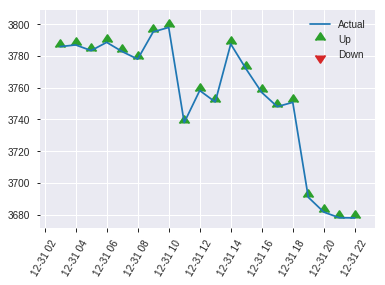


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24178555120259224
RMSE: 0.4917169421553342
LogLoss: 0.6762034771414359
Mean Per-Class Error: 0.4223508816333418
AUC: 0.603386273517253
pr_auc: 0.5976525026623538
Gini: 0.2067725470345061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38192035257816315: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   392  0.8929   (392.0/439.0)
1      13   419  0.0301   (13.0/432.0)
Total  60   811  0.465    (405.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38192      0.674175  350
max f2                       0.269465     0.832691  395
max f0point5                 0.430018     0.575421  310
max accuracy                 0.564468     0.578645  142
max precision                0.730915     1         0
max recall                   0.269465     1         395
max specificity              0.730915     1         0
max absolute_mcc             0.564468     0.160349  142
max min_per_class_accuracy   0.53147      0.569476  186
max mean_per_class_accuracy  0.564468     0.577649  142

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.699858           1.56816   1.56816            0.777778         0.713656  0.777778                    0.713656            0.0162037       0.0162037                  56.8158   56.8158
    2        0.0206659                   0.691151           1.79218   1.68017            0.888889         0.69438   0.833333                    0.704018            0.0185185       0.0347222                  79.2181   68.017
    3        0.0309989                   0.679114           1.56816   1.64283            0.777778         0.682831  0.814815                    0.696956            0.0162037       0.0509259                  56.8158   64.2833
    4        0.0401837                   0.671427           1.26013   1.55536            0.625            0.675118  0.771429                    0.691964            0.0115741       0.0625                     26.0127   55.5357
    5        0.0505166                   0.666661           1.12011   1.46633            0.555556         0.668603  0.727273                    0.687186            0.0115741       0.0740741                  12.0113   46.633
    6        0.101033                    0.643894           1.23722   1.35177            0.613636         0.653852  0.670455                    0.670519            0.0625          0.136574                   23.7216   35.1773
    7        0.150402                    0.628019           1.12532   1.27744            0.55814          0.63616   0.633588                    0.659241            0.0555556       0.19213                    12.5323   27.7442
    8        0.200918                    0.612051           1.28304   1.27885            0.636364         0.619858  0.634286                    0.649339            0.0648148       0.256944                   28.3039   27.8849
    9        0.300804                    0.58293            1.15874   1.23896            0.574713         0.597546  0.614504                    0.63214             0.115741        0.372685                   15.8738   23.8965
    10       0.400689                    0.557371           0.97334   1.17275            0.482759         0.570567  0.581662                    0.616791            0.0972222       0.469907                   -2.66603  17.2749
    11       0.500574                    0.531414           1.01969   1.14221            0.505747         0.543485  0.566514                    0.602163            0.101852        0.571759                   1.96892   14.2207
    12       0.600459                    0.5011             0.92699   1.10641            0.45977          0.515388  0.548757                    0.587729            0.0925926       0.664352                   -7.30098  10.6406
    13       0.700344                    0.469543           0.92699   1.08082            0.45977          0.486145  0.536066                    0.57324             0.0925926       0.756944                   -7.30098  8.08174
    14       0.80023                     0.436908           0.92699   1.06162            0.45977          0.453257  0.526542                    0.558264            0.0925926       0.849537                   -7.30098  6.16166
    15       0.900115                    0.398802           0.92699   1.04668            0.45977          0.420941  0.519133                    0.543025            0.0925926       0.94213                    -7.30098  4.66772
    16       1                           0.253184           0.579369  1                  0.287356         0.348869  0.495982                    0.523632           

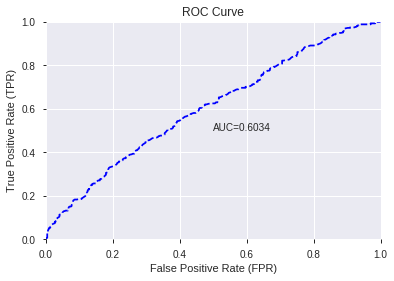

This function is available for GLM models only


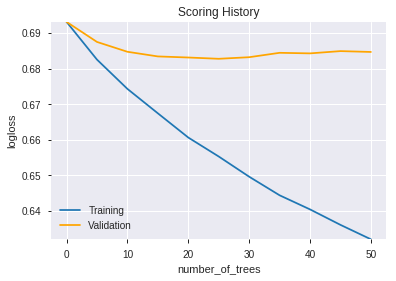

--2019-07-25 05:39:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

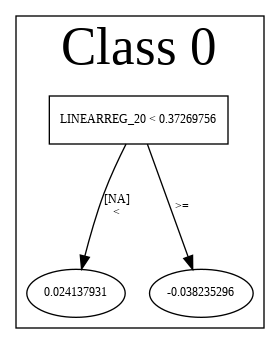

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_053921_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_053921_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'SIN',
 'dayofyear',
 'COS',
 'CORREL_14',
 'CORREL_8',
 'LINEARREG_ANGLE_14',
 'STOCHRSI_fastk',
 'SAREXT',
 'CORREL_20',
 'LINEARREG_ANGLE_20',
 'CORREL_30',
 'CORREL_24',
 'CORREL_12',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'is_month_end',
 'CDLHAMMER',
 'is_month_start',
 'CDLDRAGONFLYDOJI']

In [0]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [921 930] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


19

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'WILLR_12',
 'CCI_14',
 'WILLR_14',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLSHORTLINE']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_054009_model_9  0.609334  0.676148              0.469341  0.491599  0.241670
1  DeepLearning_grid_1_AutoML_20190725_054009_model_6  0.607193  0.676937              0.435726  0.491901  0.241967
2  DeepLearning_grid_1_AutoML_20190725_054009_model_4  0.600186  0.677119              0.469396  0.492099  0.242161
3  DeepLearning_grid_1_AutoML_20190725_054009_model_8  0.590106  0.687182              0.489786  0.496654  0.246665
4               DeepLearning_1_AutoML_20190725_054009  0.586687  0.684941              0.475257  0.495733  0.245751
5  DeepLearning_grid_1_AutoML_20190725_054009_model_5  0.580866  0.682669              0.460506  0.494751  0.244779
6  DeepLearning_grid_1_AutoML_20190725_054009_model_2  0.572690  0.724842              0.451800  0.508977  0.259058
7  DeepLearning_grid_1_AutoML_20190725_054009_model_7  0.569220  0.679114              0.459293  0.493220  0.243266
8  DeepLearning_grid_1_AutoML_20190725_054009_model_3  0.567752  0.720734              0.494361  0.509207  0.259292
9  DeepLearning_grid_1_AutoML_20190725_054009_model_1  0.565822  0.770183              0.500000  0.522164  0.272655

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.081701
1          CDLLONGLINE             0.970329           0.970329    0.079277
2         CDLSHORTLINE             0.948872           0.948872    0.077524
3         CDLENGULFING             0.847822           0.847822    0.069268
4                  BOP             0.770401           0.770401    0.062942
5       STOCHRSI_fastk             0.635938           0.635938    0.051957
6       STOCHRSI_fastd             0.603351           0.603351    0.049294
7             WILLR_12             0.603316           0.603316    0.049291
8         STOCHF_fastk             0.592037           0.592037    0.048370
9          CDLBELTHOLD             0.589714           0.589714    0.048180
10               CMO_8             0.572255           0.572255    0.046754
11               RSI_8             0.567059           0.567059    0.046329
12            WILLR_14             0.548710           0.548710    0.044830
13              CCI_12             0.517666           0.517666    0.042294
14             WILLR_8             0.503192           0.503192    0.041111
15         STOCH_slowk             0.503023           0.503023    0.041097
16        STOCHF_fastd             0.501672           0.501672    0.040987
17              CCI_14             0.485443           0.485443    0.039661
18               CCI_8             0.478980           0.478980    0.039133

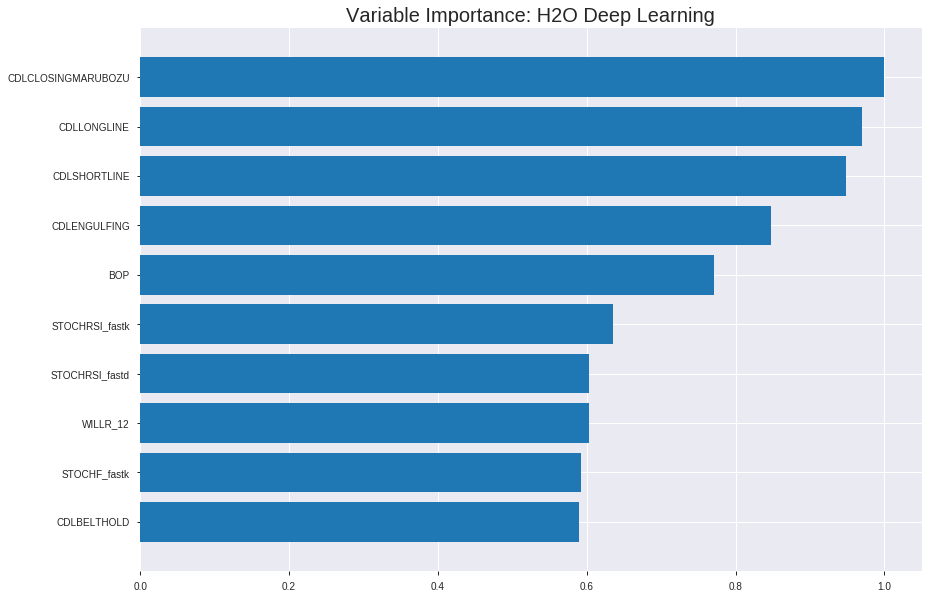

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_054009_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24470312709422543
RMSE: 0.49467476900911916
LogLoss: 0.682451143906699
Mean Per-Class Error: 0.43002419714514173
AUC: 0.589734023068261
pr_auc: 0.5689395734807398
Gini: 0.1794680461365219
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3250206269792025: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      119  2914  0.9608   (2914.0/3033.0)
1      48   3014  0.0157   (48.0/3062.0)
Total  167  5928  0.486    (2962.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325021     0.670523  365
max f2                       0.275792     0.835015  395
max f0point5                 0.438267     0.578396  244
max accuracy                 0.480996     0.569975  177
max precision                0.634133     1         0
max recall                   0.275792     1         395
max specificity              0.634133     1         0
max absolute_mcc             0.480996     0.13995   177
max min_per_class_accuracy   0.480996     0.569889  177
max mean_per_class_accuracy  0.480996     0.569976  177

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 47.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.605536           1.10948   1.10948            0.557377         0.61564   0.557377                    0.61564             0.0111039       0.0111039                  10.9475   10.9475
    2        0.0200164                   0.594134           1.27263   1.19105            0.639344         0.599944  0.598361                    0.607792            0.0127368       0.0238406                  27.2633   19.1054
    3        0.0300246                   0.587012           1.30526   1.22912            0.655738         0.59017   0.617486                    0.601918            0.0130634       0.036904                   30.5265   22.9125
    4        0.0400328                   0.579597           1.17474   1.21553            0.590164         0.583189  0.610656                    0.597236            0.011757        0.048661                   17.4738   21.5528
    5        0.050041                    0.574112           1.17474   1.20737            0.590164         0.576562  0.606557                    0.593101            0.011757        0.060418                   17.4738   20.737
    6        0.100082                    0.55773            1.22042   1.2139             0.613115         0.564735  0.609836                    0.578918            0.0610712       0.121489                   22.0423   21.3896
    7        0.150123                    0.545505           1.14211   1.18997            0.57377          0.55192   0.597814                    0.569919            0.0571522       0.178641                   14.2107   18.9967
    8        0.2                         0.535561           1.11312   1.1708             0.559211         0.540198  0.588187                    0.562507            0.0555193       0.234161                   11.3125   17.0803
    9        0.300082                    0.519493           1.19432   1.17865            0.6              0.527206  0.592127                    0.550733            0.11953         0.35369                    19.4317   17.8646
    10       0.4                         0.500803           1.10149   1.15937            0.553366         0.51015   0.582445                    0.540596            0.110059        0.463749                   10.1491   15.9373
    11       0.500082                    0.480697           1.06053   1.13959            0.532787         0.490313  0.572507                    0.530533            0.10614         0.569889                   6.05278   13.9591
    12       0.6                         0.463228           0.938065  1.10603            0.471264         0.472247  0.555647                    0.520826            0.0937296       0.663619                   -6.19346  10.6031
    13       0.699918                    0.44422            0.947871  1.08345            0.47619          0.453247  0.544304                    0.511179            0.0947093       0.758328                   -5.2129   8.34525
    14       0.8                         0.41892            0.88758   1.05895            0.445902         0.433254  0.531993                    0.50143             0.0888308       0.847159                   -11.242   5.89484
    15       0.899918                    0.375308           0.823667  1.03283            0.413793         0.397234  0.51887                     0.489861            0.0822992       0.929458                   -17.6333  3.28251
    16       1                           0.258448           0.704843  1                  0.354098         0.341075  0.502379                    0.47497           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24260464852200528
RMSE: 0.492549133104511
LogLoss: 0.6781742232732165
Mean Per-Class Error: 0.4131020838828805
AUC: 0.6025646267475601
pr_auc: 0.5796567938189277
Gini: 0.20512925349512012
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3256822742613912: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      38   854   0.9574   (854.0/892.0)
1      9    841   0.0106   (9.0/850.0)
Total  47   1695  0.4954   (863.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325682     0.660904  371
max f2                       0.257637     0.826527  399
max f0point5                 0.480365     0.57615   184
max accuracy                 0.490705     0.58783   168
max precision                0.630936     1         0
max recall                   0.257637     1         399
max specificity              0.630936     1         0
max absolute_mcc             0.490705     0.174325  168
max min_per_class_accuracy   0.484801     0.581176  177
max mean_per_class_accuracy  0.490705     0.586898  168

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 47.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.608261           1.36627   1.36627            0.666667         0.616451  0.666667                    0.616451            0.0141176       0.0141176                  36.6275   36.6275
    2        0.0200918                   0.596886           1.08498   1.22965            0.529412         0.60257   0.6                         0.609709            0.0105882       0.0247059                  8.49827   22.9647
    3        0.0304248                   0.587291           1.48013   1.31472            0.722222         0.592137  0.641509                    0.603741            0.0152941       0.04                       48.0131   31.4717
    4        0.0401837                   0.580048           1.5672    1.37603            0.764706         0.58395   0.671429                    0.598935            0.0152941       0.0552941                  56.7197   37.6034
    5        0.0505166                   0.575747           1.70784   1.4439             0.833333         0.577575  0.704545                    0.594566            0.0176471       0.0729412                  70.7843   44.3904
    6        0.100459                    0.560768           1.36627   1.40531            0.666667         0.56778   0.685714                    0.58125             0.0682353       0.141176                   36.6275   40.5311
    7        0.150402                    0.547725           1.13071   1.31413            0.551724         0.554057  0.641221                    0.57222             0.0564706       0.197647                   13.071    31.4127
    8        0.200344                    0.538305           1.17782   1.28015            0.574713         0.543336  0.624642                    0.56502             0.0588235       0.256471                   17.7823   28.0148
    9        0.30023                     0.523972           1.04826   1.203              0.511494         0.530849  0.586998                    0.553651            0.104706        0.361176                   4.82623   20.3001
    10       0.400115                    0.504189           1.13071   1.18495            0.551724         0.514562  0.578192                    0.543893            0.112941        0.474118                   13.071    18.4954
    11       0.5                         0.484216           1.09538   1.16706            0.534483         0.493293  0.56946                     0.533785            0.109412        0.583529                   9.53753   16.7059
    12       0.599885                    0.465538           0.871589  1.11786            0.425287         0.475426  0.545455                    0.524067            0.0870588       0.670588                   -12.8411  11.7861
    13       0.69977                     0.445469           0.824476  1.07598            0.402299         0.454945  0.525021                    0.514201            0.0823529       0.752941                   -17.5524  7.59832
    14       0.799656                    0.420614           0.80092   1.04162            0.390805         0.433331  0.508256                    0.504099            0.08            0.832941                   -19.908   4.16249
    15       0.899541                    0.374972           0.942258  1.03059            0.45977          0.398     0.502872                    0.492318            0.0941176       0.927059                   -5.77417  3.05912
    16       1                           0.257637           0.726077  1                  0.354286         0.340081  0.487945                    0.477025         


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:57:19  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:57:23  8 min 19.089 sec   400 obs/sec       0.241017  1             1469       0.50502          0.704935            -0.020205      0.572677        0.555969           1.17474          0.496144                         0.496349           0.686311              0.0139762        0.600242          0.570881             1.25242            0.493685
    2019-07-25 05:58:25  9 min 21.182 sec   779 obs/sec       7.64299   31            46584      0.495568         0.684277            0.0176272      0.585026        0.565178           1.10948          0.489253                         0.494795           0.682654              0.0201407        0.606085          0.58099              1.25242            0.486223
    2019-07-25 05:59:26  10 min 22.164 sec  890 obs/sec       16.7555   68            102125     0.496281         0.685709            0.0147987      0.585471        0.564938           1.04421          0.48991                          0.495036           0.683231              0.0191881        0.607075          0.580963             1.13856            0.495982
    2019-07-25 06:00:28  11 min 23.987 sec  961 obs/sec       26.8966   109           163935     0.49605          0.685258            0.0157152      0.589587        0.568619           1.04421          0.485972                         0.495038           0.683241              0.0191785        0.600545          0.581137             1.13856            0.490815
    2019-07-25 06:01:30  12 min 25.979 sec  1009 obs/sec      37.4811   152           228447     0.494675         0.682451            0.0211653      0.589734        0.56894            1.10948          0.485972                         0.492549           0.678174              0.029017         0.602565          0.579657             1.36627            0.495408
    2019-07-25 06:02:31  13 min 26.975 sec  1056 obs/sec      48.7715   198           297262     0.495287         0.683699            0.018739       0.593223        0.574651           1.17474          0.49073                          0.493995           0.681126              0.0233064        0.602141          0.577686             1.13856            0.490815
    2019-07-25 06:02:37  13 min 33.382 sec  1056 obs/sec      48.7715   198           297262     0.494675         0.682451            0.0211653      0.589734        0.56894            1.10948          0.485972                         0.492549           0.678174              0.029017         0.602565          0.579657             1.36627            0.495408

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CDLCLOSINGMARUBOZU  1                      1                    0.0817008
CDLLONGLINE         0.970329               0.970329             0.0792767
CDLSHORTLINE        0.948872               0.948872             0.0775236
CDLENGULFING        0.847822               0.847822             0.0692678
BOP                 0.770401               0.770401             0.0629424
STOCHRSI_fastk      0.635938               0.635938             0.0519566
STOCHRSI_fastd      0.603351               0.603351             0.0492942
WILLR_12            0.603316               0.603316             0.0492914
STOCHF_fastk        0.592037               0.592037             0.0483699
CDLBELTHOLD         0.589714               0.589714             0.0481801
CMO_8               0.572255               0.572255             0.0467537
RSI_8               0.567059               0.567059             0.0463292
WILLR_14            0.54871                0.54871              0.0448301
CCI_12              0.517666               0.517666             0.0422937
WILLR_8             0.503192               0.503192             0.0411112
STOCH_slowk         0.503023               0.503023             0.0410974
STOCHF_fastd        0.501672               0.501672             0.040987
CCI_14              0.485443               0.485443             0.0396611
CCI_8               0.47898                0.47898              0.0391331

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.582089552238806)

('F1', 0.674565560821485)

('auc', 0.6093341348181894)

('logloss', 0.676147657937411)

('mean_per_class_error', 0.41723614274867127)

('rmse', 0.4915990546655256)

('mse', 0.24166963054803842)

deeplearning prediction progress: |███████████████████████████████████████| 100%


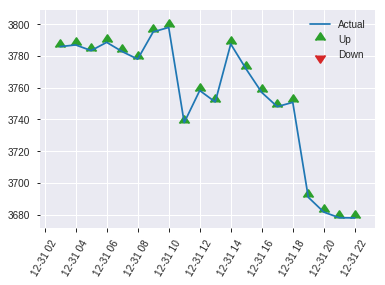


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24166963054803842
RMSE: 0.4915990546655256
LogLoss: 0.676147657937411
Mean Per-Class Error: 0.41723614274867127
AUC: 0.6093341348181894
pr_auc: 0.5793414510251962
Gini: 0.21866826963637886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3441460199817971: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   407  0.9271   (407.0/439.0)
1      5    427  0.0116   (5.0/432.0)
Total  37   834  0.473    (412.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344146     0.674566  369
max f2                       0.324977     0.83398   382
max f0point5                 0.446125     0.589334  255
max accuracy                 0.484471     0.58209   185
max precision                0.625455     0.666667  2
max recall                   0.267876     1         399
max specificity              0.636663     0.997722  0
max absolute_mcc             0.446125     0.181877  255
max min_per_class_accuracy   0.484471     0.580866  185
max mean_per_class_accuracy  0.472624     0.582764  209

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 47.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.603819           0.896091  0.896091           0.444444         0.618892  0.444444                    0.618892            0.00925926      0.00925926                 -10.3909  -10.3909
    2        0.0206659                   0.595267           1.56816   1.23212            0.777778         0.599677  0.611111                    0.609285            0.0162037       0.025463                   56.8158   23.2124
    3        0.0309989                   0.588181           1.34414   1.26946            0.666667         0.590653  0.62963                     0.603074            0.0138889       0.0393519                  34.4136   26.9462
    4        0.0401837                   0.581884           1.26013   1.26733            0.625            0.585273  0.628571                    0.599005            0.0115741       0.0509259                  26.0127   26.7328
    5        0.0505166                   0.578618           0.672068  1.14557            0.333333         0.580259  0.568182                    0.595171            0.00694444      0.0578704                  -32.7932  14.557
    6        0.101033                    0.559832           1.37468   1.26013            0.681818         0.567938  0.625                       0.581554            0.0694444       0.127315                   37.4684   26.0127
    7        0.150402                    0.549024           1.31288   1.27744            0.651163         0.553744  0.633588                    0.572426            0.0648148       0.19213                    31.2877   27.7442
    8        0.200918                    0.537265           1.37468   1.30189            0.681818         0.54201   0.645714                    0.564778            0.0694444       0.261574                   37.4684   30.1892
    9        0.300804                    0.52243            1.01969   1.20818            0.505747         0.529207  0.599237                    0.552967            0.101852        0.363426                   1.96892   20.8183
    10       0.400689                    0.505057           1.11239   1.1843             0.551724         0.515379  0.587393                    0.543597            0.111111        0.474537                   11.2388   18.4303
    11       0.500574                    0.484379           1.08921   1.16533            0.54023          0.49479   0.577982                    0.533858            0.108796        0.583333                   8.92135   16.5329
    12       0.600459                    0.469401           0.950165  1.12954            0.471264         0.477348  0.560229                    0.524457            0.0949074       0.678241                   -4.9835   12.9537
    13       0.700344                    0.449465           1.01969   1.11387            0.505747         0.458941  0.552459                    0.515113            0.101852        0.780093                   1.96892   11.387
    14       0.80023                     0.423815           0.811116  1.07608            0.402299         0.439088  0.533716                    0.505624            0.0810185       0.861111                   -18.8884  7.608
    15       0.900115                    0.37864            0.625718  1.0261             0.310345         0.403808  0.508929                    0.494325            0.0625          0.923611                   -37.4282  2.61037
    16       1                           0.267722           0.764767  1                  0.37931          0.341082  0.495982                    0.479019            

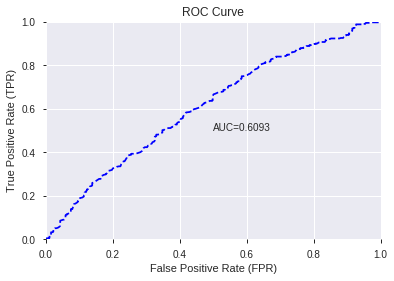

This function is available for GLM models only


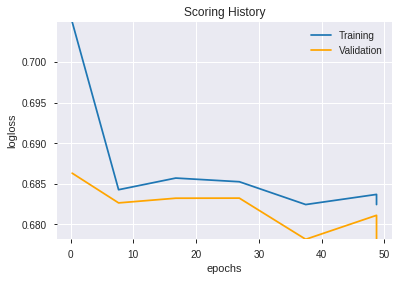

['CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'BOP',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'WILLR_12',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'CMO_8',
 'RSI_8',
 'WILLR_14',
 'CCI_12',
 'WILLR_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_14',
 'CCI_8']

In [0]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_060252_model_1  0.611915  0.674667               0.46484  0.490806  0.240891

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.128783           1.000000    0.184231
1       STOCHRSI_fastd             0.078775           0.611688    0.112692
2         CDLSHORTLINE             0.061623           0.478504    0.088155
3             WILLR_14             0.059180           0.459533    0.084660
4          CDLLONGLINE             0.051320           0.398500    0.073416
5       STOCHRSI_fastk             0.043570           0.338324    0.062330
6                RSI_8             0.042096           0.326876    0.060221
7                CMO_8             0.041983           0.325997    0.060059
8             WILLR_12             0.033828           0.262671    0.048392
9         STOCHF_fastk             0.033535           0.260402    0.047974
10  CDLCLOSINGMARUBOZU             0.024702           0.191812    0.035338
11              CCI_14             0.023720           0.184187    0.033933
12         CDLBELTHOLD             0.019611           0.152279    0.028054
13        CDLENGULFING             0.017376           0.134925    0.024857
14             WILLR_8             0.016988           0.131912    0.024302
15        STOCHF_fastd             0.008226           0.063877    0.011768
16         STOCH_slowk             0.007218           0.056046    0.010325
17               CCI_8             0.005589           0.043402    0.007996
18              CCI_12             0.000907           0.007039    0.001297

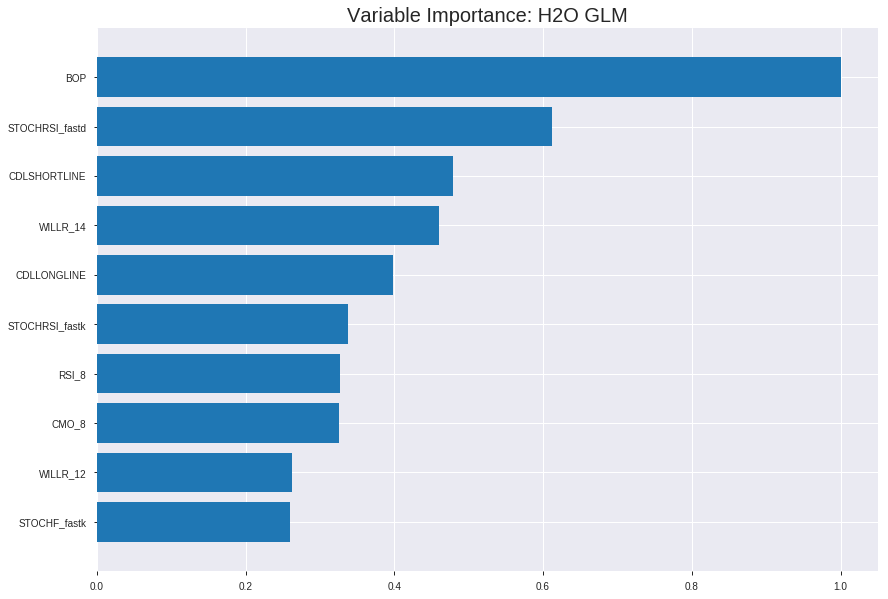

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_060252_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2439897589538812
RMSE: 0.4939531951044362
LogLoss: 0.681036645595025
Null degrees of freedom: 6094
Residual degrees of freedom: 6075
Null deviance: 8449.32614855268
Residual deviance: 8301.836709803354
AIC: 8341.836709803354
AUC: 0.5897027967773606
pr_auc: 0.5690096074489228
Gini: 0.1794055935547212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.355407201217173: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      50   2983  0.9835   (2983.0/3033.0)
1      11   3051  0.0036   (11.0/3062.0)
Total  61   6034  0.4912   (2994.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355407     0.670844  382
max f2                       0.327578     0.834787  396
max f0point5                 0.462383     0.577843  257
max accuracy                 0.500655     0.569811  200
max precision                0.687858     0.75      1
max recall                   0.327578     1         396
max specificity              0.701031     0.99967   0
max absolute_mcc             0.500655     0.139556  200
max min_per_class_accuracy   0.503159     0.568414  196
max mean_per_class_accuracy  0.500655     0.569764  200

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.656752           1.14211   1.14211            0.57377          0.666923  0.57377                     0.666923            0.0114304       0.0114304                  14.2107   14.2107
    2        0.0200164                   0.640816           1.14211   1.14211            0.57377          0.647973  0.57377                     0.657448            0.0114304       0.0228609                  14.2107   14.2107
    3        0.0300246                   0.631413           1.07684   1.12035            0.540984         0.635937  0.562842                    0.650277            0.0107773       0.0336381                  7.68436   12.0352
    4        0.0400328                   0.624556           1.40316   1.19105            0.704918         0.628199  0.598361                    0.644758            0.0140431       0.0476813                  40.316    19.1054
    5        0.050041                    0.617761           1.27263   1.20737            0.639344         0.620778  0.606557                    0.639962            0.0127368       0.060418                   27.2633   20.737
    6        0.100082                    0.595664           1.22042   1.2139             0.613115         0.605478  0.609836                    0.62272             0.0610712       0.121489                   22.0423   21.3896
    7        0.150123                    0.581927           1.16169   1.19649            0.583607         0.588306  0.601093                    0.611248            0.0581319       0.179621                   16.1686   19.6493
    8        0.2                         0.569511           1.17205   1.1904             0.588816         0.575481  0.598031                    0.602329            0.0584585       0.23808                    17.2055   19.0398
    9        0.300082                    0.548204           1.16169   1.18082            0.583607         0.558455  0.59322                     0.587696            0.116264        0.354344                   16.1686   18.0822
    10       0.4                         0.526684           1.08842   1.15774            0.546798         0.537701  0.581624                    0.575208            0.108752        0.463096                   8.84174   15.774
    11       0.500082                    0.502884           1.04421   1.13502            0.52459          0.514613  0.57021                     0.563081            0.104507        0.567603                   4.4212    13.502
    12       0.6                         0.479899           0.95114   1.1044             0.477833         0.491468  0.554826                    0.551155            0.0950359       0.662639                   -4.88605  10.4398
    13       0.699918                    0.457812           0.960945  1.08392            0.482759         0.468761  0.544538                    0.539393            0.0960157       0.758654                   -3.90549  8.39191
    14       0.8                         0.435931           0.89737   1.06058            0.45082          0.446652  0.532814                    0.527791            0.0898106       0.848465                   -10.263   6.05813
    15       0.899918                    0.405791           0.787713  1.03028            0.395731         0.421819  0.517593                    0.516025            0.0787067       0.927172                   -21.2287  3.02848
    16       1                           0.311355           0.727685  1                  0.365574         0.379679  0.502379                    0.502379            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24196808885867707
RMSE: 0.4919025196709985
LogLoss: 0.6768852315243851
Null degrees of freedom: 1741
Residual degrees of freedom: 1722
Null deviance: 2415.3638887467546
Residual deviance: 2358.2681466309577
AIC: 2398.2681466309577
AUC: 0.6051543128462147
pr_auc: 0.5802395143107891
Gini: 0.21030862569242936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36997295439245065: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      44   848   0.9507   (848.0/892.0)
1      9    841   0.0106   (9.0/850.0)
Total  53   1689  0.492    (857.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369973     0.662466  372
max f2                       0.349893     0.827963  386
max f0point5                 0.499815     0.5747    201
max accuracy                 0.516212     0.583812  178
max precision                0.617785     0.703297  38
max recall                   0.330425     1         396
max specificity              0.677235     0.998879  0
max absolute_mcc             0.516212     0.16614   178
max min_per_class_accuracy   0.506002     0.571765  191
max mean_per_class_accuracy  0.516212     0.582725  178

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.654672           1.13856   1.13856            0.555556         0.66524   0.555556                    0.66524             0.0117647       0.0117647                  13.8562   13.8562
    2        0.0200918                   0.642996           1.5672    1.34676            0.764706         0.649098  0.657143                    0.6574              0.0152941       0.0270588                  56.7197   34.6756
    3        0.0304248                   0.633519           1.36627   1.35339            0.666667         0.637884  0.660377                    0.650772            0.0141176       0.0411765                  36.6275   35.3385
    4        0.0401837                   0.625581           1.5672    1.40531            0.764706         0.629481  0.685714                    0.645601            0.0152941       0.0564706                  56.7197   40.5311
    5        0.0505166                   0.619521           1.48013   1.42061            0.722222         0.622413  0.693182                    0.640858            0.0152941       0.0717647                  48.0131   42.0615
    6        0.100459                    0.59618            1.27205   1.34676            0.62069          0.607654  0.657143                    0.624351            0.0635294       0.135294                   27.2049   34.6756
    7        0.150402                    0.579804           1.38983   1.36106            0.678161         0.587101  0.664122                    0.611982            0.0694118       0.204706                   38.9831   36.106
    8        0.200344                    0.569773           1.13071   1.30364            0.551724         0.574676  0.636103                    0.602682            0.0564706       0.261176                   13.071    30.3637
    9        0.30023                     0.550102           1.09538   1.23435            0.534483         0.560245  0.602294                    0.588563            0.109412        0.370588                   9.53753   23.4349
    10       0.400115                    0.5291             1.0836    1.19672            0.528736         0.539956  0.583931                    0.576429            0.108235        0.478824                   8.3597    19.6715
    11       0.5                         0.505299           0.965815  1.15059            0.471264         0.5171    0.561424                    0.564577            0.0964706       0.575294                   -3.41853  15.0588
    12       0.599885                    0.479357           0.989371  1.12374            0.482759         0.493163  0.548325                    0.552686            0.0988235       0.674118                   -1.06288  12.3744
    13       0.69977                     0.456518           0.918702  1.09448            0.448276         0.467678  0.534044                    0.540552            0.0917647       0.765882                   -8.12982  9.44767
    14       0.799656                    0.435391           0.73025   1.04898            0.356322         0.446859  0.511845                    0.528849            0.0729412       0.838824                   -26.975   4.8981
    15       0.899541                    0.40256            0.871589  1.02928            0.425287         0.421034  0.502234                    0.516877            0.0870588       0.925882                   -12.8411  2.92834
    16       1                           0.318271           0.737788  1                  0.36             0.376135  0.487945                    0.502738           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 06:02:53  0.000 sec   2            6.8       20            1.37964           1.3777
    2019-07-25 06:02:53  0.011 sec   4            4.2       20            1.37734           1.37446
    2019-07-25 06:02:53  0.023 sec   6            2.6       20            1.37481           1.3708
    2019-07-25 06:02:53  0.033 sec   8            1.6       20            1.37227           1.36702
    2019-07-25 06:02:53  0.044 sec   10           1         20            1.36987           1.36343
    2019-07-25 06:02:53  0.054 sec   12           0.62      20            1.36775           1.3603
    2019-07-25 06:02:53  0.065 sec   14           0.39      20            1.36602           1.3578
    2019-07-25 06:02:53  0.075 sec   16           0.24      20            1.36469           1.35601
    2019-07-25 06:02:53  0.085 sec   18           0.15      20            1.36372           1.35485
    2019-07-25 06:02:53  0.096 sec   20           0.093     20            1.36301           1.35418
    2019-07-25 06:02:53  0.102 sec   21           0.058     20            1.36248           1.35385
    2019-07-25 06:02:53  0.108 sec   22           0.036     20            1.36207           1.35377
    2019-07-25 06:02:53  0.116 sec   23           0.022     20            1.36176           1.35387
    2019-07-25 06:02:53  0.122 sec   24           0.014     20            1.36153           1.35407
    2019-07-25 06:02:53  0.129 sec   25           0.0086    20            1.36136           1.3543
    2019-07-25 06:02:53  0.136 sec   26           0.0053    20            1.36124           1.35452
    2019-07-25 06:02:53  0.144 sec   27           0.0033    20            1.36116           1.35472

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5843857634902411)

('F1', 0.6751592356687898)

('auc', 0.6119152324306082)

('logloss', 0.6746667114917716)

('mean_per_class_error', 0.41564108242639)

('rmse', 0.4908063300399806)

('mse', 0.24089085360731435)

glm prediction progress: |████████████████████████████████████████████████| 100%


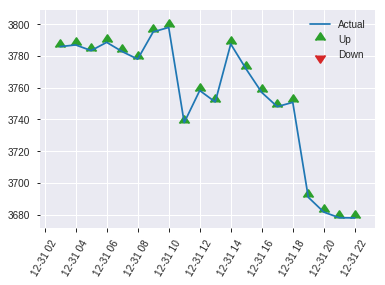


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24089085360731435
RMSE: 0.4908063300399806
LogLoss: 0.6746667114917716
Null degrees of freedom: 870
Residual degrees of freedom: 851
Null deviance: 1207.5487194139707
Residual deviance: 1175.269411418666
AIC: 1215.269411418666
AUC: 0.6119152324306082
pr_auc: 0.5866728204895366
Gini: 0.22383046486121638
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39503814395179115: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   400  0.9112   (400.0/439.0)
1      8    424  0.0185   (8.0/432.0)
Total  47   824  0.4684   (408.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395038     0.675159  365
max f2                       0.368047     0.835271  385
max f0point5                 0.456262     0.588431  283
max accuracy                 0.509688     0.584386  199
max precision                0.666139     0.857143  5
max recall                   0.351747     1         392
max specificity              0.687908     0.997722  0
max absolute_mcc             0.456262     0.18093   283
max min_per_class_accuracy   0.507692     0.583144  202
max mean_per_class_accuracy  0.508243     0.584359  201

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010333                    0.657901           1.34414   1.34414            0.666667         0.670566  0.666667                    0.670566            0.0138889       0.0138889                  34.4136    34.4136
    2        0.0206659                   0.640634           1.34414   1.34414            0.666667         0.650456  0.666667                    0.660511            0.0138889       0.0277778                  34.4136    34.4136
    3        0.0309989                   0.632448           1.34414   1.34414            0.666667         0.635665  0.666667                    0.652229            0.0138889       0.0416667                  34.4136    34.4136
    4        0.0401837                   0.622027           1.26013   1.32493            0.625            0.627432  0.657143                    0.646561            0.0115741       0.0532407                  26.0127    32.4934
    5        0.0505166                   0.616142           1.34414   1.32886            0.666667         0.618923  0.659091                    0.640908            0.0138889       0.0671296                  34.4136    32.8862
    6        0.101033                    0.596188           1.23722   1.28304            0.613636         0.60568   0.636364                    0.623294            0.0625          0.12963                    23.7216    28.3039
    7        0.150402                    0.584714           1.2191    1.26205            0.604651         0.590398  0.625954                    0.612496            0.0601852       0.189815                   21.91      26.2051
    8        0.200918                    0.572209           1.14557   1.23276            0.568182         0.578422  0.611429                    0.603929            0.0578704       0.247685                   14.557     23.2765
    9        0.300804                    0.551458           1.25144   1.23896            0.62069          0.561939  0.614504                    0.589986            0.125           0.372685                   25.1437    23.8965
    10       0.400689                    0.531672           0.950165  1.16697            0.471264         0.541321  0.578797                    0.577854            0.0949074       0.467593                   -4.9835    16.6972
    11       0.500574                    0.50725            1.18191   1.16995            0.586207         0.518544  0.580275                    0.566019            0.118056        0.585648                   18.1913    16.9953
    12       0.600459                    0.487304           0.857466  1.11797            0.425287         0.49651   0.554493                    0.554457            0.0856481       0.671296                   -14.2534   11.7971
    13       0.700344                    0.463342           0.996514  1.10065            0.494253         0.475724  0.545902                    0.543228            0.099537        0.770833                   -0.348553  10.0649
    14       0.80023                     0.441263           0.950165  1.08187            0.471264         0.452035  0.536585                    0.531845            0.0949074       0.865741                   -4.9835    8.18654
    15       0.900115                    0.413928           0.811116  1.05182            0.402299         0.427484  0.521684                    0.520264            0.0810185       0.946759                   -18.8884   5.18206
    16       1                           0.329309           0.533019  1                  0.264368         0.387118  0.495982                    

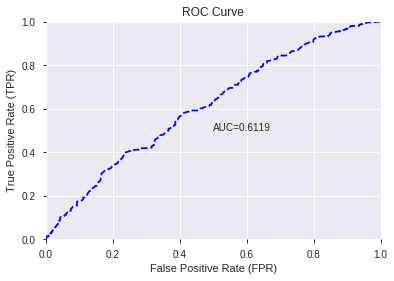

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


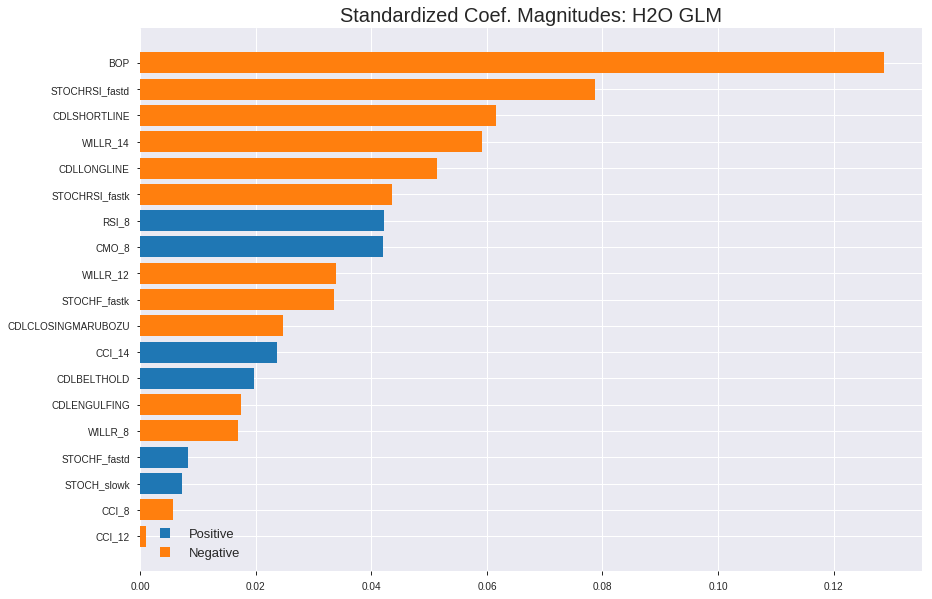

'log_likelihood'
--2019-07-25 06:03:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


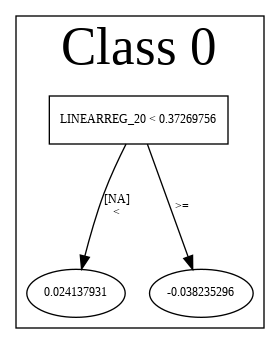

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_060252_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_060252_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHRSI_fastd',
 'CDLSHORTLINE',
 'WILLR_14',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'RSI_8',
 'CMO_8',
 'WILLR_12',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CCI_14',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'WILLR_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CCI_8',
 'CCI_12']

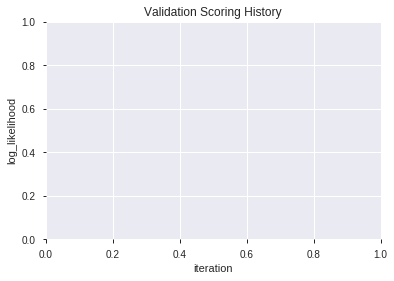

In [0]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_060315_model_1  0.599366  0.676669              0.472831  0.491878  0.241943
1  XGBoost_grid_1_AutoML_20190725_060315_model_3  0.596423  0.677347              0.472813  0.492197  0.242258
2  XGBoost_grid_1_AutoML_20190725_060315_model_2  0.595661  0.677924              0.457070  0.492470  0.242527
3  XGBoost_grid_1_AutoML_20190725_060315_model_4  0.591949  0.678572              0.466108  0.492825  0.242877
4  XGBoost_grid_1_AutoML_20190725_060315_model_6  0.587212  0.679435              0.470572  0.493302  0.243346
5               XGBoost_3_AutoML_20190725_060315  0.586487  0.679532              0.472850  0.493322  0.243366
6               XGBoost_2_AutoML_20190725_060315  0.586386  0.682339              0.456116  0.494630  0.244659
7               XGBoost_1_AutoML_20190725_060315  0.584417  0.683563              0.495444  0.495151  0.245174
8  XGBoost_grid_1_AutoML_20190725_060315_model_7  0.583252  0.682375              0.486406  0.494762  0.244790
9  XGBoost_grid_1_AutoML_20190725_060315_model_5  0.568519  0.702695              0.500000  0.503387  0.253398

variable  relative_importance  scaled_importance  percentage
0                  BOP          1268.453247           1.000000    0.182721
1         STOCHF_fastk           702.125793           0.553529    0.101141
2       STOCHRSI_fastd           660.163757           0.520448    0.095097
3                CMO_8           529.243225           0.417235    0.076238
4                CCI_8           458.136719           0.361177    0.065995
5             WILLR_14           444.472809           0.350405    0.064026
6          STOCH_slowk           442.596100           0.348926    0.063756
7             WILLR_12           435.658356           0.343456    0.062757
8               CCI_14           421.697754           0.332450    0.060746
9       STOCHRSI_fastk           398.390778           0.314076    0.057388
10             WILLR_8           371.997833           0.293269    0.053586
11              CCI_12           317.420929           0.250243    0.045725
12        STOCHF_fastd           130.718307           0.103053    0.018830
13  CDLCLOSINGMARUBOZU           129.796127           0.102326    0.018697
14        CDLENGULFING           106.623459           0.084058    0.015359
15               RSI_8            91.462463           0.072106    0.013175
16         CDLLONGLINE            17.985165           0.014179    0.002591
17        CDLSHORTLINE             9.536105           0.007518    0.001374
18         CDLBELTHOLD             5.547718           0.004374    0.000799

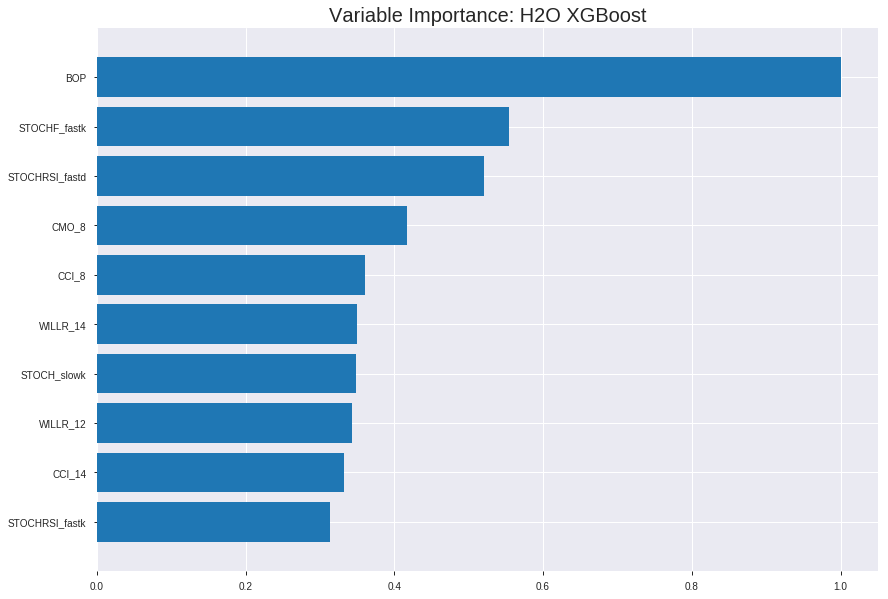

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_060315_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2229825846042724
RMSE: 0.47221031818912257
LogLoss: 0.6376918762523752
Mean Per-Class Error: 0.33724028070928047
AUC: 0.7272384566631843
pr_auc: 0.7313676665473248
Gini: 0.45447691332636864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44976353844006856: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1136  1897  0.6255   (1897.0/3033.0)
1      360   2702  0.1176   (360.0/3062.0)
Total  1496  4599  0.3703   (2257.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449764     0.705391  251
max f2                       0.328083     0.842777  351
max f0point5                 0.506357     0.663519  185
max accuracy                 0.506357     0.662838  185
max precision                0.745485     1         0
max recall                   0.25722      1         388
max specificity              0.745485     1         0
max absolute_mcc             0.506357     0.325711  185
max min_per_class_accuracy   0.510217     0.65872   180
max mean_per_class_accuracy  0.506357     0.66276   185

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.66605            1.92527   1.92527            0.967213         0.684263  0.967213                    0.684263            0.0192685       0.0192685                  92.5266   92.5266
    2        0.0200164                   0.650228           1.9579    1.94158            0.983607         0.658166  0.97541                     0.671215            0.019595        0.0388635                  95.7897   94.1582
    3        0.0300246                   0.641973           1.63158   1.83825            0.819672         0.646057  0.923497                    0.662829            0.0163292       0.0551927                  63.1581   83.8248
    4        0.0400328                   0.634074           1.79474   1.82737            0.901639         0.638119  0.918033                    0.656651            0.0179621       0.0731548                  79.4739   82.7371
    5        0.050041                    0.628821           1.82737   1.82737            0.918033         0.631796  0.918033                    0.65168             0.0182887       0.0914435                  82.7371   82.7371
    6        0.100082                    0.607981           1.64463   1.736              0.82623          0.617317  0.872131                    0.634498            0.0822992       0.173743                   64.4634   73.6002
    7        0.150123                    0.591982           1.56632   1.67944            0.786885         0.59976   0.843716                    0.622919            0.0783801       0.252123                   56.6318   67.9441
    8        0.2                         0.579293           1.27682   1.57903            0.641447         0.585428  0.793273                    0.613569            0.0636839       0.315807                   27.682    57.9033
    9        0.300082                    0.555045           1.25632   1.4714             0.631148         0.566883  0.739202                    0.597999            0.125735        0.441541                   25.6318   47.1403
    10       0.4                         0.532132           1.10476   1.37982            0.555008         0.543169  0.693191                    0.584303            0.110385        0.551927                   10.476    37.9817
    11       0.500082                    0.509998           1.06379   1.31657            0.534426         0.520756  0.661417                    0.571585            0.106466        0.658393                   6.37909   31.657
    12       0.6                         0.487531           0.921723  1.25082            0.463054         0.498888  0.628384                    0.559479            0.0920967       0.75049                    -7.82772  25.0816
    13       0.699918                    0.464228           0.895575  1.2001             0.449918         0.475881  0.602907                    0.547545            0.089484        0.839974                   -10.4425  20.0103
    14       0.8                         0.434328           0.682001  1.13529            0.342623         0.4504    0.570345                    0.535392            0.068256        0.90823                    -31.7999  13.5287
    15       0.899918                    0.377291           0.591602  1.07492            0.297209         0.40951   0.540018                    0.521415            0.0591117       0.967342                   -40.8398  7.4922
    16       1                           0.208201           0.326316  1                  0.163934         0.32943   0.502379                    0.502201           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2448474435582972
RMSE: 0.4948206175557939
LogLoss: 0.6826894802818225
Mean Per-Class Error: 0.43687417567924025
AUC: 0.5796069638617779
pr_auc: 0.5362903345817658
Gini: 0.1592139277235558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36760377883911133: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      73   819   0.9182   (819.0/892.0)
1      22   828   0.0259   (22.0/850.0)
Total  95   1647  0.4828   (841.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367604     0.663196  343
max f2                       0.278995     0.826994  386
max f0point5                 0.442553     0.570203  274
max accuracy                 0.534042     0.565442  152
max precision                0.656453     0.588235  12
max recall                   0.250587     1         397
max specificity              0.722502     0.998879  0
max absolute_mcc             0.430651     0.152324  288
max min_per_class_accuracy   0.513447     0.556471  178
max mean_per_class_accuracy  0.534042     0.563126  152

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 50.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.655578           1.13856   1.13856            0.555556         0.676051  0.555556                    0.676051            0.0117647       0.0117647                  13.8562   13.8562
    2        0.0200918                   0.640567           0.964429  1.05398            0.470588         0.649578  0.514286                    0.663193            0.00941176      0.0211765                  -3.55709  5.39832
    3        0.0304248                   0.631172           0.796993  0.966704           0.388889         0.636597  0.471698                    0.65416             0.00823529      0.0294118                  -20.3007  -3.32963
    4        0.0401837                   0.625983           1.08498   0.995429           0.529412         0.628596  0.485714                    0.647952            0.0105882       0.04                       8.49827   -0.457143
    5        0.0505166                   0.621049           1.36627   1.07128            0.666667         0.623046  0.522727                    0.642857            0.0141176       0.0541176                  36.6275   7.12834
    6        0.100459                    0.602368           1.10715   1.08912            0.54023          0.611003  0.531429                    0.627021            0.0552941       0.109412                   10.7153   8.9116
    7        0.150402                    0.590062           1.17782   1.11857            0.574713         0.595902  0.545802                    0.616687            0.0588235       0.168235                   17.7823   11.8572
    8        0.200344                    0.579343           1.34272   1.17445            0.655172         0.584469  0.573066                    0.608656            0.0670588       0.235294                   34.2718   17.4448
    9        0.30023                     0.558655           1.09538   1.14814            0.534483         0.568883  0.560229                    0.595424            0.109412        0.344706                   9.53753   14.8141
    10       0.400115                    0.534451           1.1896    1.15849            0.58046          0.546506  0.56528                     0.583212            0.118824        0.463529                   18.9601   15.8491
    11       0.5                         0.512742           0.954037  1.11765            0.465517         0.522939  0.54535                     0.571171            0.0952941       0.558824                   -4.59635  11.7647
    12       0.599885                    0.48965            0.989371  1.09629            0.482759         0.501081  0.534928                    0.559501            0.0988235       0.657647                   -1.06288  9.62882
    13       0.69977                     0.468563           0.859811  1.06253            0.41954          0.478861  0.518458                    0.54799             0.0858824       0.743529                   -14.0189  6.25334
    14       0.799656                    0.441733           1.17782   1.07693            0.574713         0.455404  0.525485                    0.536425            0.117647        0.861176                   17.7823   7.69343
    15       0.899541                    0.398998           0.73025   1.03844            0.356322         0.42271   0.506701                    0.523798            0.0729412       0.934118                   -26.975   3.84384
    16       1                           0.233994           0.655812  1                  0.32             0.350495  0.487945                    0.506388       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:03:22  0.020 sec   0                  0.5              0.693147            0.5             0                  1                0.497621                         0.5                0.693147              0.5               0                    1                  0.512055
    2019-07-25 06:03:22  0.117 sec   5                  0.494366         0.681912            0.643315        0.642961           1.79148          0.44233                          0.49784            0.688828              0.567041          0.521646             0.86291            0.476464
    2019-07-25 06:03:22  0.173 sec   10                 0.489986         0.673193            0.666079        0.661246           1.86             0.413946                         0.496216           0.685573              0.580961          0.528588             0.755046           0.501148
    2019-07-25 06:03:22  0.242 sec   15                 0.4865           0.666254            0.67735         0.673575           1.87514          0.400328                         0.495578           0.684284              0.578776          0.527534             0.796993           0.486797
    2019-07-25 06:03:22  0.369 sec   20                 0.48333          0.659943            0.68917         0.688196           1.89866          0.395406                         0.495175           0.683453              0.577143          0.528778             0.91085            0.487371
    2019-07-25 06:03:22  0.454 sec   25                 0.480894         0.655063            0.695664        0.695992           1.95842          0.387039                         0.494873           0.682825              0.57854           0.530045             0.91085            0.486797
    2019-07-25 06:03:22  0.536 sec   30                 0.478943         0.651145            0.702186        0.704178           1.92527          0.406891                         0.494845           0.682757              0.577826          0.531289             0.91085            0.48163
    2019-07-25 06:03:22  0.618 sec   35                 0.476886         0.647045            0.709958        0.713489           1.92527          0.37982                          0.494667           0.682394              0.579565          0.534613             1.02471            0.485649
    2019-07-25 06:03:22  0.705 sec   40                 0.475051         0.643378            0.717099        0.721276           1.92527          0.362264                         0.494813           0.682676              0.579302          0.53529              1.13856            0.458668
    2019-07-25 06:03:22  0.792 sec   45                 0.473432         0.640135            0.722377        0.726979           1.92527          0.372765                         0.494763           0.682577              0.579724          0.536331             1.13856            0.482204
    2019-07-25 06:03:23  0.875 sec   50                 0.47221          0.637692            0.727238        0.731368           1.92527          0.370304                         0.494821           0.682689              0.579607          0.53629              1.13856            0.482778

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 1268.45                1                    0.182721
STOCHF_fastk        702.126                0.553529             0.101141
STOCHRSI_fastd      660.164                0.520448             0.0950967
CMO_8               529.243                0.417235             0.0762376
CCI_8               458.137                0.361177             0.0659947
WILLR_14            444.473                0.350405             0.0640264
STOCH_slowk         442.596                0.348926             0.063756
WILLR_12            435.658                0.343456             0.0627567
CCI_14              421.698                0.33245              0.0607456
STOCHRSI_fastk      398.391                0.314076             0.0573883
WILLR_8             371.998                0.293269             0.0535863
CCI_12              317.421                0.250243             0.0457245
STOCHF_fastd        130.718                0.103053             0.01883
CDLCLOSINGMARUBOZU  129.796                0.102326             0.0186972
CDLENGULFING        106.623                0.0840579            0.0153591
RSI_8               91.4625                0.0721055            0.0131752
CDLLONGLINE         17.9852                0.0141788            0.00259077
CDLSHORTLINE        9.53611                0.0075179            0.00137368
CDLBELTHOLD         5.54772                0.00437361           0.00079915

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5797933409873708)

('F1', 0.6708961141950833)

('auc', 0.5993656669197671)

('logloss', 0.6766691980614403)

('mean_per_class_error', 0.4202891672994179)

('rmse', 0.4918775088718335)

('mse', 0.24194348373396063)

xgboost prediction progress: |████████████████████████████████████████████| 100%


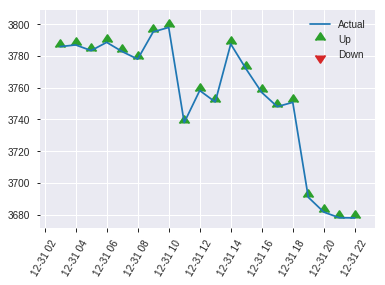


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24194348373396063
RMSE: 0.4918775088718335
LogLoss: 0.6766691980614403
Mean Per-Class Error: 0.4202891672994179
AUC: 0.5993656669197671
pr_auc: 0.5805275861197255
Gini: 0.19873133383953423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34384138385454815: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      33   406  0.9248   (406.0/439.0)
1      9    423  0.0208   (9.0/432.0)
Total  42   829  0.4765   (415.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343841     0.670896  367
max f2                       0.303675     0.833656  386
max f0point5                 0.445855     0.582061  277
max accuracy                 0.512983     0.579793  179
max precision                0.675239     1         0
max recall                   0.285274     1         391
max specificity              0.675239     1         0
max absolute_mcc             0.441082     0.164604  282
max min_per_class_accuracy   0.511965     0.569444  180
max mean_per_class_accuracy  0.511965     0.579711  180

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010333                    0.650638           1.34414   1.34414            0.666667         0.664585  0.666667                    0.664585            0.0138889       0.0138889                  34.4136    34.4136
    2        0.0206659                   0.639781           1.34414   1.34414            0.666667         0.644269  0.666667                    0.654427            0.0138889       0.0277778                  34.4136    34.4136
    3        0.0309989                   0.631245           1.34414   1.34414            0.666667         0.636179  0.666667                    0.648344            0.0138889       0.0416667                  34.4136    34.4136
    4        0.0401837                   0.621914           1.51215   1.38254            0.75             0.626417  0.685714                    0.643332            0.0138889       0.0555556                  51.2153    38.254
    5        0.0505166                   0.618253           1.34414   1.37468            0.666667         0.619726  0.681818                    0.638504            0.0138889       0.0694444                  34.4136    37.4684
    6        0.101033                    0.599441           1.14557   1.26013            0.568182         0.608051  0.625                       0.623277            0.0578704       0.127315                   14.557     26.0127
    7        0.150402                    0.58644            1.40665   1.30822            0.697674         0.59303   0.648855                    0.613349            0.0694444       0.196759                   40.6654    30.8224
    8        0.200918                    0.575868           1.09975   1.25581            0.545455         0.58036   0.622857                    0.605054            0.0555556       0.252315                   9.97475    25.5807
    9        0.300804                    0.556503           1.04286   1.1851             0.517241         0.565814  0.587786                    0.592024            0.104167        0.356481                   4.2864     18.5097
    10       0.400689                    0.533557           1.18191   1.1843             0.586207         0.543905  0.587393                    0.580029            0.118056        0.474537                   18.1913    18.4303
    11       0.500574                    0.50712            0.97334   1.14221            0.482759         0.520934  0.566514                    0.568237            0.0972222       0.571759                   -2.66603   14.2207
    12       0.600459                    0.48717            0.880641  1.0987             0.436782         0.49714   0.544933                    0.55641             0.087963        0.659722                   -11.9359   9.86961
    13       0.700344                    0.464965           1.04286   1.09073            0.517241         0.476095  0.540984                    0.544955            0.104167        0.763889                   4.2864     9.07332
    14       0.80023                     0.437715           0.996514  1.07897            0.494253         0.451908  0.535151                    0.533341            0.099537        0.863426                   -0.348553  7.89727
    15       0.900115                    0.39348            0.695243  1.03639            0.344828         0.418291  0.514031                    0.520574            0.0694444       0.93287                    -30.4757   3.63904
    16       1                           0.245336           0.672068  1                  0.333333         0.338619  0.495982                    0

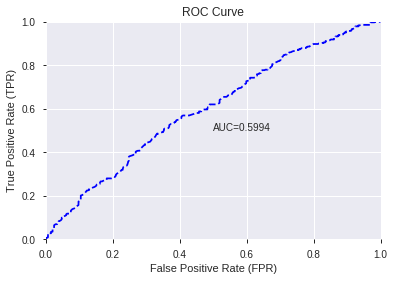

This function is available for GLM models only


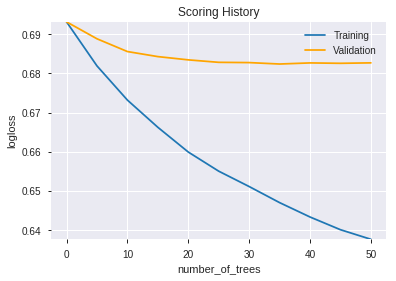

--2019-07-25 06:03:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.8
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.8|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

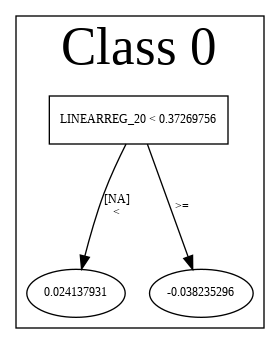

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_060315_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_060315_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'CMO_8',
 'CCI_8',
 'WILLR_14',
 'STOCH_slowk',
 'WILLR_12',
 'CCI_14',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CCI_12',
 'STOCHF_fastd',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'RSI_8',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLBELTHOLD']

In [0]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [0]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

481

['Volume_(Currency)',
 'Weighted_Price',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'hour',
 'is_month_end',
 'is_month_start',
 'is_quarter_start',
 'month',
 'quarter',
 'week',
 'weekday',
 'weekday_name',
 'mama',
 'SAREXT',
 'DEMA_8',
 'EMA_8',
 'SAR_0.08',
 'SMA_8',
 'TEMA_8',
 'TRIMA_8',
 'WMA_8',
 'MA_8_0',
 'MAVP_8_0',
 'T3_8_0',
 'BBANDS_upperband_8_0_2',
 'BBANDS_lowerband_8_0_2',
 'BBANDS_upperband_8_0_3',
 'BBANDS_middleband_8_0_3',
 'BBANDS_lowerband_8_0_3',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_upperband_8_1_3',
 'BBANDS_middleband_8_1_3',
 'BBANDS_upperband_8_1_4',
 'BBANDS_lowerband_8_1_4',
 'BBANDS_lowerband_8_1_5',
 'MA_8_2',
 'MAVP_8_2',
 'BBANDS_upperband_8_2_2',
 'BBANDS_upperband_8_2_3',
 'BBANDS_lowerband_8_2_3',
 'BBANDS_lowerband_8_2_4',
 'BBANDS_upperband_8_2_5',
 'BBANDS_lowerband_8_2_5',
 'MAVP_8_3',
 'BBANDS_upperband_8_3_2',
 'BBANDS_middleband_8_3_2',
 'BBANDS_low

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_061003_model_3  0.610850  0.756935              0.466182  0.523961  0.274535
1  DeepLearning_grid_1_AutoML_20190725_061003_model_6  0.604602  0.681071              0.480749  0.493981  0.244017
2  DeepLearning_grid_1_AutoML_20190725_061003_model_9  0.603932  0.678447              0.453820  0.492713  0.242766
3  DeepLearning_grid_1_AutoML_20190725_061003_model_4  0.601673  0.680193              0.454848  0.493714  0.243754
4               DeepLearning_1_AutoML_20190725_061003  0.596729  0.985204              0.472960  0.594948  0.353963
5  DeepLearning_grid_1_AutoML_20190725_061003_model_2  0.580254  0.781448              0.487601  0.528670  0.279492
6  DeepLearning_grid_1_AutoML_20190725_061003_model_1  0.578079  0.794056              0.477350  0.530241  0.281155
7  DeepLearning_grid_1_AutoML_20190725_061003_model_8  0.566233  0.687359              0.479591  0.497112  0.247121
8  DeepLearning_grid_1_AutoML_20190725_061003_model_5  0.544496  0.691222              0.482971  0.499040  0.249041
9  DeepLearning_grid_1_AutoML_20190725_061003_model_7  0.501194  0.700662              0.500000  0.503710  0.253724

variable  relative_importance  scaled_importance  percentage
0    is_quarter_start             1.000000           1.000000    0.009732
1       days_in_month             0.690226           0.690226    0.006717
2      is_month_start             0.661350           0.661350    0.006436
3        is_month_end             0.634578           0.634578    0.006175
4      CDLMATCHINGLOW             0.605052           0.605052    0.005888
..                ...                  ...                ...         ...
476         ROCR100_8             0.154705           0.154705    0.001506
477            CMO_30             0.154158           0.154158    0.001500
478            ROCR_8             0.153862           0.153862    0.001497
479            CMO_20             0.153019           0.153019    0.001489
480            TRIX_8             0.142310           0.142310    0.001385

[481 rows x 4 columns]

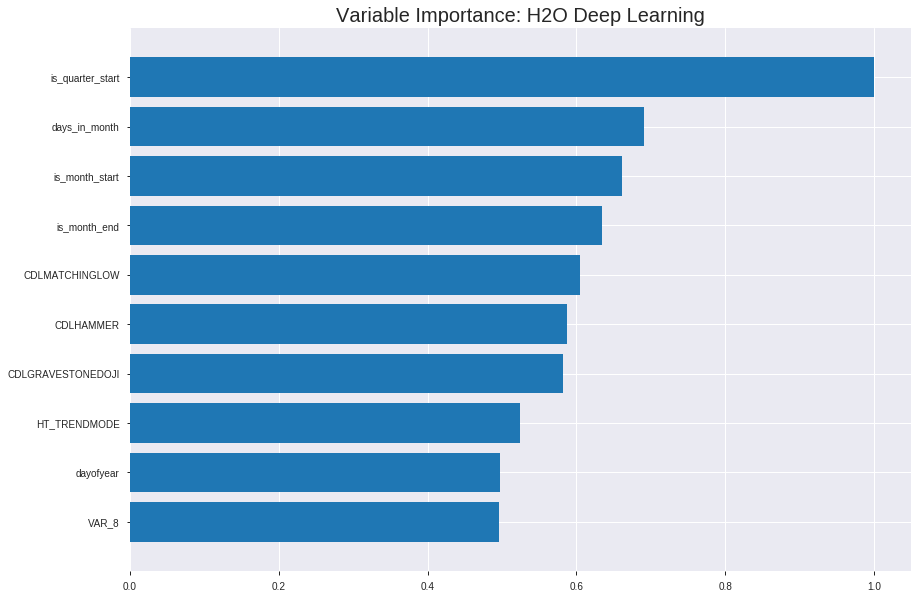

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_061003_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24560881078553695
RMSE: 0.4955893570139869
LogLoss: 0.6886964961383248
Mean Per-Class Error: 0.41623805890484444
AUC: 0.6036177165484052
pr_auc: 0.583551803496318
Gini: 0.20723543309681047
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30462186481949166: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      138  2895  0.9545   (2895.0/3033.0)
1      48   3014  0.0157   (48.0/3062.0)
Total  186  5909  0.4829   (2943.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304622     0.671943  366
max f2                       0.213263     0.835152  392
max f0point5                 0.505831     0.589279  233
max accuracy                 0.515713     0.583921  225
max precision                0.993749     1         0
max recall                   0.190801     1         396
max specificity              0.993749     1         0
max absolute_mcc             0.505831     0.168091  233
max min_per_class_accuracy   0.524293     0.578305  218
max mean_per_class_accuracy  0.515713     0.583762  225

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.905749           1.17474   1.17474            0.590164         0.947754  0.590164                    0.947754            0.011757        0.011757                   17.4738   17.4738
    2        0.0200164                   0.853398           1.43579   1.30526            0.721311         0.880095  0.655738                    0.913924            0.0143697       0.0261267                  43.5791   30.5265
    3        0.0300246                   0.816804           1.24      1.28351            0.622951         0.834574  0.644809                    0.887474            0.0124102       0.0385369                  24.0002   28.3511
    4        0.0400328                   0.797269           1.3379    1.29711            0.672131         0.807353  0.651639                    0.867444            0.0133899       0.0519268                  33.7897   29.7107
    5        0.050041                    0.778079           1.17474   1.27263            0.590164         0.787353  0.639344                    0.851426            0.011757        0.0636839                  17.4738   27.2633
    6        0.100082                    0.713575           1.15516   1.2139             0.580328         0.742738  0.609836                    0.797082            0.0578054       0.121489                   15.5159   21.3896
    7        0.150123                    0.669662           1.27263   1.23348            0.639344         0.690306  0.619672                    0.76149             0.0636839       0.185173                   27.2633   23.3475
    8        0.2                         0.636596           1.18515   1.22142            0.595395         0.653091  0.613618                    0.734457            0.0591117       0.244285                   18.5151   22.1424
    9        0.300082                    0.588178           1.14211   1.19497            0.57377          0.611322  0.600328                    0.69339             0.114304        0.358589                   14.2107   19.497
    10       0.4                         0.552567           1.09822   1.1708             0.551724         0.569868  0.588187                    0.662535            0.109732        0.468321                   9.82229   17.0803
    11       0.500082                    0.524218           1.11274   1.15918            0.559016         0.53779   0.582349                    0.637569            0.111365        0.579686                   11.2738   15.9183
    12       0.6                         0.49751            0.970751  1.1278             0.487685         0.510305  0.566585                    0.616376            0.0969954       0.676682                   -2.92494  12.7803
    13       0.699918                    0.466659           0.902112  1.09558            0.453202         0.482373  0.550398                    0.597246            0.0901372       0.766819                   -9.78883  9.55842
    14       0.8                         0.427299           0.871264  1.06752            0.437705         0.448581  0.5363                      0.578648            0.0871979       0.854017                   -12.8736  6.75212
    15       0.899918                    0.373273           0.81713   1.03972            0.410509         0.402982  0.522334                    0.559144            0.081646        0.935663                   -18.287   3.97203
    16       1                           0.166207           0.642843  1                  0.322951         0.321205  0.502379                    0.53533           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2552646223216349
RMSE: 0.5052371941193907
LogLoss: 0.7079625612398662
Mean Per-Class Error: 0.43134397256660506
AUC: 0.5820865207069376
pr_auc: 0.5569567603766181
Gini: 0.16417304141387512
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22316666463653298: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   874   0.9798   (874.0/892.0)
1      2    848   0.0024   (2.0/850.0)
Total  20   1722  0.5029   (876.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.223167     0.659409  386
max f2                       0.223167     0.827802  386
max f0point5                 0.376981     0.560307  318
max accuracy                 0.567866     0.56946   187
max precision                0.935378     1         0
max recall                   0.199335     1         393
max specificity              0.935378     1         0
max absolute_mcc             0.567041     0.13761   188
max min_per_class_accuracy   0.553241     0.564706  197
max mean_per_class_accuracy  0.567041     0.568656  188

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 55.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.867857           1.48013   1.48013            0.722222         0.892906  0.722222                    0.892906            0.0152941       0.0152941                  48.0131   48.0131
    2        0.0200918                   0.842934           1.08498   1.2882             0.529412         0.853813  0.628571                    0.873918            0.0105882       0.0258824                  8.49827   28.8202
    3        0.0304248                   0.825061           1.25242   1.27605            0.611111         0.835033  0.622642                    0.860712            0.0129412       0.0388235                  25.2418   27.6049
    4        0.0401837                   0.8141             1.20554   1.25892            0.588235         0.818584  0.614286                    0.850481            0.0117647       0.0505882                  20.5536   25.8924
    5        0.0505166                   0.803115           1.48013   1.30417            0.722222         0.809496  0.636364                    0.842097            0.0152941       0.0658824                  48.0131   30.4171
    6        0.100459                    0.75843            1.0836    1.19451            0.528736         0.778503  0.582857                    0.810482            0.0541176       0.12                       8.3597    19.4514
    7        0.150402                    0.724846           1.29561   1.22808            0.632184         0.740236  0.599237                    0.787156            0.0647059       0.184706                   29.5605   22.8083
    8        0.200344                    0.692997           1.06004   1.18619            0.517241         0.707842  0.578797                    0.767384            0.0529412       0.237647                   6.00406   18.6192
    9        0.30023                     0.641631           1.20138   1.19125            0.586207         0.665916  0.581262                    0.733626            0.12            0.357647                   20.1379   19.1245
    10       0.400115                    0.596207           1.07182   1.16143            0.522989         0.619471  0.566714                    0.705128            0.107059        0.464706                   7.18188   16.1431
    11       0.5                         0.551386           1.02471   1.13412            0.5              0.573741  0.553387                    0.678881            0.102353        0.567059                   2.47059   13.4118
    12       0.599885                    0.510835           0.883367  1.09237            0.431034         0.530871  0.533014                    0.654236            0.0882353       0.655294                   -11.6633  9.23659
    13       0.69977                     0.465603           0.918702  1.06758            0.448276         0.488389  0.520919                    0.630563            0.0917647       0.747059                   -8.12982  6.75771
    14       0.799656                    0.413882           0.871589  1.0431             0.425287         0.440192  0.508973                    0.606784            0.0870588       0.834118                   -12.8411  4.30962
    15       0.899541                    0.353838           0.965815  1.03451            0.471264         0.385277  0.504786                    0.582188            0.0964706       0.930588                   -3.41853  3.45148
    16       1                           0.100564           0.690945  1                  0.337143         0.287422  0.487945                    0.552576         


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:18:07  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:18:10  8 min  4.425 sec   961 obs/sec       0.355865  1             2169       0.635105         2.19369             -0.613468      0.533824        0.48411            1.10948          0.497621                         0.63447            1.88531               -0.611145        0.576949          0.501419             1.25242            0.508611
    2019-07-25 06:18:29  8 min 23.900 sec   1200 obs/sec      3.88302   11            23667      0.540475         0.874101            -0.168477      0.560926        0.539586           1.14211          0.494011                         0.535196           0.833668              -0.146406        0.574035          0.535161             1.25242            0.508037
    2019-07-25 06:18:50  8 min 45.103 sec   1266 obs/sec      8.09926   23            49365      0.510876         0.728098            -0.0439992     0.565553        0.559428           1.40316          0.496801                         0.509104           0.723025              -0.0373496       0.593829          0.555218             1.13856            0.495408
    2019-07-25 06:19:10  9 min  5.046 sec   1318 obs/sec      12.3314   35            75160      0.500486         0.697091            -0.00196663    0.588276        0.572061           1.40316          0.491386                         0.512788           0.730341              -0.0524172       0.596379          0.578718             1.48013            0.497704
    2019-07-25 06:19:30  9 min 24.544 sec   1353 obs/sec      16.5678   47            100981     0.520544         0.766077            -0.0838892     0.568108        0.564282           1.27263          0.497129                         0.551467           0.852895              -0.21717         0.57541           0.551925             1.48013            0.501148
    2019-07-25 06:19:49  9 min 44.311 sec   1395 obs/sec      21.18     60            129092     0.526435         0.832003            -0.108561      0.566075        0.535982           1.10948          0.48187                          0.517756           0.754846              -0.0729074       0.584985          0.570736             1.48013            0.510907
    2019-07-25 06:20:10  10 min  4.411 sec  1434 obs/sec      26.0628   74            158853     0.495589         0.688696            0.0175425      0.603618        0.583552           1.17474          0.482855                         0.505237           0.707963              -0.0216524       0.582087          0.556957             1.48013            0.50287

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ---------------------
is_quarter_start  1.0                    1.0                  0.009731665297511098
days_in_month     0.6902257204055786     0.6902257204055786   0.006717045690720567
is_month_start    0.6613502502441406     0.6613502502441406   0.006436039279801184
is_month_end      0.6345776319503784     0.6345776319503784   0.006175497119428267
CDLMATCHINGLOW    0.6050517559051514     0.6050517559051514   0.005888161176140317
---               ---                    ---                  ---
ROCR100_8         0.15470531582832336    0.15470531582832336  0.0015055403533869888
CMO_30            0.15415817499160767    0.15415817499160767  0.0015002157618934715
ROCR_8            0.15386244654655457    0.15386244654655457  0.0014973378316472613
CMO_20            0.15301916003227234    0.15301916003227234  0.001489131249540362
TRIX_8            0.14230991899967194    0.14230991899967194  0.0013849125002207226


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5878300803673938)

('F1', 0.668825910931174)

('auc', 0.6108501012401923)

('logloss', 0.7569348658014124)

('mean_per_class_error', 0.41192894203998986)

('rmse', 0.5239611850904551)

('mse', 0.2745353234813941)

deeplearning prediction progress: |███████████████████████████████████████| 100%


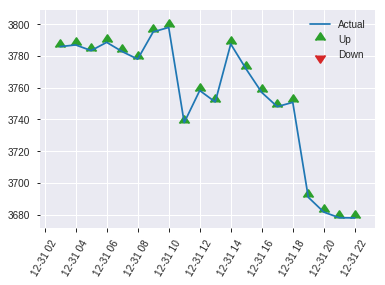


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2745353234813941
RMSE: 0.5239611850904551
LogLoss: 0.7569348658014124
Mean Per-Class Error: 0.41192894203998986
AUC: 0.6108501012401923
pr_auc: 0.5907848369984801
Gini: 0.2217002024803847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46172342343538175: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      49   390  0.8884   (390.0/439.0)
1      19   413  0.044    (19.0/432.0)
Total  68   803  0.4696   (409.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461723     0.668826  342
max f2                       0.242504     0.831729  397
max f0point5                 0.686863     0.586555  188
max accuracy                 0.686863     0.58783   188
max precision                0.937473     1         0
max recall                   0.242504     1         397
max specificity              0.937473     1         0
max absolute_mcc             0.686863     0.176439  188
max min_per_class_accuracy   0.697853     0.580866  179
max mean_per_class_accuracy  0.686863     0.588071  188

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 67.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010333                    0.913363           1.79218   1.79218            0.888889         0.925207  0.888889                    0.925207            0.0185185       0.0185185                  79.2181    79.2181
    2        0.0206659                   0.896847           0.896091  1.34414            0.444444         0.904515  0.666667                    0.914861            0.00925926      0.0277778                  -10.3909   34.4136
    3        0.0309989                   0.891919           1.34414   1.34414            0.666667         0.894648  0.666667                    0.908124            0.0138889       0.0416667                  34.4136    34.4136
    4        0.0401837                   0.882542           1.26013   1.32493            0.625            0.88777   0.657143                    0.903471            0.0115741       0.0532407                  26.0127    32.4934
    5        0.0505166                   0.874916           1.79218   1.42051            0.888889         0.878154  0.704545                    0.898293            0.0185185       0.0717593                  79.2181    42.0507
    6        0.101033                    0.839237           1.28304   1.35177            0.636364         0.857329  0.670455                    0.877811            0.0648148       0.136574                   28.3039    35.1773
    7        0.150402                    0.810386           1.07843   1.26205            0.534884         0.821796  0.625954                    0.859424            0.0532407       0.189815                   7.84345    26.2051
    8        0.200918                    0.795939           0.962279  1.18668            0.477273         0.802969  0.588571                    0.84523             0.0486111       0.238426                   -3.7721    18.668
    9        0.300804                    0.765774           1.29779   1.22357            0.643678         0.780991  0.60687                     0.823898            0.12963         0.368056                   29.7786    22.3574
    10       0.400689                    0.729411           1.11239   1.19586            0.551724         0.748105  0.593123                    0.805004            0.111111        0.479167                   11.2388    19.5857
    11       0.500574                    0.696734           1.01969   1.1607             0.505747         0.713508  0.575688                    0.786747            0.101852        0.581019                   1.96892    16.0704
    12       0.600459                    0.659309           0.996514  1.13339            0.494253         0.679158  0.562141                    0.76885             0.099537        0.680556                   -0.348553  13.3392
    13       0.700344                    0.615607           0.880641  1.09734            0.436782         0.636937  0.544262                    0.750036            0.087963        0.768519                   -11.9359   9.73437
    14       0.80023                     0.562541           0.787942  1.05872            0.390805         0.589637  0.525108                    0.730015            0.0787037       0.847222                   -21.2058   5.87239
    15       0.900115                    0.484445           0.880641  1.03896            0.436782         0.523129  0.515306                    0.707057            0.087963        0.935185                   -11.9359   3.89621
    16       1                           0.156973           0.648893  1                  0.321839         0.392029  0.495982                    0

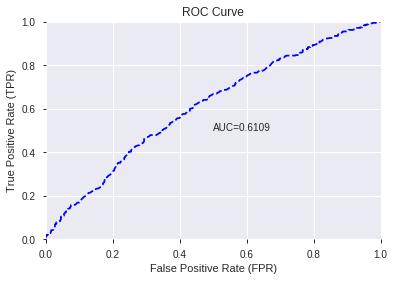

This function is available for GLM models only


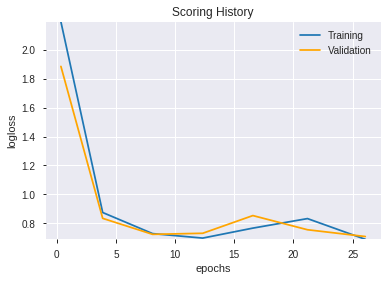

--2019-07-25 06:59:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


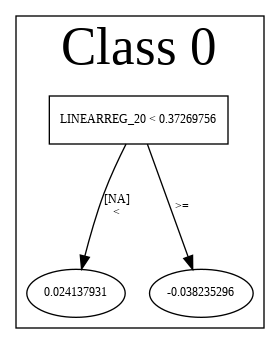

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_061003_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_061003_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['is_quarter_start',
 'days_in_month',
 'is_month_start',
 'is_month_end',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'HT_TRENDMODE',
 'dayofyear',
 'VAR_8',
 'CORREL_12',
 'month',
 'VAR_12',
 'VAR_14',
 'week',
 'VAR_20',
 'BOP',
 'CORREL_14',
 'CORREL_20',
 'VAR_24',
 'CORREL_8',
 'CDLRICKSHAWMAN',
 'VAR_30',
 'CORREL_24',
 'CORREL_30',
 'quarter',
 'OBV',
 'SAREXT',
 'SIN',
 'CDLDOJI',
 'COS',
 'LINEARREG_ANGLE_20',
 'CDLLONGLEGGEDDOJI',
 'LINEARREG_ANGLE_8',
 'LINEARREG_ANGLE_30',
 'day',
 'LINEARREG_ANGLE_24',
 'AD',
 'CDL3INSIDE',
 'STOCHRSI_fastk',
 'LINEARREG_ANGLE_12',
 'CDLHIKKAKE',
 'LINEARREG_ANGLE_14',
 'aroondown_14',
 'weekday',
 'CDLLONGLINE',
 'aroonup_8',
 'weekday_name',
 'aroonup_30',
 'CDLSHORTLINE',
 'hour',
 'aroonup_24',
 'STOCHF_fastk',
 'Volume_(Currency)',
 'aroondown_12',
 'dayofweek',
 'BETA_30',
 'HT_DCPERIOD',
 'MFI_8',
 'WILLR_14',
 'aroondown_20',
 'aroonup_20',
 'ULTOSC',
 'STOCHRSI_fastd',
 'DX_8',
 'aroondown_30',
 'CDLCLOSINGMARUBOZU',

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_070020_model_1  0.602271  0.67802              0.457052  0.492482  0.242538

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.073557           1.000000    0.033685
1                  CDLHIKKAKE             0.046430           0.631209    0.021262
2                CDLSHORTLINE             0.046017           0.625598    0.021073
3                STOCHF_fastk             0.039106           0.531644    0.017908
4              STOCHRSI_fastk             0.038663           0.525619    0.017706
..                        ...                  ...                ...         ...
476  BBANDS_middleband_20_2_2             0.000013           0.000171    0.000006
477   BBANDS_upperband_24_5_5             0.000011           0.000153    0.000005
478                    T3_8_0             0.000010           0.000138    0.000005
479    BBANDS_lowerband_8_0_3             0.000008           0.000115    0.000004
480                    T3_8_7             0.000002           0.000031    0.000001

[481 rows x 4 columns]

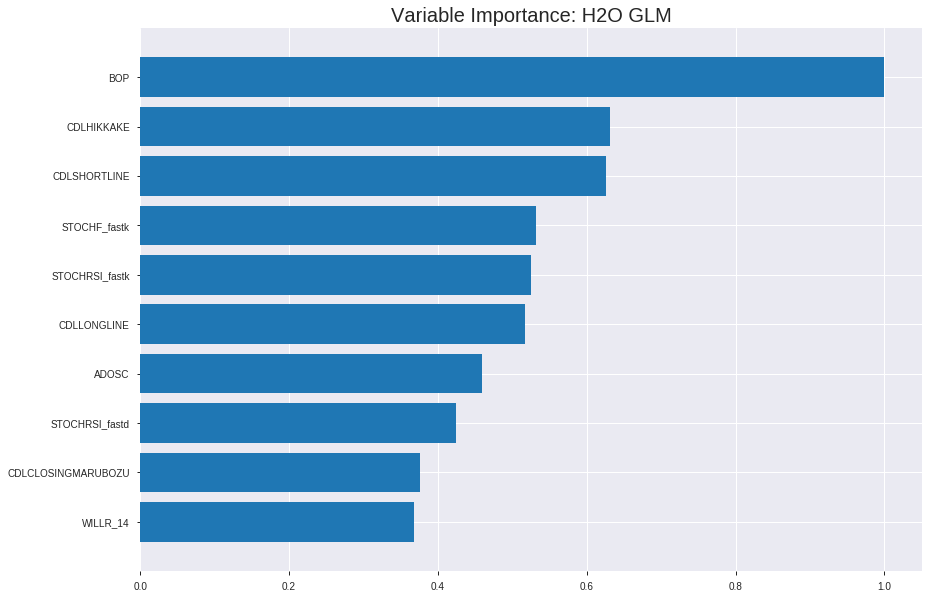

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_070020_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2413171083064976
RMSE: 0.4912403773169482
LogLoss: 0.6755591725411104
Null degrees of freedom: 6094
Residual degrees of freedom: 5613
Null deviance: 8449.32614855268
Residual deviance: 8235.066313276136
AIC: 9199.066313276136
AUC: 0.6101814290572051
pr_auc: 0.593288154635138
Gini: 0.22036285811441014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40245145835639007: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      343  2690  0.8869   (2690.0/3033.0)
1      141  2921  0.046    (141.0/3062.0)
Total  484  5611  0.4645   (2831.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402451     0.673585  329
max f2                       0.307255     0.835015  392
max f0point5                 0.466842     0.588985  246
max accuracy                 0.509315     0.580312  184
max precision                0.729727     1         0
max recall                   0.307255     1         392
max specificity              0.729727     1         0
max absolute_mcc             0.466842     0.162792  246
max min_per_class_accuracy   0.503692     0.578054  193
max mean_per_class_accuracy  0.509315     0.580463  184

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.656075           1.3379    1.3379             0.672131         0.675717  0.672131                    0.675717            0.0133899       0.0133899                  33.7897   33.7897
    2        0.0200164                   0.640274           1.24      1.28895            0.622951         0.648431  0.647541                    0.662074            0.0124102       0.0258001                  24.0002   28.8949
    3        0.0300246                   0.632304           1.27263   1.28351            0.639344         0.6359    0.644809                    0.653349            0.0127368       0.0385369                  27.2633   28.3511
    4        0.0400328                   0.625061           1.53369   1.34605            0.770492         0.62878   0.67623                     0.647207            0.0153494       0.0538863                  53.3686   34.6054
    5        0.050041                    0.618407           1.40316   1.35748            0.704918         0.621801  0.681967                    0.642126            0.0140431       0.0679295                  40.316    35.7476
    6        0.100082                    0.594634           1.27263   1.31505            0.639344         0.605928  0.660656                    0.624027            0.0636839       0.131613                   27.2633   31.5054
    7        0.150123                    0.577159           1.20737   1.27916            0.606557         0.585364  0.642623                    0.611139            0.060418        0.192031                   20.737    27.916
    8        0.2                         0.564987           1.19825   1.25898            0.601974         0.570836  0.632486                    0.601088            0.0597649       0.251796                   19.8246   25.8981
    9        0.300082                    0.542519           1.12905   1.21565            0.567213         0.553589  0.610716                    0.585246            0.112998        0.364794                   12.9054   21.5648
    10       0.4                         0.522833           1.10149   1.18713            0.553366         0.532561  0.59639                     0.572086            0.110059        0.474853                   10.1491   18.7133
    11       0.500082                    0.503306           1.03116   1.15592            0.518033         0.512896  0.580709                    0.56024             0.103201        0.578054                   3.11593   15.5917
    12       0.6                         0.483007           0.967482  1.12454            0.486043         0.493309  0.564944                    0.549094            0.0966688       0.674722                   -3.25179  12.4537
    13       0.699918                    0.461956           0.970751  1.10258            0.487685         0.472438  0.553915                    0.538151            0.0969954       0.771718                   -2.92494  10.2583
    14       0.8                         0.438834           0.845159  1.07038            0.42459          0.450515  0.537736                    0.527187            0.0845852       0.856303                   -15.4841  7.03788
    15       0.899918                    0.409903           0.800788  1.04045            0.402299         0.42554   0.522698                    0.515901            0.0800131       0.936316                   -19.9212  4.04461
    16       1                           0.260656           0.636317  1                  0.319672         0.380788  0.502379                    0.502379          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24259758279597296
RMSE: 0.4925419604419231
LogLoss: 0.6781209954432813
Null degrees of freedom: 1741
Residual degrees of freedom: 1260
Null deviance: 2415.3638887467546
Residual deviance: 2362.573548124392
AIC: 3326.573548124392
AUC: 0.6019572672118175
pr_auc: 0.5817867149220474
Gini: 0.20391453442363505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38262678937752503: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      45   847   0.9496   (847.0/892.0)
1      9    841   0.0106   (9.0/850.0)
Total  54   1688  0.4914   (856.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382627     0.662727  367
max f2                       0.336999     0.827492  393
max f0point5                 0.508321     0.570832  205
max accuracy                 0.532749     0.580367  169
max precision                0.715683     1         0
max recall                   0.336999     1         393
max specificity              0.715683     1         0
max absolute_mcc             0.532749     0.158972  169
max min_per_class_accuracy   0.516326     0.574118  194
max mean_per_class_accuracy  0.518566     0.578822  189

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.670833           1.36627   1.36627            0.666667         0.687045  0.666667                    0.687045            0.0141176       0.0141176                  36.6275   36.6275
    2        0.0200918                   0.65626            1.5672    1.46387            0.764706         0.663407  0.714286                    0.675564            0.0152941       0.0294118                  56.7197   46.3866
    3        0.0304248                   0.644588           1.36627   1.43072            0.666667         0.650158  0.698113                    0.666935            0.0141176       0.0435294                  36.6275   43.0721
    4        0.0401837                   0.638436           1.5672    1.46387            0.764706         0.641034  0.714286                    0.660645            0.0152941       0.0588235                  56.7197   46.3866
    5        0.0505166                   0.632899           1.13856   1.39733            0.555556         0.635815  0.681818                    0.655566            0.0117647       0.0705882                  13.8562   39.7326
    6        0.100459                    0.60535            1.41339   1.40531            0.689655         0.617952  0.685714                    0.636867            0.0705882       0.141176                   41.3387   40.5311
    7        0.150402                    0.59121            1.15427   1.32195            0.563218         0.598008  0.645038                    0.623963            0.0576471       0.198824                   15.4266   32.1949
    8        0.200344                    0.578756           1.03648   1.25079            0.505747         0.585178  0.610315                    0.614295            0.0517647       0.250588                   3.64841   25.0787
    9        0.30023                     0.555888           1.14249   1.21476            0.557471         0.56703   0.592734                    0.59857             0.114118        0.364706                   14.2488   21.4756
    10       0.400115                    0.535607           1.10715   1.18789            0.54023          0.545736  0.579627                    0.58538             0.110588        0.475294                   10.7153   18.7894
    11       0.5                         0.515075           1.01293   1.15294            0.494253         0.525521  0.562572                    0.573422            0.101176        0.576471                   1.29277   15.2941
    12       0.599885                    0.490973           0.895145  1.11002            0.436782         0.502997  0.541627                    0.561696            0.0894118       0.665882                   -10.4855  11.0016
    13       0.69977                     0.470562           0.895145  1.07935            0.436782         0.481404  0.526661                    0.550235            0.0894118       0.755294                   -10.4855  7.93457
    14       0.799656                    0.44886            0.871589  1.05339            0.425287         0.459869  0.513999                    0.538948            0.0870588       0.842353                   -12.8411  5.33947
    15       0.899541                    0.423359           0.80092   1.02536            0.390805         0.43616   0.500319                    0.527534            0.08            0.922353                   -19.908   2.53598
    16       1                           0.30194            0.772921  1                  0.377143         0.390747  0.487945                    0.513792         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 07:00:24  0.000 sec   2            6.8       479           1.37787           1.37725
    2019-07-25 07:00:25  1.604 sec   4            4.9       482           1.37592           1.37502
    2019-07-25 07:00:27  3.217 sec   6            3.6       482           1.37373           1.37263
    2019-07-25 07:00:29  4.877 sec   8            2.6       482           1.37134           1.37009
    2019-07-25 07:00:30  6.508 sec   10           1.9       482           1.3688            1.36748
    2019-07-25 07:00:32  8.127 sec   12           1.4       482           1.36614           1.36492
    2019-07-25 07:00:33  9.799 sec   14           1         482           1.36345           1.36253
    2019-07-25 07:00:35  11.411 sec  16           0.73      482           1.36077           1.36044
    2019-07-25 07:00:37  13.038 sec  18           0.53      482           1.35817           1.35871
    2019-07-25 07:00:39  14.813 sec  20           0.39      482           1.35567           1.35742
    2019-07-25 07:00:40  16.454 sec  22           0.28      482           1.35331           1.35661
    2019-07-25 07:00:42  18.081 sec  24           0.21      482           1.35112           1.35624
    2019-07-25 07:00:43  19.750 sec  26           0.15      482           1.34909           1.35632
    2019-07-25 07:00:45  21.436 sec  28           0.11      482           1.34721           1.35677
    2019-07-25 07:00:47  23.212 sec  30           0.079     482           1.34547           1.35756
    2019-07-25 07:00:49  24.872 sec  32           0.058     482           1.34385           1.35863
    2019-07-25 07:00:50  26.502 sec  34           0.042     482           1.34233           1.35993

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5832376578645235)

('F1', 0.6737184703010577)

('auc', 0.6022710495233274)

('logloss', 0.6780201274050537)

('mean_per_class_error', 0.4158572724204843)

('rmse', 0.4924817005249539)

('mse', 0.24253822535195038)

glm prediction progress: |████████████████████████████████████████████████| 100%


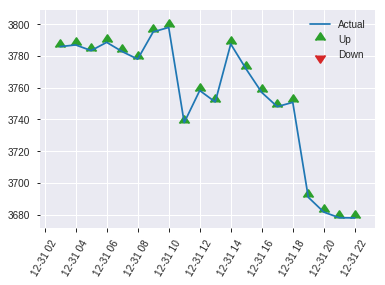


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24253822535195038
RMSE: 0.4924817005249539
LogLoss: 0.6780201274050537
Null degrees of freedom: 870
Residual degrees of freedom: 389
Null deviance: 1207.5487194139707
Residual deviance: 1181.1110619396036
AIC: 2145.1110619396036
AUC: 0.6022710495233274
pr_auc: 0.5795158126658999
Gini: 0.20454209904665488
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4216793995200128: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   383  0.8724   (383.0/439.0)
1      18   414  0.0417   (18.0/432.0)
Total  74   797  0.4604   (401.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421679     0.673718  347
max f2                       0.384266     0.83301   383
max f0point5                 0.502017     0.586973  236
max accuracy                 0.502358     0.583238  235
max precision                0.737145     1         0
max recall                   0.352657     1         394
max specificity              0.737145     1         0
max absolute_mcc             0.502017     0.172663  236
max min_per_class_accuracy   0.524364     0.569444  199
max mean_per_class_accuracy  0.502017     0.584143  236

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.681061           1.34414   1.34414            0.666667         0.702803  0.666667                    0.702803            0.0138889       0.0138889                  34.4136   34.4136
    2        0.0206659                   0.669709           1.56816   1.45615            0.777778         0.675784  0.722222                    0.689294            0.0162037       0.0300926                  56.8158   45.6147
    3        0.0309989                   0.65388            1.34414   1.41881            0.666667         0.658592  0.703704                    0.67906             0.0138889       0.0439815                  34.4136   41.881
    4        0.0401837                   0.645039           1.76418   1.49775            0.875            0.649243  0.742857                    0.672245            0.0162037       0.0601852                  76.4178   49.7751
    5        0.0505166                   0.637101           1.12011   1.42051            0.555556         0.639965  0.704545                    0.665642            0.0115741       0.0717593                  12.0113   42.0507
    6        0.101033                    0.612361           1.14557   1.28304            0.568182         0.624294  0.636364                    0.644968            0.0578704       0.12963                    14.557    28.3039
    7        0.150402                    0.598879           0.937769  1.16971            0.465116         0.605471  0.580153                    0.632003            0.0462963       0.175926                   -6.22308  16.9706
    8        0.200918                    0.586448           1.37468   1.22124            0.681818         0.592856  0.605714                    0.622161            0.0694444       0.24537                    37.4684   22.1243
    9        0.300804                    0.5663             1.15874   1.20049            0.574713         0.575007  0.59542                     0.606503            0.115741        0.361111                   15.8738   20.0488
    10       0.400689                    0.544417           1.04286   1.16119            0.517241         0.555937  0.575931                    0.593897            0.104167        0.465278                   4.2864    16.1195
    11       0.500574                    0.523857           1.06604   1.14221            0.528736         0.534635  0.566514                    0.582072            0.106481        0.571759                   6.60387   14.2207
    12       0.600459                    0.503805           1.06604   1.12954            0.528736         0.513377  0.560229                    0.570645            0.106481        0.678241                   6.60387   12.9537
    13       0.700344                    0.482828           0.903815  1.09734            0.448276         0.494002  0.544262                    0.559714            0.0902778       0.768519                   -9.61845  9.73437
    14       0.80023                     0.455924           0.92699   1.07608            0.45977          0.467674  0.533716                    0.548225            0.0925926       0.861111                   -7.30098  7.608
    15       0.900115                    0.428136           0.787942  1.04411            0.390805         0.44211   0.517857                    0.53645             0.0787037       0.939815                   -21.2058  4.41055
    16       1                           0.310044           0.602544  1                  0.298851         0.398393  0.495982                    0.52266             

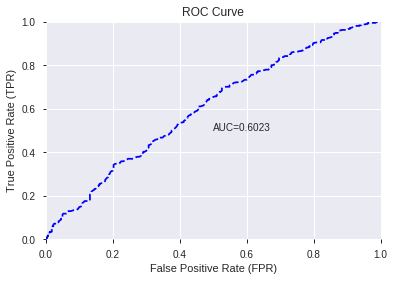

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


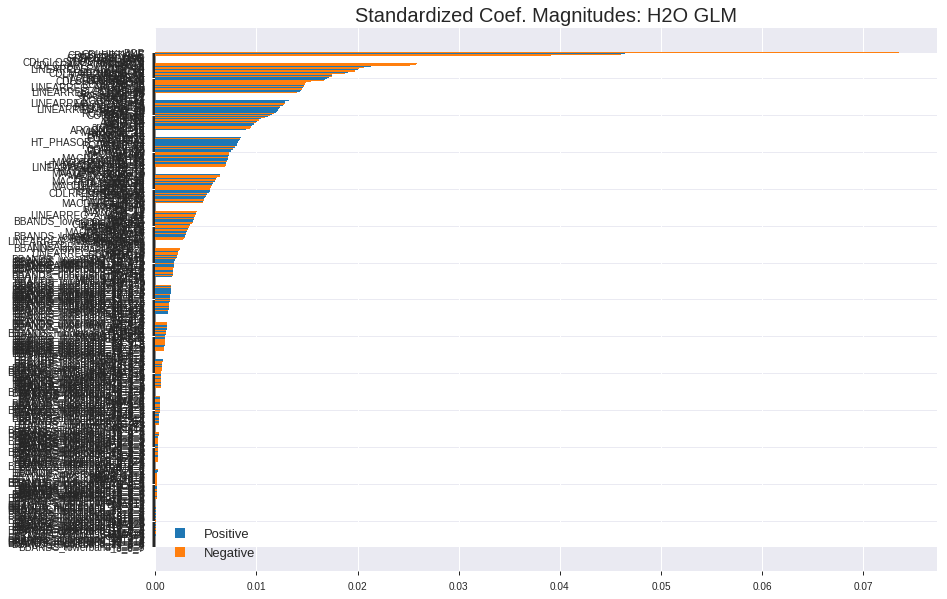

'log_likelihood'
--2019-07-25 07:01:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.33.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.33.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


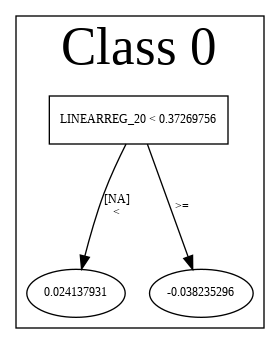

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_070020_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_070020_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLHIKKAKE',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'ADOSC',
 'STOCHRSI_fastd',
 'CDLCLOSINGMARUBOZU',
 'WILLR_14',
 'WILLR_8',
 'CDLGRAVESTONEDOJI',
 'MFI_8',
 'CCI_24',
 'LINEARREG_ANGLE_30',
 'CDLENGULFING',
 'ULTOSC',
 'aroondown_20',
 'WILLR_12',
 'CDLMATCHINGLOW',
 'BETA_14',
 'WILLR_30',
 'VAR_8',
 'HT_TRENDMODE',
 'AROONOSC_20',
 'CORREL_30',
 'CDLHARAMI',
 'CDLSPINNINGTOP',
 'CMO_8',
 'ROCR100_30',
 'RSI_8',
 'ROCR_30',
 'LINEARREG_ANGLE_20',
 'ROCP_30',
 'quarter',
 'ROC_30',
 'STOCH_slowk',
 'LINEARREG_SLOPE_24',
 'CCI_30',
 'days_in_month',
 'aroondown_24',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'VAR_14',
 'ROCR100_12',
 'PPO',
 'LINEARREG_ANGLE_24',
 'MACDEXT_hist',
 'MFI_12',
 'CCI_8',
 'HT_DCPERIOD',
 'MINUS_DI_20',
 'LINEARREG_SLOPE_8',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'MOM_20',
 'CORREL_14',
 'hour',
 'MOM_12',
 'VAR_20',
 'TAN',
 'CCI_20',
 'BETA_24',
 'ADXR_14',
 'VAR_12',
 'ADXR_8',
 'MOM_24',
 'CMO_30',
 'aroo

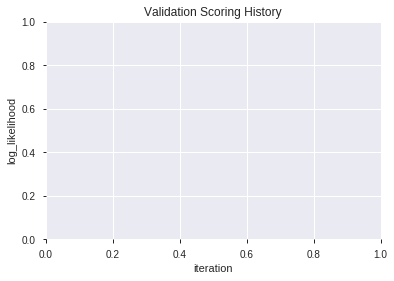

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_070205_model_7  0.604494  0.681257              0.463904  0.494023  0.244058
1  XGBoost_grid_1_AutoML_20190725_070205_model_2  0.603998  0.677026              0.448199  0.492021  0.242085
2  XGBoost_grid_1_AutoML_20190725_070205_model_6  0.599991  0.677265              0.479573  0.492153  0.242215
3  XGBoost_grid_1_AutoML_20190725_070205_model_4  0.598891  0.677758              0.434550  0.492374  0.242432
4  XGBoost_grid_1_AutoML_20190725_070205_model_1  0.597924  0.678644              0.455987  0.492819  0.242870
5               XGBoost_2_AutoML_20190725_070205  0.592901  0.681827              0.435670  0.494380  0.244411
6               XGBoost_3_AutoML_20190725_070205  0.591501  0.678184              0.462654  0.492639  0.242693
7  XGBoost_grid_1_AutoML_20190725_070205_model_3  0.586711  0.680715              0.463996  0.493840  0.243878
8               XGBoost_1_AutoML_20190725_070205  0.573299  0.690971              0.484128  0.498812  0.248814
9  XGBoost_grid_1_AutoML_20190725_070205_model_5  0.566035  0.703985              0.493166  0.504248  0.254266

variable  relative_importance  scaled_importance  percentage
0                        BOP           759.321594           1.000000    0.029657
1             STOCHRSI_fastd           478.323456           0.629935    0.018682
2             STOCHRSI_fastk           463.842346           0.610864    0.018116
3               STOCHF_fastk           435.937225           0.574114    0.017026
4                        TAN           364.573608           0.480131    0.014239
..                       ...                  ...                ...         ...
343  BBANDS_upperband_30_1_5             3.758496           0.004950    0.000147
344   BBANDS_upperband_8_2_3             2.622606           0.003454    0.000102
345   BBANDS_lowerband_8_4_4             1.449245           0.001909    0.000057
346  BBANDS_lowerband_20_6_2             1.144079           0.001507    0.000045
347   BBANDS_upperband_8_2_5             0.950321           0.001252    0.000037

[348 rows x 4 columns]

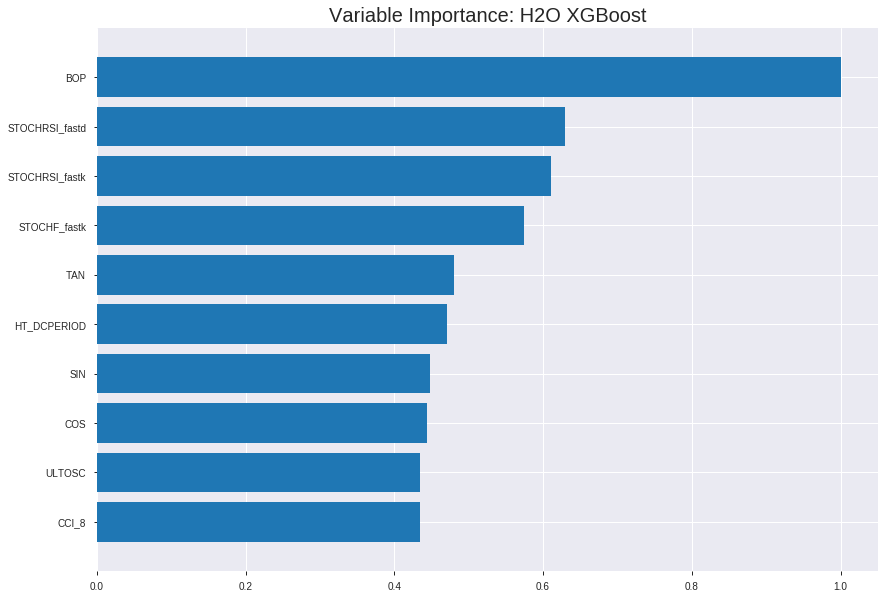

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_070205_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1555801266659046
RMSE: 0.39443646721101305
LogLoss: 0.49629845386804067
Mean Per-Class Error: 0.09450895365436973
AUC: 0.9686659783961445
pr_auc: 0.9695989024195273
Gini: 0.9373319567922891
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5106448966723222: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      2743  290   0.0956   (290.0/3033.0)
1      286   2776  0.0934   (286.0/3062.0)
Total  3029  3066  0.0945   (576.0/6095.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510645     0.906005  191
max f2                       0.454395     0.93603   227
max f0point5                 0.542892     0.920937  166
max accuracy                 0.510645     0.905496  191
max precision                0.838033     1         0
max recall                   0.334687     1         313
max specificity              0.838033     1         0
max absolute_mcc             0.510645     0.810988  191
max min_per_class_accuracy   0.510645     0.904385  191
max mean_per_class_accuracy  0.510645     0.905491  191

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100082                   0.765027           1.99053    1.99053            1                0.786695  1                           0.786695            0.0199216       0.0199216                  99.0529   99.0529
    2        0.0200164                   0.74916            1.99053    1.99053            1                0.756181  1                           0.771438            0.0199216       0.0398432                  99.0529   99.0529
    3        0.0300246                   0.737614           1.99053    1.99053            1                0.742895  1                           0.761924            0.0199216       0.0597649                  99.0529   99.0529
    4        0.0400328                   0.728605           1.99053    1.99053            1                0.733312  1                           0.754771            0.0199216       0.0796865                  99.0529   99.0529
    5        0.050041                    0.722102           1.99053    1.99053            1                0.72513   1                           0.748843            0.0199216       0.0996081                  99.0529   99.0529
    6        0.100082                    0.689527           1.99053    1.99053            1                0.703935  1                           0.726389            0.0996081       0.199216                   99.0529   99.0529
    7        0.150123                    0.664213           1.99053    1.99053            1                0.67654   1                           0.709773            0.0996081       0.298824                   99.0529   99.0529
    8        0.2                         0.641566           1.97743    1.98726            0.993421         0.652806  0.998359                    0.695566            0.0986283       0.397453                   97.7433   98.7263
    9        0.300082                    0.599052           1.91548    1.96332            0.962295         0.620026  0.986331                    0.670372            0.191705        0.589157                   91.5476   96.3321
    10       0.4                         0.561228           1.77808    1.91705            0.893268         0.579743  0.963084                    0.647733            0.177662        0.766819                   77.8075   91.7048
    11       0.500082                    0.510996           1.36074    1.80571            0.683607         0.535973  0.907152                    0.625367            0.136185        0.903005                   36.0739   80.5713
    12       0.6                         0.458767           0.689658   1.61986            0.34647          0.485654  0.813782                    0.6021              0.0689092       0.971914                   -31.0342  61.9856
    13       0.699918                    0.406675           0.19938    1.41707            0.100164         0.431898  0.711908                    0.577803            0.0199216       0.991835                   -80.062   41.7074
    14       0.8                         0.362243           0.0652632  1.24796            0.0327869        0.383476  0.626948                    0.553492            0.00653168      0.998367                   -93.4737  24.7959
    15       0.899918                    0.309077           0.0163426  1.11121            0.00821018       0.337698  0.55825                     0.529532            0.00163292      1                          -98.3657  11.1212
    16       1                           0.127941           0          1                  0                0.261768  0.502379                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2500316902622996
RMSE: 0.5000316892580905
LogLoss: 0.6946816660764842
Mean Per-Class Error: 0.4378211553679767
AUC: 0.5729787654972303
pr_auc: 0.538071354040524
Gini: 0.14595753099446052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21861223876476288: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    888   0.9955   (888.0/892.0)
1      0    850   0        (0.0/850.0)
Total  4    1738  0.5098   (888.0/1742.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.218612     0.656878  395
max f2                       0.218612     0.82717   395
max f0point5                 0.418969     0.561879  286
max accuracy                 0.51392      0.562572  200
max precision                0.873067     1         0
max recall                   0.218612     1         395
max specificity              0.873067     1         0
max absolute_mcc             0.509486     0.1244    203
max min_per_class_accuracy   0.503887     0.558296  207
max mean_per_class_accuracy  0.509486     0.562179  203

Gains/Lift Table: Avg response rate: 48.79 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.783352           0.796993  0.796993           0.388889         0.810131  0.388889                    0.810131            0.00823529      0.00823529                 -20.3007  -20.3007
    2        0.0200918                   0.756525           1.20554   0.995429           0.588235         0.767747  0.485714                    0.789545            0.0117647       0.02                       20.5536   -0.457143
    3        0.0304248                   0.743188           1.13856   1.04404            0.555556         0.748273  0.509434                    0.775528            0.0117647       0.0317647                  13.8562   4.404
    4        0.0401837                   0.731395           1.44664   1.14182            0.705882         0.738926  0.557143                    0.766639            0.0141176       0.0458824                  44.6644   14.1815
    5        0.0505166                   0.717711           1.13856   1.14115            0.555556         0.72283   0.556818                    0.757678            0.0117647       0.0576471                  13.8562   14.115
    6        0.100459                    0.681102           1.22494   1.1828             0.597701         0.697761  0.577143                    0.727891            0.0611765       0.118824                   22.4936   18.2803
    7        0.150402                    0.642735           1.20138   1.18897            0.586207         0.660613  0.580153                    0.70555             0.06            0.178824                   20.1379   18.8972
    8        0.200344                    0.614476           1.24849   1.20381            0.609195         0.628475  0.587393                    0.686337            0.0623529       0.241176                   24.8492   20.3809
    9        0.30023                     0.56728            0.918702  1.10896            0.448276         0.590653  0.541109                    0.654503            0.0917647       0.332941                   -8.12982  10.8955
    10       0.400115                    0.535484           1.09538   1.10557            0.534483         0.550244  0.539455                    0.628476            0.109412        0.442353                   9.53753   10.5565
    11       0.5                         0.502025           1.17782   1.12               0.574713         0.5203    0.546498                    0.606865            0.117647        0.56                       17.7823   12
    12       0.599885                    0.473986           0.93048   1.08844            0.454023         0.488301  0.5311                      0.587123            0.0929412       0.652941                   -6.95199  8.84436
    13       0.69977                     0.441198           1.00115   1.07598            0.488506         0.457782  0.525021                    0.568661            0.1             0.752941                   0.114943  7.59832
    14       0.799656                    0.40851            0.954037  1.06075            0.465517         0.424872  0.517588                    0.5507              0.0952941       0.848235                   -4.59635  6.07508
    15       0.899541                    0.367985           0.80092   1.0319             0.390805         0.389676  0.50351                     0.53282             0.08            0.928235                   -19.908   3.18991
    16       1                           0.171994           0.714366  1                  0.348571         0.318304  0.487945                    0.51127             0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:03:09  38.147 sec  0                  0.5              0.693147            0.5             0                  1                0.497621                         0.5                0.693147              0.5               0                    1                  0.512055
    2019-07-25 07:03:10  39.087 sec  5                  0.483496         0.660581            0.809912        0.803905           1.92527          0.276128                         0.498733           0.69061               0.540135          0.525835             1.13856            0.504018
    2019-07-25 07:03:10  39.427 sec  10                 0.468834         0.632272            0.862525        0.862517           1.99053          0.224118                         0.498492           0.690131              0.548633          0.530953             1.02471            0.507463
    2019-07-25 07:03:11  39.773 sec  15                 0.455698         0.607332            0.892741        0.894087           1.99053          0.18671                          0.498925           0.691055              0.549039          0.530102             1.02471            0.504592
    2019-07-25 07:03:11  40.102 sec  20                 0.445033         0.587355            0.910736        0.91146            1.99053          0.17621                          0.498491           0.690212              0.558066          0.536926             1.13856            0.509185
    2019-07-25 07:03:11  40.423 sec  25                 0.435452         0.569597            0.925317        0.926035           1.99053          0.165874                         0.498139           0.6896                0.565073          0.540268             1.25242            0.509759
    2019-07-25 07:03:12  40.759 sec  30                 0.42651          0.553221            0.935915        0.936885           1.99053          0.148482                         0.498769           0.691071              0.564258          0.537905             1.13856            0.509759
    2019-07-25 07:03:12  41.153 sec  35                 0.417233         0.536529            0.947872        0.947988           1.99053          0.13224                          0.499004           0.691794              0.568583          0.538246             1.02471            0.510333
    2019-07-25 07:03:12  41.563 sec  40                 0.409218         0.52229             0.957312        0.957024           1.99053          0.11452                          0.499041           0.692108              0.573027          0.540396             0.796993           0.510333
    2019-07-25 07:03:13  41.911 sec  45                 0.401791         0.509206            0.963672        0.964399           1.99053          0.10402                          0.499047           0.692358              0.575576          0.542277             0.796993           0.510333
    2019-07-25 07:03:13  42.272 sec  50                 0.394436         0.496298            0.968666        0.969599           1.99053          0.0945037                        0.500032           0.694682              0.572979          0.538071             0.796993           0.509759

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      759.3215942382812      1.0                    0.029656796846035123
STOCHRSI_fastd           478.3234558105469      0.6299352730648736     0.018681862419436618
STOCHRSI_fastk           463.84234619140625     0.6108641578364605     0.018116274229480245
STOCHF_fastk             435.9372253417969      0.5741140890100859     0.017026384904218643
TAN                      364.5736083984375      0.48013069977834893    0.014239138622871175
---                      ---                    ---                    ---
BBANDS_upperband_30_1_5  3.758496046066284      0.004949807926688356   0.0001467954481086909
BBANDS_upperband_8_2_3   2.6226062774658203     0.0034538808027667197  0.00010243104129807331
BBANDS_lowerband_8_4_4   1.4492454528808594     0.0019086056077921504  5.6603128769495196e-05
BBANDS_lowerband_20_6_2  1.1440792083740234     0.0015067123298682353  4.468426147231851e-05
BBANDS_upperband_8_2_5   0.9503211975097656     0.0012515398017398504  3.711666164492582e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5855338691159586)

('F1', 0.6699107866991079)

('auc', 0.6044935881211507)

('logloss', 0.6812568422565007)

('mean_per_class_error', 0.4143729435585928)

('rmse', 0.49402257663900356)

('mse', 0.24405830622904012)

xgboost prediction progress: |████████████████████████████████████████████| 100%


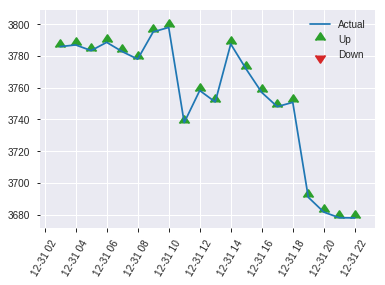


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24405830622904012
RMSE: 0.49402257663900356
LogLoss: 0.6812568422565007
Mean Per-Class Error: 0.4143729435585928
AUC: 0.6044935881211507
pr_auc: 0.5895841859292751
Gini: 0.20898717624230145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36422544717788696: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   388  0.8838   (388.0/439.0)
1      19   413  0.044    (19.0/432.0)
Total  70   801  0.4673   (407.0/871.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364225     0.669911  348
max f2                       0.264122     0.833012  394
max f0point5                 0.545154     0.583183  197
max accuracy                 0.545154     0.585534  197
max precision                0.808042     1         0
max recall                   0.264122     1         394
max specificity              0.808042     1         0
max absolute_mcc             0.545154     0.171289  197
max min_per_class_accuracy   0.548256     0.583144  194
max mean_per_class_accuracy  0.545154     0.585627  197

Gains/Lift Table: Avg response rate: 49.60 %, avg score: 54.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010333                    0.764055           1.56816   1.56816            0.777778         0.784645  0.777778                    0.784645            0.0162037       0.0162037                  56.8158   56.8158
    2        0.0206659                   0.753747           1.79218   1.68017            0.888889         0.758688  0.833333                    0.771667            0.0185185       0.0347222                  79.2181   68.017
    3        0.0309989                   0.740748           1.12011   1.49348            0.555556         0.746276  0.740741                    0.763203            0.0115741       0.0462963                  12.0113   49.3484
    4        0.0401837                   0.72946            1.0081    1.38254            0.5              0.736784  0.685714                    0.757164            0.00925926      0.0555556                  0.810185  38.254
    5        0.0505166                   0.722395           1.34414   1.37468            0.666667         0.726263  0.681818                    0.750844            0.0138889       0.0694444                  34.4136   37.4684
    6        0.101033                    0.688078           1.23722   1.30595            0.613636         0.701975  0.647727                    0.726409            0.0625          0.131944                   23.7216   30.595
    7        0.150402                    0.664956           1.40665   1.33901            0.697674         0.67486   0.664122                    0.709488            0.0694444       0.201389                   40.6654   33.9006
    8        0.200918                    0.645689           0.962279  1.24429            0.477273         0.655534  0.617143                    0.695923            0.0486111       0.25                       -3.7721   24.4286
    9        0.300804                    0.611628           1.06604   1.1851             0.528736         0.627047  0.587786                    0.673052            0.106481        0.356481                   6.60387   18.5097
    10       0.400689                    0.578246           1.15874   1.17853            0.574713         0.593874  0.584527                    0.653314            0.115741        0.472222                   15.8738   17.8526
    11       0.500574                    0.548184           1.13556   1.16995            0.563218         0.562842  0.580275                    0.635261            0.113426        0.585648                   13.5563   16.9953
    12       0.600459                    0.515929           0.880641  1.12183            0.436782         0.531216  0.556405                    0.617953            0.087963        0.673611                   -11.9359  12.1827
    13       0.700344                    0.482627           0.787942  1.07421            0.390805         0.500374  0.532787                    0.601184            0.0787037       0.752315                   -21.2058  7.42069
    14       0.80023                     0.43455            1.06604   1.07319            0.528736         0.456969  0.532281                    0.583183            0.106481        0.858796                   6.60387   7.31873
    15       0.900115                    0.381888           0.787942  1.04153            0.390805         0.410207  0.516582                    0.563988            0.0787037       0.9375                     -21.2058  4.15338
    16       1                           0.203293           0.625718  1                  0.310345         0.325817  0.495982                    0.540198            

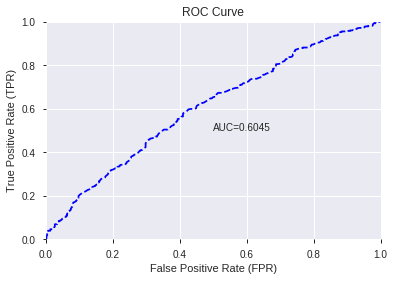

This function is available for GLM models only


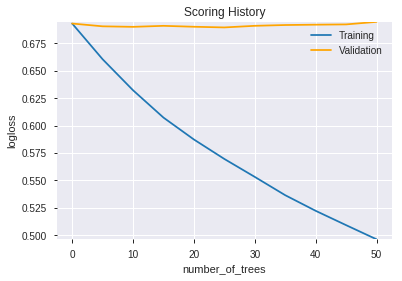

--2019-07-25 07:03:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.

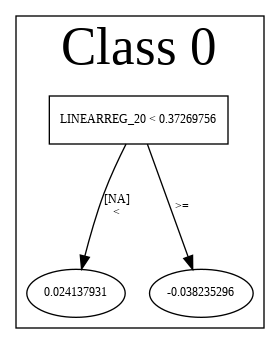

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_070205_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_070205_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8d36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'TAN',
 'HT_DCPERIOD',
 'SIN',
 'COS',
 'ULTOSC',
 'CCI_8',
 'BETA_8',
 'CORREL_8',
 'Volume_(Currency)',
 'WILLR_14',
 'STOCH_slowd',
 'MFI_8',
 'MFI_30',
 'WILLR_8',
 'CORREL_20',
 'STOCH_slowk',
 'MINUS_DI_8',
 'DIV',
 'BETA_12',
 'MFI_20',
 'CORREL_24',
 'ADOSC',
 'MFI_14',
 'WILLR_20',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'hour',
 'ADX_8',
 'AD',
 'MINUS_DM_8',
 'CCI_14',
 'WILLR_24',
 'CORREL_14',
 'MFI_12',
 'HT_PHASOR_inphase',
 'TRANGE',
 'DX_8',
 'DX_12',
 'BETA_20',
 'CORREL_30',
 'CORREL_12',
 'MFI_24',
 'STDDEV_12',
 'STDDEV_8',
 'ADXR_14',
 'MACDFIX_hist_14',
 'MOM_8',
 'ADXR_12',
 'MINUS_DI_14',
 'AROONOSC_20',
 'WILLR_12',
 'ROC_12',
 'ROC_24',
 'PLUS_DI_14',
 'STDDEV_20',
 'CCI_12',
 'MACDFIX_hist_12',
 'DX_20',
 'BETA_14',
 'MINUS_DI_12',
 'MACDFIX_hist_24',
 'ADX_24',
 'LINEARREG_ANGLE_24',
 'BETA_30',
 'ADXR_8',
 'PLUS_DM_8',
 'STDDEV_24',
 'LINEARREG_SLOPE_20',
 'PLUS_DI_20',
 'PLUS_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.588
GLM             0.584
XGBoost         0.586
dtype: float64

DeepLearning    GLM  XGBoost
All          0.587  0.576    0.576
DLF          0.576  0.572    0.579
Fwe          0.582  0.584    0.580
RFE          0.588  0.583    0.586
XGBF         0.576  0.572    0.579





F1


DeepLearning    0.675
GLM             0.675
XGBoost         0.678
dtype: float64

DeepLearning    GLM  XGBoost
All          0.669  0.672    0.678
DLF          0.665  0.666    0.674
Fwe          0.675  0.675    0.671
RFE          0.669  0.674    0.670
XGBF         0.674  0.666    0.674





auc


DeepLearning    0.611
GLM             0.612
XGBoost         0.606
dtype: float64

DeepLearning    GLM  XGBoost
All          0.601  0.599    0.606
DLF          0.592  0.593    0.603
Fwe          0.609  0.612    0.599
RFE          0.611  0.602    0.604
XGBF         0.593  0.593    0.603





logloss


DeepLearning    0.757
GLM             0.680
XGBoost         0.681
dtype: float64

DeepLearning    GLM  XGBoost
All          0.723  0.679    0.675
DLF          0.685  0.680    0.676
Fwe          0.676  0.675    0.677
RFE          0.757  0.678    0.681
XGBF         0.681  0.680    0.676





mean_per_class_error


DeepLearning    0.425
GLM             0.429
XGBoost         0.422
dtype: float64

DeepLearning    GLM  XGBoost
All          0.414  0.423    0.421
DLF          0.425  0.429    0.422
Fwe          0.417  0.416    0.420
RFE          0.412  0.416    0.414
XGBF         0.423  0.429    0.422





rmse


DeepLearning    0.524
GLM             0.494
XGBoost         0.494
dtype: float64

DeepLearning    GLM  XGBoost
All          0.511  0.493    0.491
DLF          0.495  0.494    0.492
Fwe          0.492  0.491    0.492
RFE          0.524  0.492    0.494
XGBF         0.494  0.494    0.492





mse


DeepLearning    0.275
GLM             0.244
XGBoost         0.244
dtype: float64

DeepLearning    GLM  XGBoost
All          0.261  0.243    0.241
DLF          0.245  0.244    0.242
Fwe          0.242  0.241    0.242
RFE          0.275  0.243    0.244
XGBF         0.244  0.244    0.242

{'F1':       DeepLearning    GLM  XGBoost
 All          0.669    NaN      NaN
 DLF          0.665    NaN      NaN
 DLF            NaN  0.666      NaN
 DLF            NaN    NaN    0.674
 All            NaN  0.672      NaN
 All            NaN    NaN    0.678
 XGBF         0.674    NaN      NaN
 XGBF           NaN  0.666      NaN
 XGBF           NaN    NaN    0.674
 Fwe          0.675    NaN      NaN
 Fwe            NaN  0.675      NaN
 Fwe            NaN    NaN    0.671
 RFE          0.669    NaN      NaN
 RFE            NaN  0.674      NaN
 RFE            NaN    NaN    0.670,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.587    NaN      NaN
 DLF          0.576    NaN      NaN
 DLF            NaN  0.572      NaN
 DLF            NaN    NaN    0.579
 All            NaN  0.576      NaN
 All            NaN    NaN    0.576
 XGBF         0.576    NaN      NaN
 XGBF           NaN  0.572      NaN
 XGBF           NaN    NaN    0.579
 Fwe          0.582    NaN      NaN
 Fwe     